<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/03-modelagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem de fraude com modelos de contagem

* Identificação da janela de tempo para modelagem dos dados transacionais em janelas de transações/fraudes
* Criação dos modelos Poisson, Binomial Negativo, Zero Inflated Poisson e Zero Inflated Binomial Negative
* Análise do melhor modelo
* Inferência estatística do melhor modelo
* Conclusão

## Biblitecas

Bibliotecas utilizadas para o processo

In [1]:
%pip install statstests

In [2]:
import os
import tqdm
import math
import shutil
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
from textwrap import dedent
import statsmodels.api as sm
from scipy.stats import entropy
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.cluster import KMeans
from __future__ import annotations
from warnings import filterwarnings
from IPython.display import Markdown
from statstests.tests import overdisp
import statsmodels.formula.api as smf
from statstests.process import stepwise
from scipy.stats import poisson, nbinom
from statsmodels.genmod import families
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from statsmodels.stats.stattools import durbin_watson
from statsmodels.genmod.generalized_linear_model import GLM
from pandas.tseries.holiday import USFederalHolidayCalendar
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from typing import Dict, List, Set, Tuple, Optional, Any, Union, Iterable
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

## Carregamento de dados e ajuste de dados/valores

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df = df.filter(pl.col('amount') >= pl.lit(0))
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,"""Bettendorf""","""IA""",52722.0,"""5311""",null,"""Department Stores""","""No""",48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,"""YES""",1,9100.0,"""09/2005""",2015,"""No"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,"""Vista""","""CA""",92084.0,"""4829""",null,"""Money Transfer""","""No""",49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,"""YES""",1,14802.0,"""01/2006""",2008,"""No"""
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,"""Harwood""","""MD""",20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…","""No""",51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,"""YES""",1,19113.0,"""07/2009""",2014,"""No"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,"""Bronx""","""NY""",10464.0,"""5942""",null,"""Book Stores""","""No""",47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,"""YES""",1,89.0,"""01/2008""",2015,"""No"""
7475335,2010-01-01 00:14:00,1684,2140,26.46,"""Online Transaction""",39021,"""ONLINE""",null,null,"""4784""",null,"""Tolls and Bridge Fees""","""No""",56,65,1963,11,"""Male""","""27019 Madison Lane""",36.34,-83.28,13668.0,27861.0,108313.0,782,5,"""Mastercard""","""Debit (Prepaid)""",5955075527372953,"""05/2021""",513,"""YES""",1,46.0,"""03/2007""",2012,"""No"""


In [5]:
df.shape

(8472184, 38)

In [6]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
).with_columns(
    pl.when(pl.col('has_chip').str.to_lowercase() == 'yes')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('card_has_chip')
).drop('merchant_state', 'merchant_city', 'has_chip')

In [7]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

## Scripts de código

Scripts para pre-processar e transformar os dados em função da janela de tempo.

### Feature Engineering

As features foram **construídas a partir de dados transacionais**, agregadas em janelas de tempo de duração configurável. O objetivo é estruturar variáveis que representem volume, comportamento, risco, sazonalidade, mudança, rede e a variável-alvo de fraude.  

---

#### 1. Features Temporais Básicas

**Propósito:** quantificar o volume de atividade em cada janela de tempo.

- **Total de Transações (`total_transactions`)**  
  Número de transações ocorridas dentro da janela.

- **Valor Total (`total_amount`)**  
  Soma de todos os valores monetários movimentados na janela.

- **Proporção de Transações com Chip (`chip_ratio`)**  
  Fração de transações realizadas com chip em relação ao total do período.

---

#### 2. Features Comportamentais

**Propósito:** capturar intensidade e padrões de comportamento.

- **Duração em Segundos (`duration_sec`)**  
  Duração exata da janela de agregação, em segundos.  
  Serve como base para análise de taxas ou exposição em modelos de contagem.

- **Velocidade de Transações (`transactions_per_seconds`)**  
  Taxa média de transações por segundo na janela.  
  Relaciona o número de transações com a duração da janela.

- **Valor Médio por Transação (`avg_transactions_value`)**  
  Valor monetário médio de cada transação na janela.

- **Dispersão Geográfica (`geo_dispersion`)**  
  Grau de espalhamento espacial das transações, baseado na variação de latitude e longitude.  
  Valores altos indicam operações em locais mais dispersos.

- **Diversidade de Estabelecimentos (`merchant_entropy`)**  
  Medida de diversidade de estabelecimentos onde as transações ocorreram, baseada no conceito de entropia.  
  Valores altos indicam grande variedade de estabelecimentos.

---

#### 3. Features de Risco

**Propósito:** sintetizar o risco associado às transações na janela.

- **Score de Crédito Médio (`avg_credit_score`)**  
  Média do score de crédito dos clientes que transacionaram na janela.

- **Proporção de Transações com Erro (`error_ratio`)**  
  Percentual de transações que apresentaram algum erro operacional ou de sistema.

---

#### 4. Features Sazonais e Cíclicas

**Propósito:** identificar padrões temporais e efeitos de calendário.

- **Codificação Cíclica da Hora (`hour_sin`, `hour_cos`)**  
  Representação circular da hora do dia, permitindo capturar padrões diários sem perda de continuidade entre 23h e 0h (as colunas originais de hora são descartadas após a codificação).

- **Codificação Cíclica do Dia da Semana (`day_sin`, `day_cos`)**  
  Representação circular do dia da semana, útil para modelar padrões semanais (a variável categórica original de dia é descartada após a codificação).

- **Indicador de Feriado (`is_holiday`)**  
  Variável binária que marca se o período corresponde a um feriado oficial com base no **USFederalHolidayCalendar** (feriados federais dos EUA).

---

#### 5. Features de Mudança

**Propósito:** detectar variações e anomalias em relação a períodos anteriores.

- **Variação no Volume de Transações (`change_volume_transaction`)**  
  Diferença percentual no número de transações em relação à janela anterior.

- **Alerta de Velocidade (`velocity_alert`)**  
  Indicador binário que sinaliza quando o volume de transações ultrapassa significativamente a média histórica recente (mais de **2 desvios-padrão** acima da média móvel) calculada sobre **168 períodos (24×7)** de acordo com a frequência configurada.

---

#### 6. Features de Rede

**Propósito:** analisar a estrutura de relacionamento entre entidades transacionais.

- **Clientes Únicos (`unique_clients`)**  
  Número de clientes distintos que transacionaram na janela.

- **Cartões Únicos (`unique_cards`)**  
  Número de cartões distintos utilizados.

- **Cartões por Cliente (`cards_per_client`)**  
  Relação entre cartões distintos e clientes distintos, sugerindo possíveis indícios de risco em clientes que usam muitos cartões.

---

#### 7. Variável Alvo

- **Fraudes (`frauds`)**  
  Número de transações classificadas como fraudulentas dentro da janela.  
  É a variável que será utilizada como alvo em modelagens de contagem ou classificação.

---

#### 8. Estrutura do Conjunto Final

O conjunto final resultante do processo de engenharia contém, para cada janela de tempo definida:

- Medidas de **volume** e **valor** de transações.  
- Indicadores de **comportamento** e **intensidade**.  
- Variáveis relacionadas a **risco operacional** e **perfil de crédito**.  
- **Padrões sazonais e cíclicos** ligados a hora, dia da semana e feriados.  
- Indicadores de **mudança de comportamento** em relação ao histórico recente.  
- Estruturas de **rede** de clientes e cartões.  
- A variável-alvo de **fraudes**, representando a contagem de eventos que se deseja modelar.

---


In [8]:
class FraudFeatureEngineer:
    def __init__(self, freq='1H'):
        """
        Inicializa o motor de feature engineering para agregação temporal

        Parâmetros:
        freq (str): Frequência para agregação temporal ('1H', '1D', etc.)
        """
        self.freq = freq
        self.cal = USFederalHolidayCalendar()

    def process(self, df: pd.DataFrame):
        """
        Carrega e pré-processa os dados brutos

        Parâmetros:
        filepath (str): Caminho para o arquivo CSV

        Retorna:
        pd.DataFrame: DataFrame pré-processado
        """

        # Converter coluna de data para datetime
        df['date'] = pd.to_datetime(df['date'])

        # Ordenar por data
        df = df.sort_values('date').reset_index(drop=True)

        # Pré-processar colunas categóricas
        df['use_chip'] = df['use_chip'].map({'Chip Transaction': 1, 'Swipe Transaction': 0, 'Online': 0})
        df['online_sales'] = df['online_sales'].map({'Yes': 1, 'No': 0})
        df['card_has_chip'] = df['card_has_chip'].map({'Yes': 1, 'No': 0})

        # Preencher valores ausentes
        df['zip'] = df['zip'].fillna(0)
        df['errors'] = df['errors'].fillna('No Error')

        return df

    def create_time_index(self, df):
        """
        Cria o índice temporal para agregação

        Parâmetros:
        df (pd.DataFrame): DataFrame com dados brutos

        Retorna:
        pd.DatetimeIndex: Índice temporal para agregação
        """
        return pd.date_range(
            start=df['date'].min().floor('H'),
            end=df['date'].max().ceil('H'),
            freq=self.freq
        )

    def add_temporal_features(self, features_df, df):
        """
        Adiciona features temporais básicas

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Contagem total de transações por período
        features_df['total_transactions'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()

        # Valor total transacionado por período
        features_df['total_amount'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['amount'].sum()

        # Proporção de transações com chip
        chip_count = df[df['use_chip'] == 1].groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()
        features_df['chip_ratio'] = chip_count / features_df['total_transactions']

        return features_df

    def add_behavioral_features(self, features_df, df):
        """
        Adiciona features comportamentais agregadas

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Calcular window_size_seconds baseado na frequência configurada
        freq_seconds = pd.Timedelta(self.freq).total_seconds()
        features_df['duration_sec'] = freq_seconds

        # Velocidade de transações (transações por segundo)
        features_df['transactions_per_seconds'] = features_df['total_transactions'] / freq_seconds

        # Valor médio por transação
        features_df['avg_transactions_value'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['amount'].mean()

        # Dispersão geográfica das transações
        def geographic_dispersion(group):
            if len(group) <= 1:
                return 0
            return np.std(group['latitude']) + np.std(group['longitude'])

        geo_dispersion = df.groupby(
            pd.Grouper(key='date', freq=self.freq)).apply(geographic_dispersion)
        features_df['geo_dispersion'] = geo_dispersion

        # Diversidade de merchants (entropia)
        merchant_counts = df.groupby([pd.Grouper(key='date', freq=self.freq),
                                     'merchant_id'])['id'].count()

        def calculate_entropy(group):
            if len(group) <= 1:
                return 0
            return entropy(group.values)

        merchant_entropy = merchant_counts.groupby(level=0).apply(calculate_entropy)
        features_df['merchant_entropy'] = merchant_entropy

        return features_df

    def add_risk_features(self, features_df, df):
        """
        Adiciona features de risco agregadas

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Média de credit score por período
        features_df['avg_credit_score'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['credit_score'].mean()

        # Proporção de transações com erro
        error_count = df[df['errors'] != 'No Error'].groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()
        features_df['error_ratio'] = error_count / features_df['total_transactions']

        return features_df

    def add_seasonal_features(self, features_df):
        """
        Adiciona features sazonais e temporais

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        """

        # Componentes temporais
        features_df['hour_of_day'] = features_df.index.hour
        features_df['day_of_week'] = features_df.index.dayofweek
        # features_df['is_weekend'] = features_df['day_of_week'].isin([5, 6]).astype(int)

        features_df['hour_sin'] = np.sin(2 * np.pi * features_df['hour_of_day'] / 24)
        features_df['hour_cos'] = np.cos(2 * np.pi * features_df['hour_of_day'] / 24)

        # Codificação cíclica para dias da semana
        features_df['day_sin'] = np.sin(2 * np.pi * features_df['day_of_week'] / 7)
        features_df['day_cos'] = np.cos(2 * np.pi * features_df['day_of_week'] / 7)

        # Remover as colunas originais que tinham ponderação arbitrária
        features_df.drop(['hour_of_day', 'day_of_week'], axis=1, inplace=True)


        # Feriados
        holidays = self.cal.holidays(
            start=features_df.index.min(),
            end=features_df.index.max()
        )
        features_df['is_holiday'] = features_df.index.normalize().isin(
            [h.date() for h in holidays]
        ).astype(int)

        return features_df

    def add_change_features(self, features_df):
        """
        Adiciona features de mudança comportamental

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        """
        # Mudanças no volume de transações
        features_df['change_volume_transaction'] = features_df['total_transactions'].pct_change()

        # Alertas de velocidade (mais de 2 desvios padrão da média móvel)
        rolling_mean = features_df['total_transactions'].rolling(
            window=24*7, min_periods=1).mean()
        rolling_std = features_df['total_transactions'].rolling(
            window=24*7, min_periods=1).std()
        features_df['velocity_alert'] = (
            (features_df['total_transactions'] - rolling_mean) > (2 * rolling_std)
        ).astype(int)

        return features_df

    def add_network_features(self, features_df, df):
        """
        Adiciona features de rede e relacionamento

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Número de clientes únicos por período
        features_df['unique_clients'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['client_id'].nunique()

        # Número de cartões únicos por período
        features_df['unique_cards'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['card_id'].nunique()

        # Razão cartões/clientes (possível indicador de fraude)
        features_df['cards_per_client'] = features_df['unique_cards'] / features_df['unique_clients'].replace(0, 1)

        return features_df

    def add_target_variable(self, features_df, df):
        """
        Adiciona a variável target (contagem de fraudes)

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Contagem de fraudes por período
        fraud_count = df[df['target'] == 1].groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()
        features_df['frauds'] = fraud_count
        features_df['frauds'].fillna(0, inplace=True)

        return features_df

    def engineer_features(self, df: pd.DataFrame, debug=False):
        """
        Executa todo o pipeline de engenharia de features

        Parâmetros:
        df: DataFrame

        Retorna:
        pd.DataFrame: DataFrame com features agregadas
        """
        # Carregar e pré-processar dados
        if debug:
          print("Carregando e pré-processando dados...")
        df = self.process(df)

        # Criar índice temporal
        if debug:
          print("Criando índice temporal...")
        time_index = self.create_time_index(df)
        features_df = pd.DataFrame(index=time_index)

        # Adicionar features
        if debug:
          print("Adicionando features temporais...")
        features_df = self.add_temporal_features(features_df, df)

        if debug:
          print("Adicionando features comportamentais...")
        features_df = self.add_behavioral_features(features_df, df)

        if debug:
          print("Adicionando features de risco...")
        features_df = self.add_risk_features(features_df, df)

        if debug:
          print("Adicionando features sazonais...")
        features_df = self.add_seasonal_features(features_df)

        if debug:
          print("Adicionando features de mudança...")
        features_df = self.add_change_features(features_df)

        if debug:
          print("Adicionando features de rede...")
        features_df = self.add_network_features(features_df, df)

        if debug:
          print("Adicionando variável target...")
        features_df = self.add_target_variable(features_df, df)

        # Preencher valores NaN
        if debug:
          print("Preenchendo valores ausentes...")
        features_df.fillna(method='ffill', inplace=True)
        features_df.fillna(0, inplace=True)

        if debug:
            print("Feature engineering concluído!")
        return features_df

### Modelagem Baseline

O script abaixo modela os quatro tipos de modelos de contagem tomando como base apenas o intercepto com a variável alvo:

* **Poisson**
* **Binomial Negativo**
* **Zero Inflated Poisson**
* **Zero Inflated Binomial Negativo**

In [9]:
@dataclass
class ModelResult:
    """
    Model base response
    """
    name: str
    model: Any


class BaselineCountingModel:
    """
    Baseline counting model
    """
    def __init__(self, df: pd.DataFrame, window: str, offset: Optional[np.ndarray] = None) -> None:
        self.df = df
        self.models: List[ModelResult] = []
        self.window = window
        self.offset = offset

        self.model_name_map = {
            'Poisson': self._plot_poisson_dist,
            'Binomial Negativa': self._plot_neg_binomial_dist,
            'ZIP': self._plot_zip_dist,
            'ZINB': self._plot_zinb_dist,
        }

    def _offset_log(self) -> Optional[np.ndarray]:
        if self.offset is None:
            return None
        off = np.asarray(self.offset, dtype=float)
        if np.any(~np.isfinite(off)) or np.any(off <= 0):
            raise ValueError("Offset/exposição precisa ser positiva e finita.")
        return np.log(off)

    @staticmethod
    def _get_intercept(params: pd.Series) -> float:
        if 'Intercept' in params.index:
            return params['Intercept']
        if 'const' in params.index:
            return params['const']
        return float(params.iloc[0])

    def train_poisson(self):
        offset_log = self._offset_log()
        model = smf.glm('frauds ~ 1', data=self.df,
                        family=sm.families.Poisson(),
                        offset=offset_log)
        return model.fit(disp=False, maxiter=1000)

    def train_binomial(self):
        offset_log = self._offset_log()
        model = sm.NegativeBinomial.from_formula("frauds ~ 1",
                                                 data=self.df,
                                                 offset=offset_log)
        return model.fit(disp=False, maxiter=1000)

    def train_zip(self):
        offset_log = self._offset_log()
        model = sm.ZeroInflatedPoisson.from_formula("frauds ~ 1",
                                                    data=self.df,
                                                    offset=offset_log,
                                                    inflation='logit')
        return model.fit(method="bfgs", maxiter=1000, disp=False)

    def train_zimb(self):
        offset_log = self._offset_log()
        model = sm.ZeroInflatedNegativeBinomialP.from_formula("frauds ~ 1",
                                                              data=self.df,
                                                              offset=offset_log,
                                                              inflation='logit')
        return model.fit(method="bfgs", maxiter=2000, disp=False)

    def train(self) -> None:
        """
        Train all baseline models with only the intercept.
        """
        models = {
            'Poisson': self.train_poisson,
            'Binomial Negativa': self.train_binomial,
            'ZIP': self.train_zip,
            'ZINB': self.train_zimb
        }
        for model_name, action in models.items():
            try:
                result = action()
                self.models.append(ModelResult(name=model_name, model=result))
            except Exception as e:
                failed = ModelResult(name=model_name, model=e)
                self.models.append(failed)

    def _get_exposures(self) -> Optional[np.ndarray|float]:
        off_log = self._offset_log()
        if off_log is None:
            return None
        expv = np.asarray(np.exp(off_log))
        if expv.ndim == 0 or (expv.ndim == 1 and np.allclose(expv, expv[0])):
            return float(np.mean(expv))
        return expv

    def _mix_pmf_poisson(self, k_vec: np.ndarray, rate: float, exposures: Optional[np.ndarray]):
        if exposures is None:
            mu = rate
            return poisson.pmf(k_vec, mu)
        if np.isscalar(exposures):
            mu = rate * exposures
            return poisson.pmf(k_vec, mu)
        mu_i = rate * exposures
        return np.mean([poisson.pmf(k_vec, m) for m in mu_i], axis=0)

    def _mix_pmf_nbinom(self, k_vec: np.ndarray, mu_base: float, alpha: float, exposures: Optional[np.ndarray]):
        if exposures is None:
            mu = mu_base
            n = 1.0 / alpha
            p = n / (n + mu)
            return nbinom.pmf(k_vec, n=n, p=p)
        if np.isscalar(exposures):
            mu = mu_base * exposures
            n = 1.0 / alpha
            p = n / (n + mu)
            return nbinom.pmf(k_vec, n=n, p=p)
        n = 1.0 / alpha
        mu_i = mu_base * exposures
        pmfs = []
        for m in mu_i:
            p = n / (n + m)
            pmfs.append(nbinom.pmf(k_vec, n=n, p=p))
        return np.mean(pmfs, axis=0)

    def get_report(self, criterion: str = 'BIC') -> pd.DataFrame:
         """Return a DataFrame summarising diagnostics for each fitted model.
         In addition to ranking by the selected information criterion (LLF, AIC or
         BIC), this method now accounts for convergence and overdispersion when
         determining the ``Best`` model.  Models that did not converge or whose
         Pearson‐residual dispersion (φ) falls outside the range [0.5, 4] are
         deprioritised in the ranking.  This range is a pragmatic choice; values
         near one suggest acceptable dispersion for Poisson‐like count models,
         while extremely high or low values signal overdispersion or
         underdispersion【425780944042139†L294-L307】.  If all models fall outside
         this band, the ranking reverts to the selected information criterion.
         Parameters
         ----------
         criterion : {'LLF', 'AIC', 'BIC'}, optional
             Statistic used to rank models.  'LLF' ranks by log‑likelihood (higher
             is better), whereas 'AIC' and 'BIC' rank by those information
             criteria (lower is better).  Default is 'BIC'.
         Returns
         -------
         pandas.DataFrame
             Table with one row per model and columns for log‑likelihood,
             information criteria, convergence status, residual diagnostics and
             pseudo‑R².  A boolean ``Best`` column flags the top‑ranked model.
         """
         if criterion not in {'LLF', 'AIC', 'BIC'}:
             raise ValueError("criterion must be one of 'LLF', 'AIC' or 'BIC'")
         metrics: List[Dict[str, Any]] = []
         for result in self.models:
             model_name = result.name
             model_obj = result.model
             metric: Dict[str, Any] = dict(
                 window=self.window,
                 model_name=model_name,
                 LLF=np.nan,
                 BIC=np.nan,
                 AIC=np.nan,
                 Converged=np.nan,
             )
             if isinstance(model_obj, Exception):
                 metrics.append(metric)
                 continue
             metric['LLF'] = getattr(model_obj, 'llf', np.nan)
             metric['BIC'] = getattr(model_obj, 'bic', np.nan)
             metric['AIC'] = getattr(model_obj, 'aic', np.nan)
             metric['Converged'] = getattr(model_obj, 'converged', getattr(model_obj, 'mle_retvals', {}).get('converged', np.nan))
             try:
                 if hasattr(model_obj, 'resid_pearson') and np.asarray(model_obj.resid_pearson).size:
                     resid = np.asarray(model_obj.resid_pearson)
                 else:
                     endog = getattr(model_obj.model, 'endog', None)
                     mu = np.asarray(model_obj.predict())
                     if hasattr(model_obj, 'mu') and model_obj.mu is not None:
                         var = np.asarray(model_obj.mu)
                     elif hasattr(model_obj.model, 'var_weights') and model_obj.model.var_weights is not None:
                         var = np.asarray(model_obj.model.var_weights)
                     else:
                         var = np.maximum(mu, 1e-8)
                     resid = (np.asarray(endog) - mu) / np.sqrt(var)
             except Exception:
                 resid = np.array([])
             if resid.size == 0 or not np.any(np.isfinite(resid)):
                 metric.update(
                     RMSE_Pearson=np.nan,
                     Outliers=np.nan,
                     Pct_resid_gt_2=np.nan,
                     Pct_resid_gt_3=np.nan,
                     Dispersion=np.nan,
                     df_resid=np.nan,
                     PseudoR2=np.nan,
                 )
                 metrics.append(metric)
                 continue
             df_resid = getattr(model_obj, 'df_resid', None)
             if df_resid is None:
                 nobs = getattr(model_obj, 'nobs', getattr(getattr(model_obj, 'model', None), 'nobs', np.nan))
                 params = getattr(model_obj, 'df_modelwc', getattr(model_obj, 'df_model', np.nan))
                 try:
                     df_resid = float(nobs) - float(params)
                 except Exception:
                     df_resid = np.nan
             resid_finite = resid[np.isfinite(resid)]
             rmse_resid = float(np.sqrt(np.mean(resid_finite ** 2))) if resid_finite.size else np.nan
             outliers = int(np.sum(np.abs(resid_finite) > 2)) if resid_finite.size else np.nan
             pct_gt_2 = float(100.0 * np.mean(np.abs(resid_finite) > 2)) if resid_finite.size else np.nan
             pct_gt_3 = float(100.0 * np.mean(np.abs(resid_finite) > 3)) if resid_finite.size else np.nan
             if df_resid is None or not np.isfinite(df_resid) or df_resid == 0:
                 dispersion = np.nan
             else:
                 dispersion = float((resid_finite ** 2).sum() / df_resid)
             pseudo_r2 = np.nan
             if hasattr(model_obj, 'prsquared'):
                 pseudo_r2 = float(model_obj.prsquared)
             else:
                 try:
                     pseudo_r2 = float(model_obj.pseudo_rsquared())
                 except Exception:
                     llnull = getattr(model_obj, 'llnull', getattr(model_obj, 'llf_null', np.nan))
                     if np.isfinite(llnull) and llnull != 0:
                         try:
                             pseudo_r2 = float(1.0 - (model_obj.llf / llnull))
                         except Exception:
                             pseudo_r2 = np.nan
             metric.update(
                 RMSE_Pearson=rmse_resid,
                 Outliers=outliers,
                 Pct_resid_gt_2=pct_gt_2,
                 Pct_resid_gt_3=pct_gt_3,
                 Dispersion=dispersion,
                 df_resid=df_resid,
                 PseudoR2=pseudo_r2,
             )
             metrics.append(metric)
         df = pd.DataFrame(metrics)
         df['ranking_value'] = np.where(
             (df['Converged'] == True) &
             (df['Dispersion'].between(0.5, 4, inclusive='both')),
             1,
             0
         )
         if df['ranking_value'].sum() > 0:
             preferred = df[df['ranking_value'] == 1].copy()
             non_preferred = df[df['ranking_value'] == 0].copy()
             if criterion == 'LLF':
                 preferred_sort = preferred.sort_values(by=criterion, ascending=False)
                 non_pref_sort = non_preferred.sort_values(by=criterion, ascending=False)
             else:
                 preferred_sort = preferred.sort_values(by=criterion, ascending=True)
                 non_pref_sort = non_preferred.sort_values(by=criterion, ascending=True)
             df_sorted = pd.concat([preferred_sort, non_pref_sort], ignore_index=True)
             df_sorted['RankApplied'] = True
         else:
             if criterion == 'LLF':
                 df_sorted = df.sort_values(by=criterion, ascending=False).reset_index(drop=True)
             else:
                 df_sorted = df.sort_values(by=criterion, ascending=True).reset_index(drop=True)
             df_sorted['RankApplied'] = False
         df_sorted['Best'] = False
         if not df_sorted.empty:
             df_sorted.loc[0, 'Best'] = True
         df_sorted = df_sorted.drop(columns=['ranking_value'])
         return df_sorted

    def plot_theoretical_distributions(self, target_col: str = 'frauds', fig_size=(12, 8)) -> None:
        if not self.models:
            raise RuntimeError("Nenhum modelo foi treinado. Execute o método .train() primeiro.")

        y = self.df[target_col]
        max_frauds = int(y.max())
        bins = np.arange(0, max_frauds + 2)
        total_obs = len(y)

        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=fig_size)
        ax = sns.histplot(y, bins=bins, stat='count', discrete=True,
                          color='skyblue', alpha=0.6, label='Observado')
        exposures = self._get_exposures()
        for res in self.models:
            name = res.name
            model_obj = res.model
            if name in self.model_name_map and not isinstance(model_obj, Exception):
                self.model_name_map[name](ax, model_obj, bins, total_obs, exposures)
        ax.set_title('Distribuição de Fraudes: Observada vs. Teórica', fontsize=16)
        ax.set_xlabel('Fraudes', fontsize=12)
        ax.set_ylabel('Frequência', fontsize=12)
        ax.legend(fontsize=12)
        ax.set_xlim(left=-0.5, right=max_frauds + 0.5)
        plt.tight_layout()
        plt.show()

    def _plot_poisson_dist(self, ax, model_obj, bins, total_obs, exposures=None) -> None:
        intercept = self._get_intercept(model_obj.params)
        rate = np.exp(intercept)
        pmf = self._mix_pmf_poisson(bins[:-1], rate, exposures)
        # For constant exposures, rate*exposures yields the mean count per window
        label = (f'Poisson (λ={ (rate * exposures):.2f})' if np.isscalar(exposures)
                 else f'Poisson (rate={rate:.4g}/unit)')
        ax.plot(bins[:-1], pmf * total_obs, 'o-', color='red',
                label=label, linewidth=2, markersize=4)

    def _plot_neg_binomial_dist(self, ax, model_obj, bins, total_obs, exposures=None) -> None:
        intercept = self._get_intercept(model_obj.params)
        mu_base = np.exp(intercept)
        # The 'alpha' parameter appears either in params or as the dispersion/scale
        alpha = model_obj.params.get('alpha', getattr(model_obj, 'scale', None))
        if alpha is None:
            return
        pmf = self._mix_pmf_nbinom(bins[:-1], mu_base, alpha, exposures)
        if exposures is None:
            mu_lbl = mu_base
        elif np.isscalar(exposures):
            mu_lbl = mu_base * exposures
        else:
            mu_lbl = mu_base * np.mean(exposures)
        ax.plot(bins[:-1], pmf * total_obs, 'o-', color='green',
                label=f'Binomial Negativa (μ≈{mu_lbl:.2f}, α={alpha:.2f})',
                linewidth=2, markersize=4)

    def _plot_zip_dist(self, ax, model_obj, bins, total_obs, exposures=None) -> None:
        intercept = self._get_intercept(model_obj.params)
        rate = np.exp(intercept)
        pi = 1 / (1 + np.exp(-model_obj.params.get('inflate_const')))
        base_pmf = self._mix_pmf_poisson(bins[:-1], rate, exposures)
        pmf = (1 - pi) * base_pmf
        # Adjust the zero probability for zero inflation
        if exposures is None:
            mu0 = rate
            p0 = poisson.pmf(0, mu0)
        elif np.isscalar(exposures):
            mu0 = rate * exposures
            p0 = poisson.pmf(0, mu0)
        else:
            p0 = np.mean([poisson.pmf(0, rate * t) for t in exposures])
        pmf[0] = pi + (1 - pi) * p0
        if exposures is None:
            lam_lbl = rate
        elif np.isscalar(exposures):
            lam_lbl = rate * exposures
        else:
            lam_lbl = rate * np.mean(exposures)
        ax.plot(bins[:-1], pmf * total_obs, 'o-', color='purple',
                label=f'ZIP (λ≈{lam_lbl:.2f}, π={pi:.2f})', linewidth=2, markersize=4)

    def _plot_zinb_dist(self, ax, model_obj, bins, total_obs, exposures=None) -> None:
        intercept = self._get_intercept(model_obj.params)
        mu_base = np.exp(intercept)
        alpha = model_obj.params['alpha']
        pi = 1 / (1 + np.exp(-model_obj.params.get('inflate_const')))
        base_pmf = self._mix_pmf_nbinom(bins[:-1], mu_base, alpha, exposures)
        pmf = (1 - pi) * base_pmf
        if exposures is None:
            n = 1.0 / alpha
            p = n / (n + mu_base)
            p0 = nbinom.pmf(0, n=n, p=p)
            mu_lbl = mu_base
        elif np.isscalar(exposures):
            mu = mu_base * exposures
            n = 1.0 / alpha
            p = n / (n + mu)
            p0 = nbinom.pmf(0, n=n, p=p)
            mu_lbl = mu
        else:
            n = 1.0 / alpha
            p0 = np.mean([nbinom.pmf(0, n=n, p=n/(n + mu_base*t)) for t in exposures])
            mu_lbl = mu_base * np.mean(exposures)
        pmf[0] = pi + (1 - pi) * p0
        ax.plot(bins[:-1], pmf * total_obs, 'o-', color='darkblue',
                label=f'ZINB (μ≈{mu_lbl:.2f}, α={alpha:.2f}, π={pi:.2f})',
                linewidth=2, markersize=4)

### Testes estatisticos para comparação de modelos

Testes estatisticos utilizados durante o processo de treinamento e análise dos modelos treinados.

#### Teste de Voung para validação de inflação de zeros

O teste de Vuong é um procedimento estatístico para **comparar modelos não aninhados**, ou seja, quando um modelo não pode ser simplificado para se tornar o outro (ex: comparar um modelo Poisson com um Poisson Zero-Inflado). O teste avalia a hipótese nula ($H_0$) de que ambos os modelos são igualmente próximos da verdadeira especificação, sendo portanto indistinguíveis em termos de ajuste. A hipótese alternativa ($H_a$) é que um dos modelos é significativamente superior ao outro. A implementação fornecida é especializada para comparar modelos de contagem, focando na decisão de usar ou não uma estrutura de inflação de zeros.

***

### Descritivo Técnico do Teste

1.  **Finalidade**: O **Teste de Vuong** serve para a seleção entre dois modelos estatísticos não aninhados, determinando qual deles oferece um ajuste significativamente melhor aos dados.

2.  **Hipóteses**:
    * **$H_0$ (Hipótese Nula)**: Os modelos são equivalentes em seu ajuste. Não há evidência estatística para preferir um ao outro.
    * **$H_a$ (Hipótese Alternativa)**: Um modelo é significativamente superior. A direção da estatística de teste indica qual modelo é o preferido.

3.  **Mecanismo**: O teste funciona calculando as probabilidades preditas para cada observação em ambos os modelos. Em seguida, calcula a diferença dos logaritimos dessas probabilidades (razão de verossimilhança pontual). A soma dessas diferenças, padronizada pela sua variância, forma a estatística de teste.

4.  **Estatística**: A estatística de teste ($V$) segue uma distribuição normal padrão sob $H_0$. É calculada como:
    
    $V = \frac{\sum_{i=1}^{n} (\log(P_1(y_i)) - \log(P_2(y_i)))}{\sqrt{\sum_{i=1}^{n} (\log(P_1(y_i)) - \log(P_2(y_i)))^2}}$

5.  **Decisão e Interpretação**:
    * Se $V$ for **significativamente positivo** (ex: p-valor < 0.05 e $V > 1.96$), favorece-se o **modelo 1**.
    * Se $V$ for **significativamente negativo** (ex: p-valor < 0.05 e $V < -1.96$), favorece-se o **modelo 2**.
    * Se $V$ **não for significativamente diferente de zero** (p-valor > 0.05), não se pode distinguir o ajuste dos modelos.


Autores: Luiz Paulo Fávero e Helder Prado Santos

10. **Referência**: Vuong, Q. H. (1989). *Likelihood Ratio Tests for Model Selection and Non-Nested Hypotheses*. Econometrica.

In [10]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

#### Teste de Autocorrelação de Ljung-Box

O teste de Ljung-Box é uma ferramenta estatística usada para verificar se os resíduos de um modelo de séries temporais apresentam autocorrelação. A hipótese nula ($H_0$) do teste é que os resíduos são independentes e se comportam como ruído branco, indicando que o modelo capturou adequadamente a estrutura de dependência temporal dos dados. A hipótese alternativa ($H_a$) sugere a presença de autocorrelação. A decisão é tomada comparando o p-valor do teste com um nível de significância ($\alpha$, geralmente 0.05). Se o p-valor for menor que $\alpha$, a hipótese nula é rejeitada, concluindo-se que há autocorrelação significativa, o que aponta para uma possível má especificação do modelo.

***

##### Descritivo Técnico

###### Teste de autocorrelação de Ljung-Box

1)  O teste de **Ljung–Box** avalia a autocorrelação conjunta nos resíduos de um modelo, analisando até $h$ defasagens (lags).
2)  **Hipóteses:**
    * **$H_0$ (Hipótese Nula):** Os resíduos são independentes e não correlacionados (ruído branco).
    * **$H_a$ (Hipótese Alternativa):** Os resíduos não são independentes; existe autocorrelação para algum lag $(\le h)$.
3)  **Estatística:** $Q^* = n(n+2)\sum_{k=1}^{h}\frac{\hat r_k^2}{n-k}$, onde $\hat r_k$ são as autocorrelações amostrais dos resíduos.
4)  **Distribuição:** Sob $H_0$, a estatística $Q^*$ segue uma distribuição Qui-quadrado ($\chi^2_v$), onde os graus de liberdade $v$ são ajustados pelo número de parâmetros do modelo.
5)  **Decisão:** Rejeita-se a hipótese nula ($H_0$) se o p-valor for menor que o nível de significância ($\alpha$, ex: 0.05). Isso indica a presença de autocorrelação remanescente e uma possível má especificação do modelo.
6)  **Aplicação:** É um teste de diagnóstico crucial após o ajuste de modelos como ARIMA, GARCH, ou GLM para séries temporais, garantindo que não resta padrão nos erros.
7)  **Escolha de $h$:** O número de lags $h$ é tipicamente definido como 10–20 ou $\approx \ln n$. Valores muito grandes podem reduzir o poder do teste em amostras pequenas.
8)  **Implementação:** Em Python, a função `acorr_ljungbox` do pacote `statsmodels` calcula a estatística de teste e o p-valor, facilitando a validação automática do modelo.
9)  **Limitações:** O teste pode ser afetado por heterocedasticidade ou outliers. Recomenda-se complementar a análise com gráficos ACF/PACF.
10) **Referências:** Ljung & Box (1978) *Biometrika* 65(2):297–303; Box & Pierce (1970) *JASA* 65:1509–1526.

In [11]:
def residuos_ljung_box_autocorrelacao_test(residuos, n_lags=20):
    ljung_box_results = acorr_ljungbox(residuos, lags=[n_lags], return_df=True)

    print("\n--- Resultados do Teste de Ljung-Box ---")
    print(ljung_box_results)

    # --- VALIDAÇÃO AUTOMÁTICA DAS HIPÓTESES ---
    alpha = 0.05
    p_valor = ljung_box_results['lb_pvalue'].iloc[0]

    print(f"\n--- Validação da Hipótese (Nível de Significância α = {alpha}) ---")
    print("H₀ (Hipótese Nula): Os resíduos são independentes e não correlacionados (ruído branco).")
    print("Hₐ (Hipótese Alternativa): Os resíduos não são independentes; existe autocorrelação.")

    if p_valor < alpha:
        print(f"\nResultado: O p-valor ({p_valor:.4f}) é MENOR que {alpha}.")
        print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
        print("Conclusão: O teste indica a presença de AUTOCORRELAÇÃO nos resíduos.")
    else:
        print(f"\nResultado: O p-valor ({p_valor:.4f}) é MAIOR ou IGUAL a {alpha}.")
        print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
        print("Conclusão: O teste NÃO indica a presença de autocorrelação nos resíduos.")



#### Estatística de Dispersão

A estatística de dispersão é utilizada como medida diagnóstica em modelos de contagem para avaliar se a variância observada está de acordo com a especificação do modelo. Ela é definida como:

$$
\hat{\phi} \;=\; \frac{\sum_{i=1}^{n} \left(r_i^{(P)}\right)^2}{\text{df}_{\text{resid}}}
$$

onde $r_i^{(P)}$ são os resíduos de Pearson e $\text{df}_{\text{resid}}$ representa os graus de liberdade residuais. Valores de $\hat{\phi}$ próximos a 1 indicam ajuste adequado da estrutura de variância–média, enquanto desvios significativos sugerem superdispersão ou subdispersão, o que pode comprometer a validade das inferências do modelo.

***

##### Descritivo Técnico

###### Estatística de Dispersão

1) **Definição:** Mede a razão entre a soma dos quadrados dos resíduos de Pearson e os graus de liberdade residuais do modelo.  
2) **Hipóteses:**
   * **$H_0$:** A variância observada está de acordo com a especificação do modelo (homocedasticidade no sentido adequado ao GLM).  
   * **$H_a$:** A variância não está de acordo, sugerindo superdispersão ou subdispersão.  
3) **Interpretação:**  
   * **$\hat{\phi} \approx 1$** → Variância consistente com o modelo.  
     - No Poisson: $Var(Y) = \mu$ é plausível.  
     - No NB ou ZINB: a dispersão foi bem modelada.  
   * **$\hat{\phi} \gg 1$** → Superdispersão (variância maior que a prevista).  
     - O modelo Poisson pode ser inadequado; considerar NB ou ZINB.  
   * **$\hat{\phi} \ll 1$** → Subdispersão (variância menor que a prevista).  
     - Pode indicar sobreajuste (overfitting) ou estrutura excessivamente restritiva.  
4) **Relação com Homocedasticidade:**  
   - Em modelos lineares clássicos, assume-se variância constante dos erros.  
   - Nos GLMs de contagem, a variância é função da média. Assim, o teste de dispersão exerce papel análogo ao de testes de heterocedasticidade (Breusch–Pagan, White), verificando se a relação variância–média foi corretamente especificada.  
5) **Decisão:** Valores de $\hat{\phi}$ muito diferentes de 1 evidenciam que a variância não está bem modelada, comprometendo a qualidade inferencial.  
6) **Aplicação:** Ferramenta essencial para avaliar modelos de Poisson, Binomial Negativa e suas versões zero-infladas.  
7) **Implementação:** Pode ser calculada diretamente a partir dos resíduos de Pearson no `statsmodels`.  
8) **Limitações:** Pode ser influenciada por outliers ou especificações incorretas do preditor de média. Recomenda-se inspeção gráfica dos resíduos como complemento.  
9) **Referências:**  
   - Hilbe, J. M. (2011). *Negative Binomial Regression*. Cambridge University Press.  
   - McCullagh, P., & Nelder, J. A. (1989). *Generalized Linear Models* (2nd ed.). Chapman & Hall.  


In [12]:
def dispersion_stat(resid_pearson: np.ndarray, df_resid: float) -> float:
    """Estatística de dispersão ~ 1 quando a variância está bem especificada."""
    resid_pearson = np.asarray(resid_pearson)
    return float(np.sum(resid_pearson**2) / df_resid)


### Código Auxiliares

#### Método para obter a média de previsão dos modelos de contagem

In [13]:
def _fitted_mean(model):
    """
    Retorna a média prevista (μ) na escala do resultado.
    Funciona para GLM e para modelos zero-inflados/discrete do statsmodels.
    """
    # 1) Tente pedir explicitamente a média (ZIP/ZINB/Poisson/NB discrete)
    try:
        mu = np.asarray(model.predict(which='mean'))
        if np.all(np.isfinite(mu)) and np.any(mu > 0):
            return mu
    except Exception:
        pass

    # 2) GLM: fittedvalues já é a média
    if hasattr(model, "fittedvalues"):
        mu = np.asarray(model.fittedvalues)
        # Se vier o preditor linear por engano (valores negativos),
        # tente reverter pela ligação log + offset armazenado:
        if np.any(mu < 0) and hasattr(model, "model"):
            off = getattr(model.model, "offset", None)
            if off is not None:
                mu = np.exp(mu + off)
            else:
                mu = np.exp(mu)
        return mu

    raise ValueError("Não foi possível obter a média prevista (μ) para este objeto de modelo.")

#### Método para extrair o parametro de dispersão NB2 (alpha) do modelo

In [14]:
def _get_nb_alpha(model):
    """
    Tenta extrair o parâmetro de dispersão NB2 (alpha) do modelo.
    Convenção NB2: Var(Y|X) = mu + alpha * mu^2; r = 1/alpha; p = r/(r+mu).
    """
    # statsmodels.discrete NegativeBinomial/ZeroInflatedNB geralmente expõem 'alpha'
    for attr in ['alpha', 'nb2_alpha', 'dispersion']:
        if hasattr(model, attr):
            val = getattr(model, attr)
            try:
                return float(val)
            except Exception:
                pass

    # às vezes 'alpha' está nomeado nos params
    try:
        if hasattr(model, 'params') and model.params is not None:
            # procura chave 'alpha' (ou parecidas)
            if hasattr(model, 'param_names'):
                names = list(getattr(model, 'param_names'))
            elif hasattr(model.params, "index"):
                names = list(getattr(model.params, "index"))
            else:
                names = [str(k) for k in range(len(model.params))]
            for i, name in enumerate(names):
                if 'alpha' in name.lower():
                    return float(model.params[i])
    except Exception:
        pass

    # GLM(NegativeBinomial) pode guardar em family
    try:
        fam = getattr(model.model, 'family', None)
        if fam is not None and hasattr(fam, 'alpha'):
            return float(fam.alpha)
    except Exception:
        pass

    return None  # não encontrado

#### Método para extrair a probabilidade do componente de contagem

In [15]:
def _predict_prob_zero(model):
    """
    Tenta obter a probabilidade total de zero P(Y=0|X) prevista pelo modelo (ZIP/ZINB/Poisson/NB).
    Em muitos modelos de contagem, predict(which='prob-zero') está disponível.
    """
    try:
        p0 = np.asarray(model.predict(which='prob-zero'))
        if np.all(np.isfinite(p0)):
            return p0
    except Exception:
        pass
    return None

#### Ordenar Modelos por Métricas

Método de ordenação de modelos com base em score composto através de métricas e testes estatísticos.



#### Definição do Score

Dado um conjunto de modelos $\{m=1,\dots,M\}$, definimos um score $S_m \in [0,100]$:

$$
  m^\star = \arg\max_{m} S_m
$$

onde

$$
  S_m = 100 \times B_m \times \Big( w_C \, \widehat{C}_m + w_D \, D_m + w_R \, R_m + w_P \, P_m \Big).
$$

---

#### Componentes

##### 1) Critério principal normalizado ($\widehat{C}_m$)

- Para AIC/BIC (quanto **menor**, melhor):

$$
  \widehat{C}_m = \frac{\max_j \kappa_j - \kappa_m}{\max_j \kappa_j - \min_j \kappa_j}, \quad \kappa \in \{\text{AIC}, \text{BIC}\}.
$$

- Para LLF (quanto **maior**, melhor):

$$
  \widehat{C}_m = \frac{\kappa_m - \min_j \kappa_j}{\max_j \kappa_j - \min_j \kappa_j}, \quad \kappa = \text{LLF}.
$$

---

##### 2) Dispersão global ($D_m$)

Seja

$$
  \phi_m = \frac{\sum_i \big(r^{(P)}_{im}\big)^2}{\text{df}_{\text{resid},m}},
$$

então penalizamos desvios de $\phi=1$ com

$$
  D_m = \exp\!\big(-\lambda \, |\log \phi_m|\big).
$$

---

##### 3) Diagnóstico via resíduos Dunn–Smyth ($R_m$)

Consideramos os p-valores $\mathcal P_m = \{p^{SW}_m, p^{JB}_m, p^{LB}_m, p^{(2)}_m, p^{(3)}_m\}$ referentes a:  
- Shapiro–Wilk  
- Jarque–Bera  
- Ljung–Box  
- Proporção $P(|r|>2)$  
- Proporção $P(|r|>3)$  

Definimos:

$$
  g(p;\alpha) = \min\!\left(1,\; \frac{p}{\alpha}\right),
$$

$$
  R_m = \frac{1}{5} \sum_{p \in \mathcal P_m} g(p;\alpha).
$$

---

##### 4) Convergência e bônus ($P_m$, $B_m$)

- Indicador de convergência:

$$
  P_m = \mathbf{1}\{\text{modelo $m$ convergiu}\}.
$$

- Bônus multiplicativo para modelos que convergiram e têm dispersão plausível $L \leq \phi_m \leq U$:

$$
  B_m = 1 + \beta \cdot \mathbf{1}\{\text{Convergiu}\} \cdot \mathbf{1}\{L \leq \phi_m \leq U\}.
$$

---

#### Conclusão

O **Score Composto** sintetiza, em uma métrica única:  
- ajuste informacional (AIC/BIC/LLF),  
- aderência à dispersão teórica,  
- adequação dos resíduos (via Dunn–Smyth),  
- convergência e parsimonia.  

---


In [16]:
# def build_count_models_report(
#     models: Iterable[Union[Any, Tuple[str, Any], Dict[str, Any]]],
#     window: Optional[str] = None,
#     criterion: str = 'BIC',
#     dispersion_band: Tuple[float, float] = (0.5, 4.0),
#     prefer_converged: bool = True,
# ) -> pd.DataFrame:
#     """
#     Gera o relatório comparativo de modelos de contagem.

#     Parâmetros
#     ----------
#     models:
#         Iterável contendo:
#         - objetos `results` do statsmodels; ou
#         - tuplas (name, results); ou
#         - dicts com chaves {'name': ..., 'model': results}; ou
#         - objetos com atributos .name e .model (ex.: dataclass ModelResult).
#     window:
#         Rótulo opcional (ex.: janela temporal) para aparecer na coluna 'window'.
#     criterion: {'LLF','AIC','BIC'}
#         Métrica de ranqueamento principal (LLF maior é melhor; AIC/BIC menores).
#     dispersion_band:
#         Faixa aceitável para a dispersão de Pearson φ (inclusiva). Usada para
#         priorizar modelos com resíduos “razoáveis”.
#     prefer_converged:
#         Se True, dá preferência a modelos convergentes e com φ no intervalo.

#     Retorno
#     -------
#     DataFrame com uma linha por modelo e colunas:
#       ['window','model_name','LLF','BIC','AIC','Converged','RMSE_Pearson',
#        'Outliers','Pct_resid_gt_2','Pct_resid_gt_3','Dispersion','df_resid',
#        'PseudoR2','Best']
#     """
#     def _unpack(item) -> Tuple[str, Any]:
#         if isinstance(item, tuple) and len(item) == 2:
#             return item[0], item[1]
#         if isinstance(item, dict):
#             name = item.get('name') or item.get('model_name') or item.get('title') or 'model'
#             res = (item.get('model') or item.get('result') or
#                    item.get('res') or item.get('fit') or item.get('fitted'))
#             return name, res
#         # dataclass-like (tem .name e .model) ou o próprio results
#         name = getattr(item, 'name', item.__class__.__name__)
#         res = getattr(item, 'model', item)
#         return name, res

#     if criterion not in {'LLF', 'AIC', 'BIC'}:
#         raise ValueError("criterion must be one of 'LLF', 'AIC' or 'BIC'")

#     metrics: List[Dict[str, Any]] = []

#     for it in models:
#         name, res = _unpack(it)
#         m = dict(window=window, model_name=name,
#                  LLF=np.nan, BIC=np.nan, AIC=np.nan, Converged=np.nan)

#         # falha de ajuste?
#         if isinstance(res, Exception):
#             metrics.append(m)
#             continue

#         # métricas base
#         m['LLF'] = getattr(res, 'llf', np.nan)
#         m['BIC'] = getattr(res, 'bic', np.nan)
#         m['AIC'] = getattr(res, 'aic', np.nan)
#         m['Converged'] = getattr(res, 'converged',
#                           getattr(res, 'mle_retvals', {}).get('converged', np.nan))

#         # resíduos de Pearson (com fallback)
#         try:
#             if hasattr(res, 'resid_pearson') and np.asarray(res.resid_pearson).size:
#                 resid = np.asarray(res.resid_pearson)
#             else:
#                 endog = getattr(res.model, 'endog', None)
#                 mu = np.asarray(res.predict())
#                 if hasattr(res, 'mu') and res.mu is not None:
#                     var = np.asarray(res.mu)  # Poisson-like
#                 elif hasattr(res.model, 'var_weights') and res.model.var_weights is not None:
#                     var = np.asarray(res.model.var_weights)  # NB-like
#                 else:
#                     var = np.maximum(mu, 1e-8)  # fallback Poisson
#                 resid = (np.asarray(endog) - mu) / np.sqrt(var)
#         except Exception:
#             resid = np.array([])

#         if resid.size == 0 or not np.any(np.isfinite(resid)):
#             m.update(RMSE_Pearson=np.nan, Outliers=np.nan, Pct_resid_gt_2=np.nan,
#                      Pct_resid_gt_3=np.nan, Dispersion=np.nan, df_resid=np.nan,
#                      PseudoR2=np.nan)
#             metrics.append(m)
#             continue

#         # df_resid
#         df_resid = getattr(res, 'df_resid', None)
#         if df_resid is None:
#             nobs = getattr(res, 'nobs', getattr(getattr(res, 'model', None), 'nobs', np.nan))
#             params = getattr(res, 'df_modelwc', getattr(res, 'df_model', np.nan))
#             try:
#                 df_resid = float(nobs) - float(params)
#             except Exception:
#                 df_resid = np.nan

#         resid_f = resid[np.isfinite(resid)]
#         rmse = float(np.sqrt(np.mean(resid_f**2))) if resid_f.size else np.nan
#         outliers = int(np.sum(np.abs(resid_f) > 2)) if resid_f.size else np.nan
#         pct2 = float(100.0 * np.mean(np.abs(resid_f) > 2)) if resid_f.size else np.nan
#         pct3 = float(100.0 * np.mean(np.abs(resid_f) > 3)) if resid_f.size else np.nan

#         if df_resid is None or not np.isfinite(df_resid) or df_resid == 0:
#             disp = np.nan
#         else:
#             disp = float((resid_f**2).sum() / df_resid)

#         # Pseudo-R² (McFadden) com fallbacks
#         pseudo = np.nan
#         if hasattr(res, 'prsquared'):
#             pseudo = float(res.prsquared)
#         else:
#             try:
#                 pseudo = float(res.pseudo_rsquared())
#             except Exception:
#                 llnull = getattr(res, 'llnull', getattr(res, 'llf_null', np.nan))
#                 if np.isfinite(llnull) and llnull != 0:
#                     try:
#                         pseudo = float(1.0 - (res.llf / llnull))
#                     except Exception:
#                         pseudo = np.nan

#         m.update(RMSE_Pearson=rmse, Outliers=outliers, Pct_resid_gt_2=pct2,
#                  Pct_resid_gt_3=pct3, Dispersion=disp, df_resid=df_resid,
#                  PseudoR2=pseudo)
#         metrics.append(m)

#     df = pd.DataFrame(metrics)

#     # preferência: convergência + φ dentro do intervalo
#     low, high = dispersion_band
#     preferred = np.ones(len(df), dtype=bool)
#     if prefer_converged:
#         preferred &= (df['Converged'] == True)
#     preferred &= df['Dispersion'].between(low, high, inclusive='both')
#     df['__preferred__'] = preferred.astype(int)

#     # ordenação final
#     if criterion == 'LLF':
#         # preferidos primeiro (desc), depois LLF desc
#         df_sorted = df.sort_values(['__preferred__', 'LLF'],
#                                    ascending=[False, False]).reset_index(drop=True)
#     else:
#         # preferidos primeiro (desc), depois AIC/BIC asc
#         df_sorted = df.sort_values(['__preferred__', criterion],
#                                    ascending=[False, True]).reset_index(drop=True)

#     df_sorted['Best'] = False
#     if not df_sorted.empty:
#         df_sorted.loc[0, 'Best'] = True

#     return df_sorted#.drop(columns='__preferred__')

In [17]:
def build_count_models_report(
    models: Iterable[Union[Any, Tuple, Dict[str, Any]]],
    *,
    criterion: str = 'BIC',                 # base p/ C_hat (min–max)
    alpha: float = 0.05,                    # nível p/ p-valores RQR
    dispersion_band: Tuple[float, float] = (0.8, 1.5),  # banda aceitável p/ φ
    lambda_disp: float = 1.0,               # penalização |log φ|
    beta_bonus: float = 0.05,               # bônus multiplicativo B
    w_C: float = 0.50, w_D: float = 0.20, w_R: float = 0.25, w_P: float = 0.05,
    rqr_lags: int = 20,
    rqr_seed: Optional[int] = 123,
) -> pd.DataFrame:
    """
    Relatório mínimo com Score composto para escolher modelo de contagem.

    Cada item de `models` deve trazer `window` junto do modelo:
      - tupla: (name, result) OU (name, result, window)
      - dict : {'name':..., 'model':..., 'window': ...} (chaves alternativas aceitas)
      - objeto com atributos .name, .model, .window (window opcional)

    Score = 100 * B * (wC*C_hat + wD*D + wR*R + wP*P)
    """

    # -------- helpers mínimos --------
    def _unpack(item) -> Tuple[str, Any, Optional[str]]:
        # tupla
        if isinstance(item, tuple):
            if len(item) == 2:
                return item[0], item[1], None
            if len(item) >= 3:
                return item[0], item[1], item[2]
        # dict
        if isinstance(item, dict):
            name = item.get('name') or item.get('model_name') or item.get('title') or 'model'
            res = (item.get('model') or item.get('result') or
                   item.get('res') or item.get('fit') or item.get('fitted'))
            win = item.get('window') or item.get('win') or item.get('period') or None
            return name, res, win
        # objeto
        name = getattr(item, 'name', item.__class__.__name__)
        res = getattr(item, 'model', item)
        win = getattr(item, 'window', None)
        return name, res, win

    def _minmax(series: pd.Series, higher_is_better: bool) -> pd.Series:
        s = series.astype(float)
        if s.isna().all():
            return pd.Series(np.nan, index=s.index)
        mn, mx = s.min(skipna=True), s.max(skipna=True)
        if not np.isfinite(mn) or not np.isfinite(mx) or mx == mn:
            return pd.Series(np.nan, index=s.index)
        return (s - mn) / (mx - mn) if higher_is_better else (mx - s) / (mx - mn)

    def _g_soft_mean(pvals: List[float], alpha: float) -> float:
        vals = [min(1.0, float(p)/alpha) for p in pvals if p is not None and np.isfinite(p)]
        return float(np.mean(vals)) if vals else np.nan

    # pesos → soma 1
    w = np.array([w_C, w_D, w_R, w_P], dtype=float)
    s = w.sum()
    if not np.isclose(s, 1.0):
        if s <= 0 or not np.isfinite(s):
            raise ValueError("w_C + w_D + w_R + w_P deve somar 1 (e ser finito).")
        w = w / s
        w_C, w_D, w_R, w_P = w.tolist()

    if criterion not in {'LLF', 'AIC', 'BIC'}:
        raise ValueError("criterion ∈ {'LLF','AIC','BIC'}")

    rows: List[Dict[str, Any]] = []

    for it in models:
        name, res, window = _unpack(it)
        row = dict(window=window, model_name=name,
                   LLF=np.nan, AIC=np.nan, BIC=np.nan,
                   Converged=np.nan, Dispersion=np.nan,  # φ
                   C_hat=np.nan, D=np.nan, R=np.nan, P=np.nan, B=np.nan, Score=np.nan)

        # modelo inválido?
        if isinstance(res, Exception) or res is None:
            rows.append(row); continue

        # métricas base
        row['LLF'] = getattr(res, 'llf', np.nan)
        row['AIC'] = getattr(res, 'aic', np.nan)
        row['BIC'] = getattr(res, 'bic', np.nan)
        row['Converged'] = bool(getattr(res, 'converged',
                                 getattr(res, 'mle_retvals', {}).get('converged', False)))
        row['P'] = 1.0 if row['Converged'] else 0.0

        # --- φ (dispersão via Pearson) ---
        rP, df_resid = None, None
        try:
            if hasattr(res, 'resid_pearson') and np.asarray(res.resid_pearson).size:
                rP = np.asarray(res.resid_pearson, dtype=float)
            else:
                y = np.asarray(getattr(res.model, 'endog', None))
                mu = np.asarray(res.predict())
                var = np.maximum(mu, 1e-8)  # fallback Poisson-like
                rP = (y - mu) / np.sqrt(var)
            rP = rP[np.isfinite(rP)]
            df_resid = getattr(res, 'df_resid', None)
            if df_resid is None:
                nobs = getattr(res, 'nobs', getattr(getattr(res, 'model', None), 'nobs', np.nan))
                dfm  = getattr(res, 'df_modelwc', getattr(res, 'df_model', np.nan))
                df_resid = float(nobs) - float(dfm)
            if np.isfinite(df_resid) and df_resid > 0 and rP.size:
                phi = float((rP**2).sum() / df_resid)
                row['Dispersion'] = phi
                row['D'] = float(np.exp(-lambda_disp * abs(np.log(phi))))
        except Exception:
            pass  # deixa NaN

        # --- R (RQR) ---
        try:
            y_obs = getattr(res.model, 'endog', None)
            rqr = compute_rqr(res, y_obs, family='auto', random_state=rqr_seed)
            rep = diagnostico_rqr(
                rqr,
                mu_pred=np.asarray(res.predict()),
                resid_pearson=rP if (isinstance(rP, np.ndarray) and rP.size) else None,
                df_resid=df_resid if (df_resid is not None) else None,
                lags=rqr_lags,
                alpha=alpha
            )
            pvals = [
                rep.get('shapiro_p'), rep.get('jb_p'),
                rep.get('ljung_box_p'),
                rep.get('binom_p_|r|>2'), rep.get('binom_p_|r|>3')
            ]
            row['R'] = _g_soft_mean(pvals, alpha)
            # se diagnostico_rqr trouxe phi_hat mais acurado (ex.: ZI), atualizar:
            phi_hat = rep.get('phi_hat', np.nan)
            if np.isfinite(phi_hat):
                row['Dispersion'] = float(phi_hat)
                row['D'] = float(np.exp(-lambda_disp * abs(np.log(row['Dispersion']))))
        except Exception:
            pass  # mantém NaN

        rows.append(row)

    df = pd.DataFrame(rows)

    # --- C_hat (critério normalizado) ---
    if criterion == 'LLF':
        df['C_hat'] = _minmax(df['LLF'], higher_is_better=True)
    elif criterion == 'AIC':
        df['C_hat'] = _minmax(df['AIC'], higher_is_better=False)
    else:  # BIC
        df['C_hat'] = _minmax(df['BIC'], higher_is_better=False)

    # --- Bônus B ---
    L, U = dispersion_band
    in_band = df['Dispersion'].between(L, U, inclusive='both')
    df['B'] = 1.0 + beta_bonus * ((df['Converged'] == True) & in_band.fillna(False)).astype(float)

    # --- Score final ---
    df['Score'] = 100.0 * df['B'] * (
        w_C * df['C_hat'].astype(float) +
        w_D * df['D'].astype(float) +
        w_R * df['R'].astype(float) +
        w_P * df['P'].astype(float)
    )

    # ordena e marca Best
    df_sorted = df.sort_values(['Score', 'model_name'], ascending=[False, True]).reset_index(drop=True)
    df_sorted['Best'] = False
    if not df_sorted.empty:
        df_sorted.loc[0, 'Best'] = True

    # colunas essenciais
    cols = ['window', 'model_name', 'Converged', 'LLF', 'AIC', 'BIC',
            'Dispersion', 'C_hat', 'D', 'R', 'P', 'B', 'Score', 'Best']
    return df_sorted[cols]


#### Método para obter o Pi de um modelo de contagem

In [18]:
def _infer_zi_pi_from_p0(mu, base_p0, total_p0):
    """
    Dado P0 total previsto e P0 do componente de contagem (base),
    infere pi da mistura zero-inflacionada: total_p0 = pi + (1-pi)*base_p0.
    """
    # total_p0 = pi + (1-pi)*base_p0  =>  pi = (total_p0 - base_p0) / (1 - base_p0)
    denom = 1.0 - base_p0
    with np.errstate(divide='ignore', invalid='ignore'):
        pi = np.where(denom > 0, (total_p0 - base_p0) / denom, 0.0)
    # limita ao [0,1]
    pi = np.clip(pi, 0.0, 1.0)
    return pi

#### Computa CDF para cada familia de modelo

In [19]:
def _cdf_poisson(y, mu):
    return stats.poisson.cdf(y, mu)

def _cdf_nb2(y, mu, alpha):
    """
    NB2: Var = mu + alpha*mu^2. Parâmetros SciPy (n, p):
    r = 1/alpha ; p = r / (r + mu).
    SciPy nbinom usa número de falhas até n sucessos (param n=r, p=p).
    """
    r = 1.0 / alpha
    p = r / (r + mu)
    return stats.nbinom.cdf(y, n=r, p=p)

def _cdf_zip(y, mu, pi):
    """
    ZIP = mistura: P(Y=0) = pi + (1-pi)*Pois(0|mu),
    para y>=0: F(y) = pi + (1-pi)*F_Pois(y).
    """
    F_count = stats.poisson.cdf(y, mu)
    return pi + (1.0 - pi) * F_count

def _cdf_zinb(y, mu, alpha, pi):
    """
    ZINB = mistura: P(Y=0) = pi + (1-pi)*NB(0|mu, alpha),
    F(y) = pi + (1-pi)*F_NB(y).
    """
    r = 1.0 / alpha
    p = r / (r + mu)
    F_count = stats.nbinom.cdf(y, n=r, p=p)
    return pi + (1.0 - pi) * F_count

#### Residuos de Dunn-Smyth


Dunn & Smyth (1996).
Randomized Quantile Residuals.
Journal of Computational and Graphical Statistics, 5(3):236–244.
👉 Artigo seminal. Mostra que resíduos tradicionais falham em modelos discretos e que resíduos quantílicos aleatorizados produzem diagnóstico gráfico válido.

Zeileis, Kleiber, Jackman (2008).
Regression Models for Count Data in R.
Journal of Statistical Software, 27(8).
👉 Referência clássica (pacote countreg em R). Adota Dunn–Smyth como padrão para diagnóstico distribuicional.

Hilbe, Joseph M. (2011).
Negative Binomial Regression (2nd Ed.). Cambridge University Press.
👉 Explica por que resíduos quantílicos são preferíveis em modelos NB/ZIP/ZINB.

Rigby & Stasinopoulos (2005).
Generalized Additive Models for Location, Scale and Shape (GAMLSS).
👉 Mostram aplicação dos Dunn–Smyth como padrão para avaliação de modelos de família discreta.

In [20]:
def compute_rqr(model, y, family='auto', random_state=42):
    """
    Computa resíduos Dunn–Smyth (RQR) para Poisson, NB2, ZIP, ZINB.
    - 'model' é o objeto de resultados do statsmodels (GLM/Discrete/ZI).
    - 'y' são as contagens observadas (array-like).
    - 'family':
        'auto'  -> tenta inferir (Poisson/NB/ZIP/ZINB) a partir do modelo
        'poisson', 'nb2', 'zip', 'zinb' -> força a família
    Retorna: np.ndarray com RQR (mesmo tamanho de y).
    """
    rng = np.random.default_rng(random_state)
    y = np.asarray(y, dtype=np.int64)
    mu = _fitted_mean(model)

    # --- Detecta família, se 'auto'
    fam = (family or 'auto').lower()
    if fam == 'auto':
        name = model.__class__.__name__.lower()
        model_name = getattr(getattr(model, 'model', object()), '__class__', type('x',(object,),{})).__name__.lower()
        text = f"{name} {model_name}"
        if 'zeroinflatednegativebinomial' in text or 'zinb' in text:
            fam = 'zinb'
        elif 'zeroinflatedpoisson' in text or 'zip' in text:
            fam = 'zip'
        elif 'negativebinomial' in text or 'nb' in text:
            fam = 'nb2'
        else:
            fam = 'poisson'

    # --- Constroi CDF F(y) por observação
    n = y.size
    Fy = np.empty(n, dtype=float)      # F(y)
    Fy_minus = np.empty(n, dtype=float)  # F(y-1)

    if fam == 'poisson':
        # CDF direta Poisson
        Fy = _cdf_poisson(y, mu)
        Fy_minus = np.where(y > 0, _cdf_poisson(y - 1, mu), 0.0)

    elif fam == 'nb2':
        alpha = _get_nb_alpha(model)
        if alpha is None or not np.isfinite(alpha) or alpha <= 0:
            raise RuntimeError("Não foi possível obter alpha (NB2). Informe 'family=\"poisson\"' se for Poisson.")
        Fy = _cdf_nb2(y, mu, alpha)
        Fy_minus = np.where(y > 0, _cdf_nb2(y - 1, mu, alpha), 0.0)

    elif fam in ('zip', 'zinb'):
        # Primeiro, constrói CDF do componente de contagem (Poisson ou NB2)
        if fam == 'zip':
            F_count_y = _cdf_poisson(y, mu)
            F_count_y_minus = np.where(y > 0, _cdf_poisson(y - 1, mu), 0.0)
            base_p0 = np.exp(-mu)  # P(Y=0|count)
            alpha = None
        else:  # ZINB
            alpha = _get_nb_alpha(model)
            if alpha is None or not np.isfinite(alpha) or alpha <= 0:
                raise RuntimeError("Não foi possível obter alpha (ZINB).")
            F_count_y = _cdf_nb2(y, mu, alpha)
            F_count_y_minus = np.where(y > 0, _cdf_nb2(y - 1, mu, alpha), 0.0)
            r = 1.0 / alpha
            p = r / (r + mu)
            base_p0 = stats.nbinom.pmf(0, n=r, p=p)

        # Tenta obter P0 total previsto e inferir pi
        total_p0 = _predict_prob_zero(model)
        if total_p0 is None:
            # Sem 'prob-zero': aproxima pi=0 (i.e., sem inflação) — conservador.
            # Alternativa: tentar parsear params da parte inflate (varia entre versões).
            pi = np.zeros_like(mu)
        else:
            pi = _infer_zi_pi_from_p0(mu, base_p0, total_p0)

        # Mistura zero-inflada
        Fy = pi + (1.0 - pi) * F_count_y
        Fy_minus = np.where(y > 0, pi + (1.0 - pi) * F_count_y_minus, 0.0)

    else:
        raise ValueError(f"family='{family}' não reconhecida.")


    print(f'Family {fam}')
    # Corrige limites numéricos
    Fy = np.clip(Fy, 0.0, 1.0)
    Fy_minus = np.clip(Fy_minus, 0.0, 1.0)

    # --- Dunn–Smyth com randomização
    V = rng.uniform(low=0.0, high=1.0, size=n)
    U = Fy_minus + V * (Fy - Fy_minus)
    U = np.clip(U, 1e-12, 1 - 1e-12)  # evita inf no quantil
    rqr = stats.norm.ppf(U)
    return rqr

#### Diagnostico baseado nos residuos

In [21]:
import numpy as np
from scipy import stats
import statsmodels.api as sm

def diagnostico_rqr(rqr,
                    mu_pred=None,
                    resid_pearson=None,
                    df_resid=None,
                    lags=20,
                    alpha=0.05):
    """
    Bateria de testes sobre RQR (Dunn–Smyth) + Dispersão global (Pearson):
    - Normalidade: Shapiro, Jarque–Bera
    - Localização/escala: t para média=0; qui-quadrado para var=1
    - Independência: Ljung–Box (até 'lags')
    - Heterocedasticidade (padrão): regressão r^2 ~ mu (OLS HC1), se 'mu_pred' fornecido
    - Dispersão global (escala): φ_hat = sum(resid_pearson^2)/df_resid (+ p-valor Pearson)
    - Caudas: |r|>2 e |r|>3 vs teórico (binomial)
    """
    r = np.asarray(rqr)
    n = r.size
    out = {}

    # 1) Normalidade
    W, p_sw = stats.shapiro(r)
    jb_stat, jb_p = stats.jarque_bera(r)
    out.update({"shapiro_W": float(W), "shapiro_p": float(p_sw),
                "jb": float(jb_stat), "jb_p": float(jb_p)})

    # 2) Localização/escala
    mean_r = float(r.mean())
    sd_r  = float(r.std(ddof=1))
    t_stat, t_p = stats.ttest_1samp(r, 0.0)
    chi2_stat = (n-1)*(sd_r**2)
    chi2_p_two_sided = 2*min(stats.chi2.cdf(chi2_stat, df=n-1),
                             1 - stats.chi2.cdf(chi2_stat, df=n-1))
    out.update({"mean": mean_r, "sd": sd_r,
                "t_mean0": float(t_stat), "t_mean0_p": float(t_p),
                "chi2_var1": float(chi2_stat), "chi2_var1_p": float(chi2_p_two_sided)})

    # 3) Independência (Ljung–Box)
    lb = sm.stats.acorr_ljungbox(r, lags=[lags], return_df=True)
    out.update({"ljung_box_Q": float(lb["lb_stat"].iloc[0]),
                "ljung_box_p": float(lb["lb_pvalue"].iloc[0])})

    # 4a) Heterocedasticidade (padrão): r^2 ~ mu
    if mu_pred is not None:
        X = sm.add_constant(np.asarray(mu_pred))
        aux = sm.OLS(r**2, X).fit(cov_type="HC1")
        out.update({"r2_mu_beta": float(aux.params[1]),
                    "r2_mu_t": float(aux.tvalues[1]),
                    "r2_mu_p": float(aux.pvalues[1])})

    # 4b) Dispersão global (escala): Pearson χ² / df
    if (resid_pearson is not None) and (df_resid is not None) and (df_resid > 0):
        resid_pearson = np.asarray(resid_pearson, dtype=float)
        X2 = float(np.sum(resid_pearson**2))
        phi_hat = float(X2 / df_resid)

        # Teste tipo Pearson: sob H0 (dispersão correta), X2 ~ χ²_df
        p_over  = 1 - stats.chi2.cdf(X2, df=int(df_resid))  # evidência de sobre-dispersão (X2 grande)
        p_under = stats.chi2.cdf(X2, df=int(df_resid))      # evidência de sub-dispersão (X2 pequeno)
        p_two   = 2*min(p_over, p_under)                    # two-sided informal

        out.update({
            "phi_hat": phi_hat,
            "pearson_X2": X2,
            "pearson_df": float(df_resid),
            "pearson_p_over": float(p_over),
            "pearson_p_under": float(p_under),
            "pearson_p_two_sided": float(p_two)
        })

    # 5) Caudas (outliers)
    k2 = int(np.sum(np.abs(r) > 2))
    k3 = int(np.sum(np.abs(r) > 3))
    p2 = stats.binomtest(k2, n=n, p=0.0455, alternative='two-sided').pvalue
    p3 = stats.binomtest(k3, n=n, p=0.0027, alternative='two-sided').pvalue
    out.update({"n_|r|>2": k2, "binom_p_|r|>2": float(p2),
                "n_|r|>3": k3, "binom_p_|r|>3": float(p3)})

    # Flags (OK/NOK)
    flags = {
        "normalidade_ok": (p_sw > alpha and jb_p > alpha),
        "media_zero_ok": (t_p > alpha),
        "variancia_um_ok": (chi2_p_two_sided > alpha),
        "independencia_ok": (float(lb["lb_pvalue"].iloc[0]) > alpha),
        "caudas_ok": (p2 > alpha and p3 > alpha),
    }
    # Dispersão global OK (se fornecida): phi_hat ~ 1 e p_two > alpha
    if "phi_hat" in out:
        flags["dispersao_global_ok"] = (out["pearson_p_two_sided"] > alpha)
    out.update(flags)

    return out

#### Simulação do modelo (ZIP/ZINB), com aplicação de delta em uma variável, para componente de inflação

In [22]:
def simulate_delta_inflate(model, X_base_row, infl_names, var, delta):
    row = X_base_row.copy()
    row[var] = row[var] + delta
    row = sm.add_constant(row.drop(columns=['const'], errors='ignore'), has_constant="add")
    row = row[infl_names]
    return model.predict(exog_infl=row, which="prob-zero")

#### Geração de estatísticas para uma série

In [23]:
def summarize_var(x: pd.Series):
    q1, q2, q3 = x.quantile([0.25, 0.5, 0.75])
    return {
        "min": float(x.min()),
        "q1": float(q1), "median": float(q2), "q3": float(q3),
        "max": float(x.max()),
        "mean": float(x.mean()),
        "std": float(x.std(ddof=1)),
        "iqr": float(q3 - q1)
    }

#### Extração de delta para determinado tipo de variável

In [24]:
def propose_delta(stats, vtype):
    std, iqr, med = stats["std"], stats["iqr"], stats["median"]
    vmin, vmax = stats["min"], stats["max"]

    if vtype == "proportion":   # [0,1]
        d = min(0.5*std if std==std else 0.1, iqr/4 if iqr==iqr else 0.1, 0.1)
        return round(max(0.01, d), 3), "p.p. (proporção)"

    if vtype == "entropy":      # [0, log(K)]
        d = max(0.1, min(0.5, iqr/4 if iqr==iqr else 0.5))
        # não extrapolar muito do suporte:
        return float(d), "unid. entropia"

    if vtype == "count":        # inteiros
        d = max(1, int(round(0.5*std))) if std==std else 1
        return int(d), "unid. (cartões)"

    if vtype == "score":        # ex: crédito
        d = max(10, round(0.25*std)) if std==std else 10
        return int(d), "pts"

    if vtype == "currency":     # monetário
        d1 = 0.10 * med if med==med else 0.0   # 10% do mediano
        d2 = iqr/4 if iqr==iqr else 0.0
        d = max(d1, d2, 1.0)  # ao menos 1 unidade monetária
        return float(round(d, 2)), "unid. monetária"

    # fallback: 0.5σ
    return float(0.5*std), "unid."

#### Gerador de sugestão para deltas

In [25]:
def suggest_natural_deltas(X: pd.DataFrame, var_types: dict, center: str = "mean"):
    out = []
    for var, vtype in var_types.items():
        s = summarize_var(X[var].dropna())
        delta, unit = propose_delta(s, vtype)
        cval = s["mean"] if center == "mean" else s["median"]
        # clamp superior e inferior
        up_ok   = min(cval + delta, s["max"])
        low_ok  = max(cval, s["min"])
        eff_delta = max(0.0, up_ok - cval)  # mantém delta positivo
        # proporção: garanta que cval+delta <= 1
        if vtype == "proportion":
            eff_delta = max(0.0, min(eff_delta, 1.0 - cval))
        out.append({
            "component": var, "type": vtype,
            "mean": s["mean"], "std": s["std"], "iqr": s["iqr"],
            "min": s["min"], "max": s["max"],
            "delta": eff_delta, "unid": unit
        })
    return pd.DataFrame(out)

#### Ajuste de arredondamento de probabilidade

In [26]:
def _clamp_prob(p, eps=1e-12):
    p = float(p)
    return min(max(p, eps), 1 - eps)

#### Conversão de probabilidade em Odds

A função `_prob_to_odds` é uma utilitária que converte um valor de **probabilidade (P)** em sua respectiva **chance (Odds)**. Ela aplica a fórmula matemática padrão $Odds = P / (1 - P)$, que representa a razão entre a probabilidade de um evento ocorrer e a de não ocorrer. Uma característica importante da implementação é a chamada a uma função auxiliar (`_clamp_prob`), que garante a estabilidade numérica ao evitar que probabilidades exatamente iguais a 1 causem erros de divisão por zero.

***

#### Descritivo Técnico da Função

1.  **Finalidade**: Converter um valor de probabilidade, que varia de 0 a 1, para sua representação em "chance" (Odds), que varia de 0 ao infinito.

2.  **Definição de Odds**: A chance (Odds) de um evento é a razão entre a probabilidade de sucesso (ocorrência do evento) e a probabilidade de falha (não ocorrência). É uma forma alternativa de expressar a probabilidade.

3.  **Fórmula Implementada**: A função implementa diretamente a definição matemática:
    $$ Odds = \frac{P}{1 - P} $$
    Onde $P$ é a probabilidade de entrada.

4.  **Estabilidade Numérica**: A primeira etapa da função, `p = _clamp_prob(p)`, é crucial para a robustez. Ela ajusta a probabilidade de entrada para garantir que não seja exatamente 1.0, o que causaria uma divisão por zero na fórmula, resultando em um erro ou em um valor infinito.

5.  **Interpretação do Resultado**:
    * `Odds = 1`: Significa que a probabilidade do evento ocorrer é igual à de não ocorrer (P = 0.5).
    * `Odds > 1`: O evento é mais provável de ocorrer do que não ocorrer (P > 0.5).
    * `Odds < 1`: O evento é menos provável de ocorrer do que não ocorrer (P < 0.5).

6.  **Contexto de Uso**: Esta conversão é fundamental em estatística, especialmente em campos relacionados à **regressão logística**. Modelos logísticos preveem o logaritmo da chance (log-odds), e funções como esta são passos intermediários para converter a saída do modelo em uma escala mais interpretável.

7.  **Função Auxiliar (Helper)**: O prefixo com underscore (`_`) no nome da função (`_prob_to_odds`) é uma convenção em Python que indica que esta é uma função interna, destinada a ser usada por outras funções dentro do mesmo módulo, e não diretamente pelo usuário final.

8.  **Relação com Log-Odds (Logit)**: A chance (Odds) é a base da função **logit**, definida como $logit(P) = \ln(Odds) = \ln(\frac{P}{1-P})$. A função `_prob_to_odds` realiza o passo intermediário para se chegar ao logit a partir de uma probabilidade.

9.  **Operação Inversa**: A conversão de Odds de volta para probabilidade é realizada pela fórmula $P = \frac{Odds}{1 + Odds}$.


In [27]:
def _prob_to_odds(p):
    p = _clamp_prob(p)
    return p / (1.0 - p)

#### Função auxiliar para converter uma string de probabilidade em valor numérico

In [28]:
def _to_prob_decimal(x) -> float:
    """
    Converte algo como '55%' -> 0.55, '0.55' -> 0.55, 0.55 -> 0.55
    """
    if isinstance(x, str) and x.strip().endswith('%'):
        return float(x.strip().replace('%',''))/100.0
    try:
        return float(x)
    except:
        return np.nan

#### Função auxiliar para converter string em float

In [29]:
def _to_float_col(s: pd.Series) -> pd.Series:
    """Converte strings com %, vírgulas, espaços para float."""
    return pd.to_numeric(
        s.astype(str)
         .str.replace('%','', regex=False)
         .str.replace(',','', regex=False)
         .str.strip(),
        errors='coerce'
    )

#### Função para converter angulos em horas

In [30]:
def angle_to_hour(mu: float):
    """Converte ângulo (rad) para hora do dia (HH:MM:SS) em 24h."""
    mu_wrap = mu % (2*np.pi)                 # [0, 2π)
    h_float = mu_wrap * 24 / (2*np.pi)       # [0, 24)
    h = int(np.floor(h_float))
    m_float = (h_float - h) * 60
    m = int(np.floor(m_float))
    s = int(round((m_float - m) * 60))

    # ajuste de borda (ex.: 23:59:60 -> 00:00:00)
    if s == 60:
        s = 0; m += 1
    if m >= 60:
        m = 0; h = (h + 1) % 24
    return h, m, s

#### Função para rotacionamento de horas

In [31]:
def rotate_hour_features(row_count: pd.DataFrame, dhours: float) -> pd.DataFrame:
    """Gira (hour_sin, hour_cos) em +dhours preservando a circularidade."""
    r = row_count.copy()
    phi0 = float(np.arctan2(float(r['hour_sin'].iloc[0]), float(r['hour_cos'].iloc[0])))
    dphi = dhours * 2*np.pi/24.0
    r.loc[:, 'hour_sin'] = np.sin(phi0 + dphi)
    r.loc[:, 'hour_cos'] = np.cos(phi0 + dphi)
    return r

#### Função para obtenção de delta para horas seno/cosseno

In [32]:
def cyclic_delta_from_sincos(X, sin_col="hour_sin", cos_col="hour_cos"):
    theta = np.arctan2(X[sin_col].to_numpy(), X[cos_col].to_numpy())  # rad
    hours = (theta % (2*np.pi)) * 24 / (2*np.pi)
    q1, q3 = np.quantile(hours, [0.25, 0.75])
    iqr_h  = float(q3 - q1)
    delta_h = int(np.clip(round(max(1, iqr_h/4)), 1, 6))  # sugestão robusta: 1 a 6 h
    return {"component": "hour", "type": "cyclic", "delta": float(delta_h), "unid": "h"}

#### Simulação do modelo (ZIP/ZINB), com aplicação de delta em uma variável, para componente de contagem

A função `predict_components` decompõe a predição de um modelo de regressão com inflação de zeros (como ZIP ou ZINB) em seus três componentes fundamentais para uma única observação. Em vez de retornar apenas a média final prevista, ela calcula e retorna separadamente: a **probabilidade de excesso de zeros ($\pi$)**, a **média da componente de contagem latente ($\mu$)**, e a **média final combinada ($E[Y]$)**. Isso permite uma análise mais profunda do comportamento do modelo, revelando se uma predição é influenciada pelo processo que gera zeros "estruturais" ou pelo processo que gera as contagens.

***

#### Descritivo Técnico da Função

1.  **Finalidade**: Desagregar a predição de um modelo de inflação de zeros em suas partes constituintes, permitindo uma interpretação e diagnóstico mais detalhados do que apenas a média final.

2.  **Modelos Aplicáveis**: A função é projetada especificamente para modelos de **mistura de inflação de zeros**, como o `ZeroInflatedPoisson` (ZIP) e o `ZeroInflatedNegativeBinomialP` (ZINB) da biblioteca `statsmodels`, que possuem uma estrutura de dois processos.

3.  **Componentes Retornados**: Para uma dada observação, a função retorna uma tupla com três valores cruciais:
    * `pi` ($\pi$): A probabilidade, estimada pela parte logística/probit do modelo, de que a observação seja um **"zero excessivo"** ou "estrutural".
    * `mu` ($\mu$): A média esperada da **distribuição de contagem latente** (Poisson ou Binomial Negativo). Este é o valor esperado se a observação *não* for um zero excessivo.
    * `EY` ($E[Y]$): A **média final esperada** da variável dependente. Este é o valor que o método `.predict()` padrão retornaria, combinando os dois processos.

4.  **Relação Matemática**: Os três componentes estão ligados pela fórmula fundamental dos modelos de inflação de zeros: $E[Y] = (1 - \pi) \times \mu$. A função calcula $E[Y]$ e $\pi$ diretamente e, em seguida, deriva $\mu$ algebricamente.

5.  **Interpretação e Diagnóstico**: Esta decomposição é vital para entender *por que* o modelo faz uma certa previsão. Por exemplo, uma predição final próxima de zero ($E[Y] \approx 0$) pode ocorrer de duas maneiras:
    * Um $\pi$ alto (alta chance de ser um zero estrutural).
    * Um $\mu$ baixo (baixa contagem esperada, mesmo que não seja um zero estrutural).

6.  **Parâmetros de Entrada**:
    * `model`: O objeto do modelo `statsmodels` já ajustado.
    * `row_count`: Os dados dos preditores para a parte de contagem do modelo (que estima $\mu$).
    * `row_infl`: Os dados dos preditores para a parte de inflação do modelo (que estima $\pi$).
    * `offset_log`: Um termo de offset na escala logarítmica, frequentemente usado em modelos de contagem para controlar pela exposição.

7.  **Implementação Eficiente**: A função utiliza o argumento `which` do método `.predict()` do `statsmodels` para extrair diretamente os componentes `prob-zero` ($\pi$) e `mean` ($E[Y]$) de forma otimizada.

8.  **Cálculo de $\mu$ Latente**: A linha `mu = EY / (1 - pi)` demonstra como um parâmetro latente (a média da distribuição de contagem pura) pode ser recuperado a partir dos resultados observáveis do modelo combinado, o que é essencial para a interpretação.

9.  **Robustez Numérica**: A implementação inclui uma verificação (`if (1 - pi) > 0`) para evitar erros de divisão por zero caso a probabilidade $\pi$ seja exatamente 1, retornando `np.nan` para $\mu$ nesse cenário.

10. **Caso de Uso Prático**: Considere um modelo que prevê o número de falhas em um equipamento. Para um equipamento específico, a função pode retornar `(pi=0.8, mu=15, EY=3)`. A interpretação seria: "Este equipamento tem 80% de chance de pertencer a um grupo que nunca falha (zero estrutural). Nos 20% de chance restantes de pertencer ao grupo que pode falhar, o número esperado de falhas é 15. A média geral de falhas para este equipamento é, portanto, 3."

In [33]:
def predict_components(model, row_count, row_infl, offset_log: float):
    pi = float(model.predict(exog=row_count, exog_infl=row_infl, which="prob-zero", offset=offset_log))
    EY = float(model.predict(exog=row_count, exog_infl=row_infl, which="mean", offset=offset_log))  # (1-pi)*mu
    mu = EY / (1 - pi) if (1 - pi) > 0 else np.nan
    return pi, mu, EY

In [34]:
# def add_const_and_reindex(dfrow, names):
#     dfrow = sm.add_constant(dfrow.drop(columns=['const'], errors='ignore'), has_constant="add")
#     dfrow = dfrow[names]
#     return dfrow

#### Taxa de Incidencia Relativa (IRR) Teórico

A função `irr_teorico_count` calcula a **Taxa de Incidência Relativa (IRR)**, também conhecida como *Incidence Rate Ratio*, para a componente de contagem de um modelo de regressão (como Poisson, Binomial Negativo, ZIP ou ZINB). O IRR é um fator multiplicativo que quantifica o quanto a contagem esperada de um evento muda quando as variáveis preditoras se alteram de um cenário inicial (`row_before`) para um cenário final (`row_after`). A função utiliza os coeficientes (betas) do modelo ajustado e a diferença nos valores das variáveis entre os dois cenários para computar este efeito relativo, baseado na fórmula $IRR = e^{\sum \beta_i \Delta X_i}$.

***

#### Descritivo Técnico da Função

1.  **Finalidade**: Calcular a **Taxa de Incidência Relativa (IRR)** teórica. Esta métrica interpreta o efeito das variáveis preditoras na escala da taxa de contagem, que é mais intuitiva do que a escala dos coeficientes logarítmicos.

2.  **Conceito de IRR**: O IRR representa o fator pelo qual a taxa de contagem esperada $E[Y|X]$ é multiplicada quando as variáveis preditoras $X$ mudam de um estado `X_before` para um estado `X_after`.
    * Se IRR = 1.25, a contagem esperada é 25% maior no cenário `after`.
    * Se IRR = 0.80, a contagem esperada é 20% menor no cenário `after`.

3.  **Modelos Aplicáveis**: O cálculo é válido para modelos de contagem que utilizam uma **função de ligação logarítmica (log link)**, que é o padrão para `Poisson`, `Binomial Negativo` e as componentes de contagem dos modelos `ZIP` (Poisson Zero-Inflado) e `ZINB` (Binomial Negativo Zero-Inflado).

4.  **Fórmula Implementada**: A função implementa a fórmula matemática exata do IRR para um conjunto de mudanças nas variáveis:
    $$ IRR = \frac{E[Y|X_{after}]}{E[Y|X_{before}]} = e^{\sum_{i=1}^{k} \beta_i (X_{i, after} - X_{i, before})} $$
    Onde $\beta_i$ são os coeficientes do modelo e $(X_{i, after} - X_{i, before})$ é a mudança na variável $i$. O código executa isso de forma eficiente com `np.exp(np.dot(dx, b))`.

5.  **Parâmetros de Entrada**:
    * `model`: O objeto do modelo já ajustado (ex: de `statsmodels`).
    * `row_before`: Uma linha de dados (ex: `pd.Series`) representando o cenário de referência.
    * `row_after`: Uma linha de dados representando o cenário de comparação.
    * `count_names`: Uma lista com os nomes das colunas que são preditores na parte de contagem do modelo.

6.  **Flexibilidade de Cenários**: A função é poderosa por permitir a avaliação do impacto de **múltiplas mudanças simultâneas**. O usuário pode alterar os valores de várias variáveis entre `row_before` e `row_after` para calcular o efeito combinado na taxa de incidência.

7.  **Cálculo "Teórico"**: O valor retornado é "teórico" porque é derivado diretamente dos coeficientes do modelo, representando a mudança esperada segundo o modelo ajustado, e não uma média de predições observadas.

8.  **Implementação Robusta**: O código seleciona apenas os coeficientes (`beta`) que correspondem às variáveis especificadas em `count_names` e que existem no modelo, ignorando de forma inteligente parâmetros que não são preditores, como o `alpha` de dispersão do modelo Binomial Negativo.

9.  **Caso de Uso Prático**: Permite responder a perguntas de negócio diretamente, como: "Qual o impacto esperado no número de vendas diárias se aumentarmos o investimento em marketing em R$100 e aplicarmos um desconto de 5%, mantendo o resto constante?".

10. **Interpretação do Coeficiente Individual**: Um caso especial de uso é definir `row_after` como sendo igual a `row_before`, exceto por um aumento de uma unidade em uma única variável. Neste caso, o IRR resultante é simplesmente $e^{\beta_i}$, que é a interpretação padrão do coeficiente individual em modelos de contagem.

In [35]:
def irr_teorico_count(model, row_before, row_after, count_names):
    beta = model.params
    cols = [c for c in count_names if c in beta.index and c not in ("alpha",)]
    dx   = (row_after[cols].values - row_before[cols].values).ravel()
    b    = beta[cols].values
    return float(np.exp(np.dot(dx, b)))

#### Extração dos componentes do modelo Zinb

In [36]:
def zinb_components(result):
    """
    result: objeto de resultados do statsmodels (ZeroInflatedNegativeBinomialPResults)
    Retorna: mu (n,), pi (n,), alpha (float)
    """
    # média condicional da parte de contagem
    mu = np.asarray(result.predict(which='mean'))

    # probabilidade de zero por inflação (parte inflada)
    try:
        pi = np.asarray(result.predict(which='prob-zero'))
    except Exception:
        # fallback em versões antigas
        pi = np.asarray(result.predict(which='prob_infl'))

    # tentar recuperar alpha (NB2: Var = μ + α μ²)
    alpha = None
    # 1) via atributo do modelo/distribuição
    for attr in ['alpha', 'scale']:
        if hasattr(result, attr):
            val = getattr(result, attr)
            if np.isscalar(val) and float(val) >= 0:
                alpha = float(val)
                break
    # 2) via params nomeado 'alpha'
    if alpha is None:
        try:
            if hasattr(result, 'params') and hasattr(result.params, 'index'):
                if 'alpha' in result.params.index:
                    alpha = float(result.params['alpha'])
        except Exception:
            pass
    # 3) fallback conservador
    if alpha is None:
        alpha = 1e-6  # próximo de Poisson se não disponível

    return mu, pi, float(alpha)

#### Função para selecionar colunas para remoção com base em threshold de correlação

In [37]:
def remove_highly_correlated_features(df, threshold=0.75):
    corr_matrix = df.corr()
    upper_triangle = np.triu(np.abs(corr_matrix), k=1)

    high_corr_pairs = np.where(upper_triangle > threshold)
    columns_to_remove = set()

    for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
        col_i = corr_matrix.columns[i]
        col_j = corr_matrix.columns[j]

        if col_i not in columns_to_remove and col_j not in columns_to_remove:
            var_i = df[col_i].var()
            var_j = df[col_j].var()

            if var_i < var_j:
                columns_to_remove.add(col_i)
            else:
                columns_to_remove.add(col_j)

    return list(columns_to_remove)

### Gráficos Auxiliares



#### Plot de dispersão dos dados com base no valore aprendido X residuos padronizados

In [38]:
def overdisp_plot(model, model_type_name, title=None):
    pearson_residuals = np.asarray(model.resid_pearson)
    mu = _fitted_mean(model)

    sns.scatterplot(x=mu, y=pearson_residuals, alpha=0.6, s=12, edgecolor=None)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
    plt.xlabel("Média prevista μ (escala do resultado)")
    plt.ylabel("Resíduos de Pearson")
    plt.title(title or f"Resíduos de Pearson vs μ — {model_type_name}")
    plt.grid(True, linestyle='--', alpha=0.7)

In [39]:
def overdisp_plot_enhanced(model, model_type_name, title=None, frac=0.2):
    """
    Scatter de resíduos de Pearson vs μ, com LOESS da média e envelope ±2σ(μ).

    Parâmetros:
      frac: fração da janela do LOWESS (0.1–0.3 costuma funcionar bem).
    """
    r = np.asarray(model.resid_pearson).astype(float)
    mu = _fitted_mean(model).astype(float)

    # Ordena por μ para desenhar linhas/envelopes sem "costuras"
    o = np.argsort(mu)
    mu_o, r_o = mu[o], r[o]

    # LOWESS da média dos resíduos (esperado ~0 se não há viés sistemático)
    trend = lowess(r_o, mu_o, frac=frac, return_sorted=False)

    # Estimação não paramétrica da variância condicional: E[r^2 | μ]
    r2_smooth = lowess(r_o**2, mu_o, frac=frac, return_sorted=False)
    sigma_mu = np.sqrt(np.clip(r2_smooth, 1e-9, None))
    upper = 2.0 * sigma_mu
    lower = -2.0 * sigma_mu

    # Plot
    sns.scatterplot(x=mu, y=r, alpha=0.4, s=12, edgecolor=None)
    # linhas de referência
    plt.axhline(0, ls="--", lw=1.2, color="r")
    plt.axhline(2, ls="--", lw=0.8, color="gray")
    plt.axhline(-2, ls="--", lw=0.8, color="gray")

    # LOESS da média
    plt.plot(mu_o, trend, lw=2)

    # Envelope ±2σ(μ)
    plt.fill_between(mu_o, lower, upper, alpha=0.18)

    plt.xlabel("Média prevista μ (com offset)")
    plt.ylabel("Resíduos de Pearson")
    plt.title(title or f"Resíduos de Pearson vs μ — {model_type_name}")
    plt.grid(True, ls="--", alpha=0.6)
    plt.tight_layout()

#### Plots do report gerado durante o treinamento do modulo com base nos residuos gerados

In [40]:
def _ok(p, alpha):
    return "OK" if (p is not None and p > alpha) else "NOK"

def plot_report(report: dict,
                rqr: np.ndarray,
                title: str = "Diagnóstico RQR",
                alpha: float = 0.05,
                acf_lags: int = 40):
    """
    Exibe relatório de diagnóstico RQR em Markdown + gráficos (QQ-plot e ACF).
    - Tabelas simples (inclui RESUMO em tabela).
    - Gráficos aparecem após o texto (sem salvar em arquivo).
    """
    # Extrair métricas
    W, pSW = report.get("shapiro_W"), report.get("shapiro_p")
    JB, pJB = report.get("jb"), report.get("jb_p")

    mean_, sd_ = report.get("mean"), report.get("sd")
    t0, pt0    = report.get("t_mean0"), report.get("t_mean0_p")
    chi2, pchi = report.get("chi2_var1"), report.get("chi2_var1_p")

    Qlb, plb   = report.get("ljung_box_Q"), report.get("ljung_box_p")

    n2, p2 = report.get("n_|r|>2"), report.get("binom_p_|r|>2")
    n3, p3 = report.get("n_|r|>3"), report.get("binom_p_|r|>3")

    # Heterocedasticidade (padrão): r^2 ~ mu (opcional)
    beta_r2, t_r2, p_r2 = report.get("r2_mu_beta"), report.get("r2_mu_t"), report.get("r2_mu_p")
    has_r2 = (beta_r2 is not None) and (t_r2 is not None) and (p_r2 is not None)

    # Dispersão global (φ̂ e Pearson χ²/df) — opcional
    phi_hat   = report.get("phi_hat")
    pearsonX2 = report.get("pearson_X2")
    pearson_df = report.get("pearson_df")
    p_over    = report.get("pearson_p_over")
    p_under   = report.get("pearson_p_under")
    p_two     = report.get("pearson_p_two_sided")
    has_phi   = (phi_hat is not None) and (pearsonX2 is not None) and (pearson_df is not None) and (p_two is not None)

    # Decisões (flags)
    normalidade_ok = (pSW is not None and pJB is not None and (pSW > alpha) and (pJB > alpha))
    media_ok       = (pt0 is not None and pt0 > alpha)
    var1_ok        = (pchi is not None and pchi > alpha)
    indep_ok       = (plb is not None and plb > alpha)
    caudas_ok      = (p2 is not None and p3 is not None and (p2 > alpha) and (p3 > alpha))
    dispersao_ok   = (p_two is not None and p_two > alpha) if has_phi else None

    # Observação para dispersão (se não OK, classifica super/sub)
    dispersao_obs = ""
    if has_phi:
        if dispersao_ok:
            dispersao_obs = "Escala coerente (φ̂≈1)"
        else:
            if (p_over is not None and p_over < alpha) and (p_under is not None and p_under >= alpha):
                dispersao_obs = "Superdispersão (φ̂>1)"
            elif (p_under is not None and p_under < alpha) and (p_over is not None and p_over >= alpha):
                dispersao_obs = "Subdispersão (φ̂<1)"
            else:
                dispersao_obs = "Escala incompatível"

    # ===== Markdown =====
    md = dedent(f"""
    # {title}

    **Nível de significância:** _α = {alpha:.3f}_

    ## Resumo
    | Checagem | Resultado |
    |---|:--:|
    | Normalidade (RQR ~ N(0,1)) | {"OK" if normalidade_ok else "NOK"} |
    | Média = 0 | {"OK" if media_ok else "NOK"} |
    | Variância = 1 | {"OK" if var1_ok else "NOK"} |
    | Independência (Ljung–Box) | {"OK" if indep_ok else "NOK"} |
    | Caudas (|r|>2, |r|>3) | {"OK" if caudas_ok else "NOK"} |
    """)

    if has_r2:
        md += f"| Heterocedasticidade (padrão r²~μ) | {_ok(p_r2, alpha)} |\n"
    if has_phi:
        md += f"| Dispersão global (φ̂, Pearson) | {'OK' if dispersao_ok else 'NOK'} |\n"

    # Normalidade
    md += dedent(f"""

    ## 1) Normalidade
    | Teste | Estatística | p-valor | Resultado |
    |---|---:|---:|:--:|
    | Shapiro–Wilk | {W:.4f} | {pSW:.3e} | {_ok(pSW, alpha)} |
    | Jarque–Bera  | {JB:.2f} | {pJB:.3e} | {_ok(pJB, alpha)} |

    ## 2) Localização e Escala
    | Medida | Valor |
    |---|---:|
    | Média (E[r]) | {mean_:.6f} |
    | Desvio-padrão (SD[r]) | {sd_:.6f} |

    | Teste | Hipótese | Estatística | p-valor | Resultado |
    |---|---|---:|---:|:--:|
    | t (média=0) | H₀: E[r]=0 | {t0:.3f} | {pt0:.3e} | {_ok(pt0, alpha)} |
    | χ² (var=1) | H₀: Var[r]=1 | {chi2:.2f} | {pchi:.3e} | {_ok(pchi, alpha)} |

    ## 3) Independência (Ljung–Box)
    | Estatística Q | p-valor | Resultado |
    |---:|---:|:--:|
    | {Qlb:.3f} | {plb:.3e} | {_ok(plb, alpha)} |
    """)

    # Heterocedasticidade padrão
    if has_r2:
        md += dedent(f"""
        ## 4) Heterocedasticidade (padrão r² ~ μ)
        | Coef. de μ | t | p-valor | Resultado |
        |---:|---:|---:|:--:|
        | {beta_r2:.6f} | {t_r2:.3f} | {p_r2:.3e} | {_ok(p_r2, alpha)} |
        """)

    # Dispersão global
    if has_phi:
        md += dedent(f"""
        ## {5 if has_r2 else 4}) Dispersão Global (Escala)
        | Estatística | df | φ̂ | p(two-sided) | Resultado | Observação |
        |---:|---:|---:|---:|:--:|---|
        | {pearsonX2:.2f} | {int(pearson_df)} | {phi_hat:.4f} | {p_two:.3e} | {"OK" if dispersao_ok else "NOK"} | {dispersao_obs} |
        """)

    # Caudas
    md += dedent(f"""
    ## {6 if (has_r2 and has_phi) else 5 if (has_r2 or has_phi) else 4}) Caudas (|r|>2, |r|>3)
    Esperado em N(0,1): P(|r|>2)≈4.55%, P(|r|>3)≈0.27%

    | Regra | Contagem observada | p-valor binomial | Resultado |
    |---|---:|---:|:--:|
    | |r| > 2 | {n2} | {p2:.3e} | {_ok(p2, alpha)} |
    | |r| > 3 | {n3} | {p3:.3e} | {_ok(p3, alpha)} |
    """)

    # Interpretação curta
    md += dedent(f"""
    ---
    ### Interpretação rápida
    - Normalidade: {"OK" if normalidade_ok else "NOK"}; Média/Variância: {"OK" if (media_ok and var1_ok) else "NOK"}; Independência: {"OK" if indep_ok else "NOK"}; Caudas: {"OK" if caudas_ok else "NOK"}.
    """)
    if has_r2:
        md += f"- Heterocedasticidade (r²~μ): {_ok(p_r2, alpha)}.\n"
    if has_phi:
        md += f"- Dispersão global: {'OK' if dispersao_ok else 'NOK'} ({dispersao_obs}).\n"

    display(Markdown(md))

    # ===== Gráficos após o texto =====
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # QQ-plot
    stats.probplot(rqr, dist="norm", plot=axes[0])
    axes[0].set_title("QQ-plot dos resíduos Dunn–Smyth")

    # ACF
    plot_acf(rqr, lags=acf_lags, ax=axes[1])
    axes[1].set_title(f"ACF dos resíduos Dunn–Smyth (lags={acf_lags})")

    plt.tight_layout()
    plt.show()

#### Plot dos modelos com base no llf

In [41]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf).sort_values(by='loglik', ascending=True)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

#### Plot de auto-correlação

In [42]:
def plot_acf_pacf(residuos, n_lags=20):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  plot_acf(residuos, lags=n_lags, ax=axes[0], title=f'ACF dos Resíduos')
  axes[0].grid(True)

  plot_pacf(residuos, lags=n_lags, ax=axes[1], title=f'PACF dos Resíduos')
  axes[1].grid(True)

  plt.tight_layout()
  plt.show()

#### Plot da tabela formatada de componentes inflacionados após o experimento ceteris paribus

In [43]:
def build_inflate_summary_table(results_df: pd.DataFrame,
                                deltas_df: pd.DataFrame,
                                pi_base: float | None = None) -> str:
    """
    results_df: seu inflate_components_simulate (com as colunas abaixo)
      'Variável (inflate)', 'Prob. base (registro médio)', 'Prob. após delta',
      'Diferença (p.p.)', 'Fator nas chances (empírico)'
    deltas_df: sua tabela de deltas para a parte inflate:
      'component', 'delta', 'unid'

    Retorna um bloco Markdown com:
      - preâmbulo no estilo do seu exemplo
      - tabela: Componente | Delta | Unidade | Probabilidade Base | Probabilidade Após Delta | Variação | OR | Resultado
    """

    need_cols_res = [
        "Variável (inflate)", "Prob. base (registro médio)",
        "Prob. após delta", "Diferença (p.p.)", "Fator nas chances (empírico)"
    ]
    for c in need_cols_res:
        if c not in results_df.columns:
            raise ValueError(f"[results_df] coluna obrigatória ausente: {c}")

    need_cols_del = ["component","delta","unid"]
    for c in need_cols_del:
        if c not in deltas_df.columns:
            raise ValueError(f"[deltas_df] coluna obrigatória ausente: {c}")

    d = results_df.copy()

    # normaliza números que podem ter virado string
    d["p_base"]   = d["Prob. base (registro médio)"].apply(_to_prob_decimal)
    d["p_after"]  = d["Prob. após delta"].apply(_to_prob_decimal)
    d["diff_pp"]  = _to_float_col(d["Diferença (p.p.)"])    # já está em p.p.
    d["or_emp"]   = _to_float_col(d["Fator nas chances (empírico)"])

    # nomes p/ merge
    d = d.rename(columns={"Variável (inflate)": "component"})
    d["component"] = d["component"].astype(str).str.strip().str.lower()

    deltas = deltas_df[["component","delta","unid"]].copy()
    deltas["component"] = deltas["component"].astype(str).str.strip().str.lower()

    d = d.merge(deltas, on="component", how="left", validate="m:1")

    # prob. base para o preâmbulo
    if pi_base is None:
        pi_base = float(d["p_base"].iloc[0])  # usa a 1ª linha

    # monta linhas finais
    rows = []
    eps = 1e-12
    for _, r in d.iterrows():
        comp  = str(r["component"])
        delta = float(r["delta"])
        unit  = r["unid"] if pd.notnull(r["unid"]) else "unid"
        p0    = float(r["p_base"])
        p1    = float(r["p_after"])
        dpp   = float(r["diff_pp"])
        or_e  = float(r["or_emp"])

        # sinal do OR em texto: < 1, = 1, > 1
        if or_e < 1 - eps:
            or_txt = "< 1"
            resumo = "reduz a chance de zero estrutural"
        elif or_e > 1 + eps:
            or_txt = "> 1"
            resumo = "aumenta a chance de zero estrutural"
        else:
            or_txt = "= 1"
            resumo = "não altera significativamente a chance de zero estrutural"

        # frase mais “humana” por variável (opcional; simples e genérica)
        resultado = {
            "chip_ratio": "Mais uso de chip " + resumo,
            "merchant_entropy": "Maior diversidade de comerciantes " + resumo,
            "cards_per_client": "Aumentar a quantidade de cartões por cliente " + resumo,
            "avg_credit_score": "Scores melhores " + resumo,
            "avg_transactions_value": "Valores médios maiores " + resumo
        }.get(comp, resumo.capitalize())

        rows.append({
            "Componente": comp,
            "Delta": f"+{delta:g}",
            "Unidade": unit,
            "Probabilidade Base": f"{p0*100:.0f}%",
            "Probabilidade Após Delta": f"{p1*100:.1f}%",
            "Variação": f"{dpp:+.2f} p.p.",
            "OR": or_txt,  # se preferir, troque por f"{or_e:.3f}"
            "Resultado": resultado
        })

    out = pd.DataFrame(rows)
    # ordena por |variação| desc.
    out["_ord"] = out["Variação"].str.replace(" p.p.","", regex=False).astype(float).abs()
    out = out.sort_values("_ord", ascending=False).drop(columns=["_ord"])

    # ----------- bloco Markdown -----------
    preamb = []
    preamb.append(f"Para um registro representativo (média das variáveis do componente de inflação), "
                  f"a probabilidade de ser zero estrutural é **{pi_base:.0%}**.\n")
    preamb.append("Cada componente representa um experimento *ceteris paribus* (uma variável varia; as outras ficam intactas)\n")
    preamb.append("Aplicação:\n")
    preamb.append("Se aumentarmos **[variável]** em **[delta] [unidade]**, mantendo as demais constantes, "
                  "a probabilidade passa de **{p_base}** para **[prob após delta]**, "
                  "uma variação de **[Δ p.p.]**.\n".replace("{p_base}", f"{pi_base:.0%}"))

    header = "|Componente|Delta|Unidade|Probabilidade Base|Probabilidade Após Delta|Variação|OR|Resultado|"
    sep    = "|--|--|--|--|--|--|--|--|"
    lines  = [*preamb, "\n", header, sep]
    for _, r in out.iterrows():
        line = f"|{r['Componente']}|{r['Delta']}|{r['Unidade']}|{r['Probabilidade Base']}|{r['Probabilidade Após Delta']}|{r['Variação']}|{r['OR']}|{r['Resultado']}|"
        lines.append(line)

    return "\n".join(lines)

#### Plot para visão de janela de horas no dia

In [44]:
def plot_hours(df_hours):
  sns.set_theme(style="whitegrid")
  plt.figure(figsize=(14, 7))

  ax = sns.lineplot(
      x='hour',
      y='expected_rate',
      data=df_hours,
      marker='o',
      linewidth=2.5,
      label='Contagem Total Esperada (com Offset)'
  )

  plt.title('Padrão Cíclico Diário Aprendido pelo Modelo', fontsize=18, fontweight='bold')
  plt.xlabel('Hora do Dia', fontsize=12)
  plt.ylabel('Contagem Total Esperada (y)', fontsize=12)
  plt.xticks(np.arange(0, 25, 2))
  plt.legend()
  plt.tight_layout()
  plt.show()

#### Plot da tabela formatada de componentes de contagem após o experimento ceteris paribus

In [45]:
def build_counting_summary_table(results_df: pd.DataFrame,
                                 deltas_df: pd.DataFrame,
                                 pi_base: float | None = None) -> str:
    """
    results_df: DataFrame de resultados (counting_components_simulate), com colunas:
      'Variável (contagem)', 'mu cond. base', 'mu cond. após Δ',
      'IRR empírico (mu1/mu0)', 'E[Y] base', 'E[Y] após Δ',
      'Δ E[Y] abs.', 'Δ E[Y] rel. (%)'
    deltas_df: DataFrame de deltas (ex.: count_sample_deltas), com colunas:
      'component', 'delta', 'unid'

    Retorna um bloco Markdown com preâmbulo e tabela final,
    usando **delta** e **unid** vindos de deltas_df (sem split de texto).
    """

    need_cols_res = [
        "Variável (contagem)", "mu cond. base", "mu cond. após Δ",
        "IRR empírico (mu1/mu0)", "E[Y] base", "E[Y] após Δ",
        "Δ E[Y] abs.", "Δ E[Y] rel. (%)"
    ]
    for c in need_cols_res:
        if c not in results_df.columns:
            raise ValueError(f"[results_df] coluna obrigatória ausente: {c}")

    need_cols_del = ["component", "delta", "unid"]
    for c in need_cols_del:
        if c not in deltas_df.columns:
            raise ValueError(f"[deltas_df] coluna obrigatória ausente: {c}")

    # cópia e normalização dos numéricos
    d = results_df.copy()
    for c in ["mu cond. base","mu cond. após Δ","IRR empírico (mu1/mu0)",
              "E[Y] base","E[Y] após Δ","Δ E[Y] abs.","Δ E[Y] rel. (%)"]:
        d[c] = _to_float_col(d[c])

    # baseline (assume o mesmo para todas as linhas)
    mu0 = float(d["mu cond. base"].iloc[0])
    EY0 = float(d["E[Y] base"].iloc[0])

    # alinhar nomes para fazer o merge com a tabela de deltas
    d = d.rename(columns={"Variável (contagem)": "component"})
    # normalizar 'hour' (se houver "hour (rotação)" etc.)
    d["component"] = d["component"].astype(str).str.replace(r"\s*\(.*\)$", "", regex=True).str.lower()

    deltas = deltas_df[["component","delta","unid"]].copy()
    deltas["component"] = deltas["component"].astype(str).str.lower()

    d = d.merge(deltas, on="component", how="left", validate="m:1")

    # montar linhas da tabela final
    rows_out = []
    for _, r in d.iterrows():
        comp  = str(r["component"])
        delta = float(r["delta"])
        unit  = str(r["unid"]) if pd.notnull(r["unid"]) else "unid"

        mu1   = float(r["mu cond. após Δ"])
        irr_e = float(r["IRR empírico (mu1/mu0)"])
        EY1   = float(r["E[Y] após Δ"])
        dabs  = float(r["Δ E[Y] abs."])
        drel  = float(r["Δ E[Y] rel. (%)"])

        # descrição de resultado
        if comp.startswith("hour"):
            sentido = "maior" if irr_e > 1.0 else ("menor" if irr_e < 1.0 else "similar")
            resultado = f"Mover a janela **+{delta:g}{unit}** coloca o sistema em fase de {sentido} atividade"
            comp_label = "hour"
        else:
            sentido = "**elevam**" if irr_e > 1.0 else ("**reduzem**" if irr_e < 1.0 else "**não alteram**")
            resultado = f"{comp} {sentido} a taxa/contagem esperada"
            comp_label = comp

        rows_out.append({
            "Componente": comp_label,
            "Delta": f"+{delta:g}",
            "Unidade": unit,
            "μ Base": f"{mu0:.3f}",
            "μ Após Δ": f"{mu1:.3f}",
            "IRR": f"{irr_e:.3f}",
            "E[Y] Base": f"{EY0:.3f}",
            "E[Y] Após Δ": f"{EY1:.3f}",
            "Δ E[Y] (abs.)": f"{dabs:+.3f}",
            "Δ E[Y] (rel.)": f"{drel:+.2f}%",
            "Resultado": resultado,
        })

    out_df = pd.DataFrame(rows_out)
    # ordenar por maior impacto relativo em E[Y]
    out_df["_ord"] = out_df["Δ E[Y] (rel.)"].str.replace('%','', regex=False).astype(float)
    out_df = out_df.sort_values("_ord", ascending=False).drop(columns=["_ord"])

    # ----------- bloco Markdown -----------
    preamb = []
    preamb.append("Para um registro representativo (média das variáveis do componente de **contagem**), "
                  f"a **média condicional** é **μ = {mu0:.3f}** e a **média incondicional** é **E[Y] = {EY0:.3f}**"
                  + (f" (prob. de zero estrutural ≈ {pi_base:.0%})" if (pi_base is not None) else "")
                  + ".\n")
    preamb.append("Cada componente representa um experimento *ceteris paribus* (uma variável varia; as outras ficam intactas)\n")
    preamb.append("Aplicação:\n")
    preamb.append("Se aumentarmos **[variável]** em **[delta] [unidade]**, mantendo as demais constantes, "
                  "**μ** passa de **{μ₀}** para **[μ após Δ]** (IRR = μ₁/μ₀) e **E[Y]** passa de **{E[Y]₀}** "
                  "para **[E[Y] após Δ]**, uma variação de **[Δ abs.; Δ %]**.\n".replace("{μ₀}", f"{mu0:.3f}")
                  .replace("{E[Y]₀}", f"{EY0:.3f}"))

    header = "|Componente|Delta|Unidade|μ Base|μ Após Δ|IRR|E[Y] Base|E[Y] Após Δ|Δ E[Y] (abs.)|Δ E[Y] (rel.)|Resultado|"
    sep    = "|--|--|--|--:|--:|--:|--:|--:|--:|--:|--|"
    lines  = [header, sep]
    for _, r in out_df.iterrows():
        line = f"|{r['Componente']}|{r['Delta']}|{r['Unidade']}|{r['μ Base']}|{r['μ Após Δ']}|{r['IRR']}|{r['E[Y] Base']}|{r['E[Y] Após Δ']}|{r['Δ E[Y] (abs.)']}|{r['Δ E[Y] (rel.)']}|{r['Resultado']}|"
        lines.append(line)

    return "\n".join(preamb + ["\n"] + lines)

### Algoritmo Stepwise para modelos de inflação de zeros

#### StepwiseZeroInflated

A classe `StepwiseZeroInflated` é uma ferramenta de **seleção de variáveis** automática, construída para ser compatível com o ecossistema Scikit-learn, mas especializada em modelos de contagem com excesso de zeros: **Poisson Zero-Inflado (ZIP)** e **Binomial Negativo Zero-Inflado (ZINB)**, utilizando a implementação da biblioteca `statsmodels`. O seu objetivo é encontrar o subconjunto de variáveis preditoras mais parcimonioso e com melhor poder de ajuste. Para isso, a classe realiza um procedimento **stepwise (forward/backward)** que avalia a inclusão de variáveis tanto na parte do modelo que estima a contagem (exógeno) quanto na parte que modela o excesso de zeros (inflação), otimizando um critério de informação (AIC, BIC ou LLF) e garantindo a significância estatística das variáveis selecionadas.

***

#### Descritivo Técnico da Classe

1.  **Finalidade**: Automatizar o processo de **seleção de variáveis (feature selection)** para modelos de regressão de contagem com inflação de zeros (ZIP e ZINB), que possuem duas equações distintas a serem especificadas: uma para a média da contagem e outra para a probabilidade de zeros extras.

2.  **Mecanismo Híbrido (Forward/Backward)**: O algoritmo opera em um ciclo iterativo. Em cada iteração, ele executa:
    * **Passo Forward**: Testa a adição de cada variável (ou grupo de variáveis) candidata em cada componente do modelo (contagem e inflação) e seleciona aquela que causa a maior melhoria (redução) no critério de informação escolhido.
    * **Passo Backward**: Após adicionar uma nova variável, ele reavalia todas as variáveis já presentes no modelo, removendo qualquer uma cuja exclusão melhore ainda mais o critério de informação.

3.  **Dupla Seleção (Contagem e Inflação)**: Diferente de seletores padrão, a classe testa de forma inteligente onde cada variável se encaixa melhor. Uma variável pode ser adicionada ao componente de contagem (`exog`), ao componente de inflação de zeros (`exog_infl`), ou a ambos, e o algoritmo decide a melhor configuração com base no critério de informação.

4.  **Critérios de Seleção Otimizáveis**: O processo de seleção é guiado por um critério de informação escolhido pelo usuário, que busca balancear o ajuste do modelo com sua complexidade. As opções são:
    * `AIC` (Akaike Information Criterion)
    * `BIC` (Bayesian Information Criterion)
    * `LLF` (Log-Likelihood Function - Log-Verossimilhança)

5.  **Validação de Significância Estatística**: Uma regra fundamental do algoritmo é que um modelo só é considerado candidato se **todas** as suas variáveis (exceto o intercepto) forem estatisticamente significantes, com base em um p-valor menor que o `alpha` definido pelo usuário (ex: 0.05). Isso garante que o modelo final seja parcimonioso e interpretável.

6.  **Tratamento de Grupos de Variáveis (`feature_groups`)**: A classe possui a funcionalidade avançada de tratar um conjunto de variáveis como uma unidade indivisível. Isso é essencial para variáveis categóricas convertidas em dummies ou para pares de seno/cosseno que representam sazonalidade, garantindo que o grupo entre ou saia do modelo em conjunto.

7.  **Controle Robusto de Convergência**: Modelos ZIP/ZINB podem ser numericamente instáveis. A classe implementa um sistema de validação de convergência com múltiplos níveis de rigor (`convergence_strictness`), que verifica não apenas o status de convergência do otimizador, mas também a estabilidade dos parâmetros e dos erros-padrão, descartando modelos instáveis.

8.  **Compatibilidade com Scikit-learn**: Ao herdar de `BaseEstimator` e `TransformerMixin`, a classe se integra perfeitamente ao ecossistema Scikit-learn. Ela pode ser usada em `Pipelines`, e seus hiperparâmetros (como `model_type` ou `selection_criterion`) podem ser otimizados com ferramentas como `GridSearchCV`.

9.  **Diagnóstico e Monitoramento**: A classe armazena um histórico detalhado de cada iteração do processo de seleção, que pode ser acessado via método `get_iteration_models_history()`. Além disso, o método `get_convergence_report()` fornece estatísticas sobre a taxa de sucesso dos ajustes de modelo, ajudando a diagnosticar problemas.

10. **Modelo Final e Predição**: Ao final do processo `fit`, a classe armazena o melhor modelo `statsmodels` ajustado no atributo `final_model_`. Este modelo pode ser inspecionado diretamente ou usado para fazer predições em novos dados através do método `predict`, que abstrai a preparação das matrizes de design (`exog` e `exog_infl`).

In [46]:
class StepwiseZeroInflated(BaseEstimator, TransformerMixin):
    """
    Algoritmo Stepwise para treinamento de modelos de inflação de zeros (ZIP e ZINB).
    """
    def __init__(self,
                 alpha: float = 0.05,
                 cov_type: str = 'nonrobust',
                 inflation: str = 'logit',
                 method: str = 'bfgs',
                 model_type: str = 'ZIP',
                 selection_criterion: str = 'AIC',
                 max_iter: int = 50,
                 tolerance: float = 1e-8,
                 convergence_patience: int = 5,
                 min_improvement: float = 1e-3,
                 require_convergence: bool = True,
                 convergence_strictness: str = 'medium',
                 max_fit_iterations: int = 2000,
                 shuffle_features: bool = False,
                 shuffle_random_state: Optional[int] = None,
                 feature_groups: Optional[List[List[str]]] = None,
                 verbose: bool = True):
        """
        Seleção stepwise (forward + backward) para modelos de contagem com
        inflação de zeros (ZIP/ZINB), com suporte a grupos de features que
        entram/saem juntos (ex.: pares seno/cosseno para variáveis circulares).

        Parameters
        ----------
        alpha : float, optional (default=0.05)
            Nível de significância usado na checagem de p-valores das variáveis
            selecionadas em cada componente (exógeno e inflacionado). Valores
            menores tornam o critério de inclusão mais rigoroso.
        cov_type : {'nonrobust', 'robust'}, optional (default='nonrobust')
            Tipo de matriz de covariância para estimação dos erros-padrão no
            `statsmodels`. Com 'robust' (sandwich), os erros tendem a ser mais
            conservadores; com 'nonrobust', usa-se a forma padrão (FIM).
        inflation : {'logit', 'probit'}, optional (default='logit')
            Link/família usada no componente de inflação de zeros. Define como
            a probabilidade de zero inflado é mapeada a partir do preditor
            linear (logístico ou probit).
        method : {'bfgs', 'newton'}, optional (default='bfgs')
            Otimizador passado ao `statsmodels` para ajustar o modelo. Métodos
            diferentes podem afetar tempo de convergência e estabilidade numérica.
        model_type : {'ZIP', 'ZINB'}, optional (default='ZIP')
            Família do modelo de contagem: Poisson inflado de zeros (ZIP) ou
            Binomial Negativa inflada de zeros (ZINB). Para ZINB existe o
            parâmetro de dispersão (alpha) estimado pelo `statsmodels`.
        selection_criterion : {'AIC', 'BIC', 'LLF'}, optional (default='AIC')
            Critério minimizado pelo algoritmo stepwise. Para 'LLF', o algoritmo
            minimiza `-LLF` (isto é, maximiza a log-verossimilhança).
        max_iter : int, optional (default=50)
            Número máximo de iterações do loop stepwise (iterações de busca de
            inclusão/remoção de unidades).
        tolerance : float, optional (default=1e-8)
            Tolerância numérica usada nas comparações do critério para decidir
            se houve melhora relevante e também em regras de parada.
        convergence_patience : int, optional (default=5)
            Número de iterações recentes consideradas para early stopping quando
            não há melhora suficiente do critério.
        min_improvement : float, optional (default=1e-3)
            Melhora mínima do critério para ser considerada significativa entre
            iterações consecutivas. Evita oscilações pequenas.
        require_convergence : bool, optional (default=True)
            Se True, resultados que não cumprirem os critérios de convergência/
            estabilidade são rejeitados (o ajuste retorna `None` para aquela
            configuração) e não entram no stepwise. Se False, o ajuste pode ser
            aceito mesmo sem cumprir todos os critérios (com aviso).
        convergence_strictness : {'low', 'medium', 'high'}, optional (default='medium')
            Rigor da validação de convergência:
            - 'low'   : checagens básicas (convergence flags, finitude de params/LLF);
            - 'medium': básico + estabilidade numérica (magnitude de parâmetros,
                        erros-padrão, etc.);
            - 'high'  : inclui verificações adicionais (norma do gradiente,
                        variabilidade de fitted, uso de iterações, etc.).
        max_fit_iterations : int, optional (default=2000)
            Número máximo de iterações do otimizador (`maxiter`) em cada ajuste
            de modelo testado durante o stepwise.
        shuffle_features : bool, optional (default=False)
            Se True, embaralha a ordem das “unidades de seleção” (grupos ou
            variáveis individuais) antes do processo stepwise. Útil para reduzir
            viés de ordem de avaliação.
        shuffle_random_state : int or None, optional (default=None)
            Semente do gerador pseudoaleatório usada quando `shuffle_features`
            é True, tornando o embaralhamento reprodutível.
        feature_groups : list[list[str]] or None, optional (default=None)
            Grupos de colunas que devem entrar e sair como uma única unidade.
            Ex.: ``[['mes_sin','mes_cos'], ['hora_sin','hora_cos']]``. Isso é
            útil para codificações circulares (seno/cosseno) e outras situações
            em que a inclusão/remoção isolada de uma coluna induziria
            ponderação arbitrária ou perda de interpretação.
        verbose : bool, optional (default=True)
            Controla a verbosidade do processo (logs de teste de unidades,
            remoções, métricas e relatório de convergência).

        Raises
        ------
        ValueError
            Se `model_type` não estiver em {'ZIP', 'ZINB'}, se
            `selection_criterion` não estiver em {'AIC', 'BIC', 'LLF'} ou se
            `convergence_strictness` não estiver em {'low', 'medium', 'high'}.

        Notes
        -----
        - O algoritmo realiza busca stepwise híbrida: em cada iteração tenta
          adicionar uma *unidade de seleção* (grupo ou variável individual) ao
          componente exógeno ou ao componente inflacionado (e, quando aplicável,
          a ambos), valida significância por p-valor e testa melhora no critério.
          Após uma adição aceita, roda uma etapa de *backward elimination* por
          unidade para simplificar o modelo.
        - O critério informado é **minimizado**. Quando `selection_criterion='LLF'`,
          usa-se `-LLF` internamente para manter a lógica de minimização.
        - A validação de significância consulta p-values por **nome** de
          parâmetro no `statsmodels` (`feature` para exógeno e `inflate_feature`
          para inflacionado), ignorando `const`, `inflate_const` e `alpha` (ZINB).
        - `offset` é suportado nos métodos de ajuste (`fit`/internos) e propagado
          ao `statsmodels` quando fornecido, típico para modelagem com exposição.

        Examples
        --------
        >>> step = StepwiseZeroInflated(
        ...     model_type='ZINB',
        ...     selection_criterion='BIC',
        ...     feature_groups=[['mes_sin','mes_cos'], ['hora_sin','hora_cos']],
        ...     shuffle_features=True, shuffle_random_state=42
        ... )
        >>> step.fit(X, y, offset=np.log(exposure))
        """
        # Validações
        valid_models = ['ZIP', 'ZINB']
        if model_type not in valid_models:
            raise ValueError(f"model_type deve ser um de {valid_models}")

        valid_criteria = ['AIC', 'BIC', 'LLF']
        if selection_criterion not in valid_criteria:
            raise ValueError(f"selection_criterion deve ser um de {valid_criteria}")

        valid_strictness = ['low', 'medium', 'high']
        if convergence_strictness not in valid_strictness:
            raise ValueError(f"convergence_strictness deve ser um de {valid_strictness}")

        # Armazenamento
        self.alpha = alpha
        self.inflation = inflation
        self.cov_type = cov_type
        self.method = method
        self.model_type = model_type
        self.selection_criterion = selection_criterion
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.convergence_patience = convergence_patience
        self.min_improvement = min_improvement
        self.require_convergence = require_convergence
        self.convergence_strictness = convergence_strictness
        self.max_fit_iterations = max_fit_iterations
        self.verbose = verbose
        self.shuffle_features = shuffle_features
        self.shuffle_random_state = shuffle_random_state
        self.feature_groups = feature_groups

        # Critério
        self._setup_criterion_function()

        # Estatísticas de convergência
        self._convergence_stats = {
            'total_fits': 0,
            'converged_fits': 0,
            'failed_convergence': 0,
            'numerical_issues': 0
        }

        # Histórico compatível
        self._iteration_models_history: List[Dict] = []
        self.excluded_: List[str] = []

    # ---------------------- UTILITÁRIOS DE CRITÉRIO ----------------------
    def _setup_criterion_function(self):
        if self.selection_criterion == 'AIC':
            self._get_criterion = lambda result: float(result.aic)
        elif self.selection_criterion == 'BIC':
            self._get_criterion = lambda result: float(result.bic)
        elif self.selection_criterion == 'LLF':
            # Minimizar => usar -LLF
            self._get_criterion = lambda result: -float(result.llf)

    # ---------------------- AJUSTE DE MODELO ----------------------
    def _prepare_design_matrix(self, X: pd.DataFrame, features: List[str]) -> pd.DataFrame:
        """Prepara matriz de design e adiciona constante."""
        if features:
            matrix = X[features].copy()
        else:
            matrix = pd.DataFrame(index=X.index)
        matrix = sm.add_constant(matrix, has_constant='add')
        return matrix

    def _fit_model(self,
                   X: pd.DataFrame,
                   y: np.ndarray,
                   exog_features: List[str],
                   inf_features: List[str],
                   offset=None) -> Optional[object]:
        """Ajusta um ZIP/ZINB e valida convergência conforme a estrita configuração."""
        try:
            self._convergence_stats['total_fits'] += 1

            X_exog = self._prepare_design_matrix(X, exog_features)
            X_inf = self._prepare_design_matrix(X, inf_features)

            ModelClass = sm.ZeroInflatedPoisson if self.model_type == 'ZIP' else sm.ZeroInflatedNegativeBinomialP

            use_offset = offset is not None
            model = ModelClass(endog=y,
                               exog=X_exog,
                               exog_infl=X_inf,
                               inflation=self.inflation,
                               offset=offset if use_offset else None)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=self.max_fit_iterations,
                                   method=self.method,
                                   cov_type=self.cov_type,
                                   disp=False,
                                   full_output=True)

            convergence_valid = self._validate_convergence_by_strictness(result)
            if not convergence_valid:
                if self.require_convergence:
                    self._convergence_stats['failed_convergence'] += 1
                    return None
                # Aceita o modelo, mas não contabiliza como convergido
            else:
                self._convergence_stats['converged_fits'] += 1

            return result

        except Exception as e:
            self._convergence_stats['numerical_issues'] += 1
            if self.verbose:
                print(f"    Error fitting model: {str(e)[:80]}...")
            return None

    # ---------------------- VALIDAÇÕES DE CONVERGÊNCIA ----------------------
    def _validate_convergence_by_strictness(self, result) -> bool:
        if self.convergence_strictness == 'low':
            return self._validate_basic_convergence(result)
        elif self.convergence_strictness == 'medium':
            return self._validate_basic_convergence(result) and self._validate_numerical_stability(result)
        else:  # 'high'
            return (self._validate_basic_convergence(result) and
                    self._validate_numerical_stability(result) and
                    self._validate_advanced_convergence(result))

    def _validate_basic_convergence(self, result) -> bool:
        try:
            if not getattr(result, 'converged', False):
                if self.verbose:
                    print("   Model did not converge (result.converged=False)")
                return False
            if hasattr(result, 'mle_retvals') and not getattr(result.mle_retvals, 'converged', True):
                if self.verbose:
                    print("   Optimizer did not converge (mle_retvals.converged=False)")
                return False
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False
            return True
        except Exception as e:
            if self.verbose:
                print(f"   Basic convergence validation error: {str(e)[:60]}")
            return False

    def _validate_numerical_stability(self, result) -> bool:
        try:
            if np.any(np.abs(result.params) > 100):
                if self.verbose:
                    print("   ⚠ Parameter magnitude too large")
                return False
            if hasattr(result, 'bse') and np.any(result.bse > 1e6):
                if self.verbose:
                    print("   ⚠ Standard errors too large")
                return False
            return True
        except Exception:
            return True

    def _validate_advanced_convergence(self, result) -> bool:
        try:
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'gopt'):
                if np.linalg.norm(result.mle_retvals.gopt) > 1e-3:
                    if self.verbose:
                        print("   High gradient norm")
                    return False
            fv = np.asarray(result.fittedvalues)
            if np.std(fv) == 0:
                if self.verbose:
                    print("   Constant fitted values")
                return False
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'iterations'):
                if result.mle_retvals.iterations >= 0.95 * self.max_fit_iterations:
                    if self.verbose:
                        print("   Too many iterations used")
                    return False
            return True
        except Exception as e:
            if self.verbose:
                print(f"   Advanced convergence validation error: {str(e)[:60]}")
            return False

    # ---------------------- SIGNIFICÂNCIA (por NOME) ----------------------
    def _validate_feature_significance(self,
                                       result,
                                       exog_features: List[str],
                                       inf_features: List[str]) -> bool:
        """
        Checa p-values por NOME de parâmetro:
          - exógeno: 'feature'
          - inflado: 'inflate_feature'
        Ignora 'const', 'inflate_const' e 'alpha' (ZINB).
        """
        try:
            pvals = result.pvalues
            names = list(pvals.index)
            present = set(names)
            skip = {'const', 'inflate_const', 'alpha'}

            def has_valid(name: str) -> bool:
                return (name in present) and np.isfinite(pvals.loc[name])

            # Exógeno
            for f in exog_features:
                nm = f
                if nm in skip or not has_valid(nm):
                    if self.verbose:
                        print(f"    Missing/invalid p-value for '{nm}' (exog)")
                    return False
                if pvals.loc[nm] >= self.alpha:
                    if self.verbose:
                        print(f"    {nm} (exog) not significant (p={pvals.loc[nm]:.4f})")
                    return False

            # Inflado
            for f in inf_features:
                nm = f'inflate_{f}'
                if nm in skip or not has_valid(nm):
                    if self.verbose:
                        print(f"    Missing/invalid p-value for '{nm}' (infl)")
                    return False
                if pvals.loc[nm] >= self.alpha:
                    if self.verbose:
                        print(f"    {nm} (infl) not significant (p={pvals.loc[nm]:.4f})")
                    return False

            return True

        except Exception as e:
            if self.verbose:
                print(f"    Significance validation error: {str(e)[:80]}")
            return False

    # ---------------------- UNIDADES (grupos ou individuais) ----------------------
    def _get_selected_units(self,
                            exog_features: List[str],
                            inf_features: List[str]) -> List[List[str]]:
        """Lista de unidades atualmente no modelo (grupos + individuais)."""
        selected_units: List[List[str]] = []
        accounted_for = set()

        if self.feature_groups:
            for group in self.feature_groups:
                if any((f in exog_features) or (f in inf_features) for f in group):
                    selected_units.append(group[:])
                    accounted_for.update(group)

        for f in exog_features + inf_features:
            if f not in accounted_for:
                selected_units.append([f])
                accounted_for.add(f)

        return selected_units

    def _test_unit_addition(self,
                            X: pd.DataFrame,
                            y: np.ndarray,
                            unit: List[str],
                            current_exog: List[str],
                            current_inf: List[str],
                            offset=None) -> Optional[Dict]:
        """Testa adicionar uma unidade (grupo/individual) em exog, em inf, ou em ambos (opcional)."""
        best_criterion = float('inf')
        best_config = None
        unit_name = f"[{', '.join(unit)}]" if len(unit) > 1 else unit[0]

        scenarios = [
            ('exog', current_exog + unit, current_inf),
            ('inf', current_exog, current_inf + unit),
        ]
        # Cenário 'both' apenas quando já existem features em ambos os lados (evita instabilidades iniciais)
        if current_exog and current_inf:
            scenarios.append(('both', current_exog + unit, current_inf + unit))

        for scenario_name, test_exog, test_inf in scenarios:
            if self.verbose:
                print(f"        Testing {unit_name} as {scenario_name}...")

            result = self._fit_model(X, y, test_exog, test_inf, offset)
            if result is None:
                continue

            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            criterion = self._get_criterion(result)
            if criterion < best_criterion:
                best_criterion = criterion
                best_config = {
                    'unit': unit[:],
                    'scenario': scenario_name,
                    'exog': test_exog[:],
                    'inf': test_inf[:],
                    'criterion': float(criterion),
                    'result': result
                }

        return best_config

    def _backward_elimination(self,
                              X: pd.DataFrame,
                              y: np.ndarray,
                              current_exog: List[str],
                              current_inf: List[str],
                              current_criterion: float,
                              offset=None) -> Tuple[List[str], List[str], bool, float]:
        """Eliminação backward de UNIDADES inteiras."""
        selected_units = self._get_selected_units(current_exog, current_inf)
        if len(selected_units) <= 1:
            return current_exog, current_inf, False, current_criterion

        best_removal = None
        best_criterion_after = current_criterion

        for unit in selected_units:
            unit_name = f"[{', '.join(unit)}]" if len(unit) > 1 else unit[0]
            if self.verbose:
                print(f"      Testing removal of unit {unit_name}...")

            test_exog = [f for f in current_exog if f not in unit]
            test_inf = [f for f in current_inf if f not in unit]

            result = self._fit_model(X, y, test_exog, test_inf, offset)
            if result is None:
                continue

            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            criterion = self._get_criterion(result)
            if criterion < best_criterion_after - self.tolerance:
                best_criterion_after = float(criterion)
                best_removal = {
                    'unit': unit[:],
                    'exog': test_exog[:],
                    'inf': test_inf[:],
                    'criterion': float(criterion)
                }

        if best_removal:
            improvement = current_criterion - best_removal['criterion']
            if self.verbose:
                rm_name = f"[{', '.join(best_removal['unit'])}]" if len(best_removal['unit']) > 1 else best_removal['unit'][0]
                print(f"      Removed unit {rm_name} (improvement: {improvement:.4f})")
            return best_removal['exog'], best_removal['inf'], True, best_removal['criterion']

        return current_exog, current_inf, False, current_criterion

    # ---------------------- BASELINE / EARLY STOP ----------------------
    def _calculate_baseline_criterion(self, y: np.ndarray, offset=None) -> float:
        """Modelo apenas com constantes; fallback finito para estabilidade."""
        try:
            X_const = pd.DataFrame({'const': np.ones(len(y))})
            ModelClass = sm.ZeroInflatedPoisson if self.model_type == 'ZIP' else sm.ZeroInflatedNegativeBinomialP
            model = ModelClass(y, X_const, exog_infl=X_const, inflation=self.inflation,
                               offset=offset if offset is not None else None)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)
            return float(self._get_criterion(result))
        except Exception:
            # Fallbacks iguais ao comportamento seguro do original
            return float(len(y) * 10) if self.selection_criterion in ('AIC', 'BIC') else float(len(y) * 5)

    def _check_early_stopping(self, criterion_history: List[float]) -> bool:
        if len(criterion_history) < self.convergence_patience + 1:
            return False
        recent = criterion_history[-self.convergence_patience-1:]
        best_recent = min(recent[:-1])
        current = recent[-1]
        if current - best_recent > -self.min_improvement:
            if self.verbose:
                print(f"   → Early stopping: sem melhoria > {self.min_improvement:.4f} "
                      f"por {self.convergence_patience} iterações")
            return True
        # Também pode parar se mudança < tolerância
        if len(criterion_history) >= 2:
            if abs(criterion_history[-1] - criterion_history[-2]) < self.tolerance:
                if self.verbose:
                    print(f"   → Early stopping: mudança < {self.tolerance:.6f}")
                return True
        return False

    # ---------------------- HISTÓRICO POR ITERAÇÃO ----------------------
    def _save_iteration_final_model(self,
                                    exog_features: List[str],
                                    inf_features: List[str],
                                    iteration: int,
                                    improvement: Optional[float] = None,
                                    result=None,
                                    has_offset: bool = False) -> None:
        """Compat: salva snapshot do modelo ao fim da iteração."""
        try:
            null_llf = getattr(result, 'llnull', None) if result is not None else None
            model_llf = result.llf if result is not None else None
            pseudo_r2 = None
            if (null_llf is not None) and (model_llf is not None):
                pseudo_r2 = 1 - (model_llf / null_llf)

            info = {
                'iteration': iteration,
                'improvement': improvement,
                'exog_features': exog_features.copy() if exog_features else [],
                'inf_features': inf_features.copy() if inf_features else [],
                'n_exog_features': len(exog_features) if exog_features else 0,
                'n_inf_features': len(inf_features) if inf_features else 0,
                'total_features': (len(exog_features) if exog_features else 0) + (len(inf_features) if inf_features else 0),
                'has_offset': has_offset,
                'metrics': {
                    'llf': float(model_llf) if model_llf is not None else None,
                    'aic': float(result.aic) if result is not None else None,
                    'bic': float(result.bic) if result is not None else None,
                    'pseudo_r2': float(pseudo_r2) if pseudo_r2 is not None else None
                },
                'n_params': int(len(result.params)) if result is not None else None,
                'converged': bool(result.converged) if result is not None else False
            }
            self._iteration_models_history.append(info)
        except Exception as e:
            if self.verbose:
                print(f"   ⚠ Error saving iteration model info: {str(e)[:80]}")

    def get_iteration_models_history(self) -> List[Dict]:
        return self._iteration_models_history.copy()

    # ---------------------- FIT PRINCIPAL ----------------------
    def fit(self, X, y, offset=None):
        """Ajusta o modelo stepwise com unidades (grupos/individuais)."""
        # Preserva nomes originais
        if hasattr(X, 'columns'):
            original_feature_names = list(X.columns)
            is_dataframe = True
        else:
            original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]
            is_dataframe = False

        # Validação de dados
        if is_dataframe:
            if not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X, columns=original_feature_names)
            if X.isnull().any().any():
                raise ValueError("X contém valores NaN")
            if X.shape[0] == 0:
                raise ValueError("X não pode estar vazio")
            y = np.asarray(y)
        else:
            X, y = check_X_y(X, y, accept_sparse=False)
            X = pd.DataFrame(X, columns=original_feature_names)

        if np.any(y < 0):
            raise ValueError("y deve conter apenas valores não-negativos")
        if not np.all(np.equal(np.mod(y, 1), 0)):
            warnings.warn("y contém valores não-inteiros que serão convertidos")
            y = y.astype(int)

        # Metadados compatíveis
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(original_feature_names)

        if self.verbose:
            print(f"\n--- Starting Stepwise Zero-Inflated Selection ({self.model_type}) ---")
            print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
            print(f"Criterion: {self.selection_criterion}, Alpha: {self.alpha}")
            print(f"Convergence strictness: {self.convergence_strictness}")
            print(f"Max fit iterations: {self.max_fit_iterations}")
            print("-" * 50)

        # 1) Unidades de seleção
        selection_units: List[List[str]] = []
        if self.feature_groups:
            grouped_features = {f for g in self.feature_groups for f in g}
            selection_units.extend([g[:] for g in self.feature_groups])
        else:
            grouped_features = set()
        # Individuais (não pertencentes a grupos)
        selection_units.extend([[f] for f in original_feature_names if f not in grouped_features])

        # Embaralhar unidades se necessário
        available_units = selection_units[:]
        if self.shuffle_features:
            rng = np.random.RandomState(self.shuffle_random_state)
            rng.shuffle(available_units)

        selected_exog: List[str] = []
        selected_inf: List[str] = []

        baseline_criterion = self._calculate_baseline_criterion(y, offset)
        best_criterion = baseline_criterion
        criterion_history = [best_criterion]

        if self.verbose:
            print(f"Baseline criterion ({self.selection_criterion}): {best_criterion:.4f}")

        # 2) Loop principal
        for iteration in range(self.max_iter):
            if self.verbose:
                print(f"\n--- Iteration {iteration + 1}/{self.max_iter} ---")

            improved = False
            current_selected = set(selected_exog + selected_inf)
            candidate_units = [u for u in available_units if not any(f in current_selected for f in u)]

            if not candidate_units:
                if self.verbose:
                    print("No remaining candidate units.")
                break

            best_addition = None
            for unit in tqdm(candidate_units,
                             desc="Forward testing",
                             leave=False,
                             disable=not self.verbose):
                unit_name = f"[{', '.join(unit)}]" if len(unit) > 1 else unit[0]
                if self.verbose:
                    tqdm.write(f"  Testing {unit_name}")

                result = self._test_unit_addition(X, y, unit, selected_exog, selected_inf, offset)

                if result and (result['criterion'] < best_criterion - self.tolerance):
                    if (best_addition is None) or (result['criterion'] < best_addition['criterion']):
                        best_addition = result

            # Aplicar melhor adição
            if best_addition:
                improvement = best_criterion - best_addition['criterion']
                selected_exog = best_addition['exog'][:]
                selected_inf = best_addition['inf'][:]
                best_criterion = float(best_addition['criterion'])
                improved = True

                unit_added_name = f"[{', '.join(best_addition['unit'])}]" if len(best_addition['unit']) > 1 else best_addition['unit'][0]
                if self.verbose:
                    print(f"  ✓ Forward selection: Added unit {unit_added_name} ({best_addition['scenario']})")
                    print(f"    New criterion: {best_criterion:.4f} (Improvement: {improvement:.4f})")

                # Backward elimination
                if self.verbose:
                    print("  Backward elimination")
                selected_exog, selected_inf, removed, best_criterion = self._backward_elimination(
                    X, y, selected_exog, selected_inf, best_criterion, offset
                )

            # Salvar snapshot da iteração (opcional)
            final_result_iter = None
            if (len(selected_exog) + len(selected_inf)) > 0:
                final_result_iter = self._fit_model(X, y, selected_exog, selected_inf, offset)
            self._save_iteration_final_model(
                exog_features=selected_exog,
                inf_features=selected_inf,
                iteration=iteration + 1,
                improvement=best_criterion,
                result=final_result_iter,
                has_offset=(offset is not None)
            )

            criterion_history.append(best_criterion)

            if not improved:
                if self.verbose:
                    print("\nNo further improvement found. Stopping.")
                break

            if self._check_early_stopping(criterion_history):
                break

        # 3) Resultados finais
        self.columns_exog_ = selected_exog
        self.columns_inf_ = selected_inf
        self.criterion_history_ = criterion_history

        # Ajuste do modelo final
        if self.columns_exog_ or self.columns_inf_:
            self.final_model_ = self._fit_model(X, y, self.columns_exog_, self.columns_inf_, offset)
        else:
            if self.verbose:
                print("No features selected - using baseline model")
            self.final_model_ = self._fit_baseline_model(X, y, offset)

        if self.verbose:
            print("\n--- Stepwise Selection Finished ---")
            print(f"Final Exogenous Features: {self.columns_exog_}")
            print(f"Final Inflation Features: {self.columns_inf_}")
            print(f"Final {self.selection_criterion}: {criterion_history[-1]:.4f}")

            conv_report = self.get_convergence_report()
            print("\nConvergence Report:")
            print(f"  Models fitted: {conv_report['total_fits']}")
            print(f"  Converged: {conv_report['converged_fits']} ({conv_report['convergence_rate']*100:.1f}%)")
            print(f"  Failed convergence: {conv_report['failed_convergence']} ({conv_report['failure_rate']*100:.1f}%)")
            print(f"  Numerical issues: {conv_report['numerical_issues']} ({conv_report['numerical_issues_rate']*100:.1f}%)")

        return self

    # ---------------------- BASELINE "PURO" ----------------------
    def _fit_baseline_model(self, X: pd.DataFrame, y: np.ndarray, offset=None):
        """Modelo baseline com apenas constantes (compat)."""
        try:
            X_const = pd.DataFrame({'const': np.ones(len(y))})
            ModelClass = sm.ZeroInflatedPoisson if self.model_type == 'ZIP' else sm.ZeroInflatedNegativeBinomialP
            model = ModelClass(y, X_const, exog_infl=X_const,
                               inflation=self.inflation,
                               offset=offset if offset is not None else None)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)
            return result
        except Exception:
            return None

    # ---------------------- API COMPATÍVEL ----------------------
    def transform(self, X):
        """Retorna dicionário com blocos 'exog' e 'inf' (compatível com versão anterior)."""
        if not hasattr(self, 'columns_exog_'):
            raise NotFittedError("Modelo não foi ajustado ainda.")

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        else:
            # Realinhar nomes, se necessário
            if list(X.columns) != list(self.feature_names_in_):
                if X.shape[1] != len(self.feature_names_in_):
                    raise ValueError(f"X tem {X.shape[1]} features, esperava {len(self.feature_names_in_)}")
                X = pd.DataFrame(X.values, columns=self.feature_names_in_)

        exog = X[self.columns_exog_].values if self.columns_exog_ else np.empty((X.shape[0], 0))
        infl = X[self.columns_inf_].values if self.columns_inf_ else np.empty((X.shape[0], 0))
        return {'exog': exog, 'inf': infl}

    def fit_transform(self, X, y, offset=None):
        """Ajusta e transforma numa passada (compat)."""
        return self.fit(X, y, offset=offset).transform(X)

    def predict(self, X):
        """Predições com o modelo final."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo final não está disponível ou não foi ajustado.")

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        else:
            # Realinhar nomes
            if list(X.columns) != list(self.feature_names_in_):
                if X.shape[1] != len(self.feature_names_in_):
                    raise ValueError(f"X tem {X.shape[1]} features, esperava {len(self.feature_names_in_)}")
                X = pd.DataFrame(X.values, columns=self.feature_names_in_)

        # Se não há features selecionadas, usar constantes
        if not (getattr(self, 'columns_exog_', None) or getattr(self, 'columns_inf_', None)):
            n = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        X_exog = self._prepare_design_matrix(X, self.columns_exog_)
        X_inf = self._prepare_design_matrix(X, self.columns_inf_)
        return self.final_model_.predict(exog=X_exog, exog_infl=X_inf)

    def score(self, X, y):
        """Score baseado no critério (negativo, para compatibilidade sklearn)."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")
        return -self._get_criterion(self.final_model_)

    def get_params(self, deep: bool = True) -> Dict:
        return {
            'alpha': self.alpha,
            'cov_type': self.cov_type,
            'inflation': self.inflation,
            'method': self.method,
            'model_type': self.model_type,
            'selection_criterion': self.selection_criterion,
            'max_iter': self.max_iter,
            'tolerance': self.tolerance,
            'convergence_patience': self.convergence_patience,
            'min_improvement': self.min_improvement,
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'shuffle_features': self.shuffle_features,
            'shuffle_random_state': self.shuffle_random_state,
            'feature_groups': self.feature_groups,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        for k, v in params.items():
            if hasattr(self, k):
                setattr(self, k, v)
            else:
                raise ValueError(f"Parâmetro inválido: {k}")
        if 'selection_criterion' in params:
            self._setup_criterion_function()
        return self

    def get_convergence_report(self) -> Dict:
        """Relatório de convergência (compat)."""
        stats = self._convergence_stats.copy()
        total = max(stats['total_fits'], 1)
        stats['convergence_rate'] = stats['converged_fits'] / total
        stats['failure_rate'] = stats['failed_convergence'] / total
        stats['numerical_issues_rate'] = stats['numerical_issues'] / total
        stats['settings'] = {
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations
        }
        return stats

    # ---------------------- OPCIONAIS (reconstrução) ----------------------
    def build_custom_model_from_features(self, X, y,
                                         exog_features: Optional[List[str]] = None,
                                         inf_features: Optional[List[str]] = None,
                                         offset=None):
        """Ajusta um modelo customizado com listas específicas de features."""
        exog_features = exog_features or []
        inf_features = inf_features or []
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        return self._fit_model(X, np.asarray(y), exog_features, inf_features, offset)


#### RandomFeatureSelector

A `RandomFeatureSelector` é uma classe de **ensemble para seleção de variáveis** que utiliza a técnica de **Random Subspace**. Ela funciona como um invólucro (wrapper) em torno do estimador `StepwiseZeroInflated`, executando-o múltiplas vezes (`n_estimators`), cada vez em um subconjunto aleatório de variáveis preditoras. O objetivo principal deste método não é gerar um único modelo final, mas sim **aumentar a robustez e a confiança no processo de seleção**, identificando as variáveis que são consistentemente selecionadas em diferentes cenários. Ao analisar a frequência com que cada variável é escolhida nos diversos modelos, é possível construir um ranking de importância e mitigar a instabilidade inerente aos métodos stepwise.

***

#### Descritivo Técnico da Classe

1.  **Finalidade**: Aumentar a **robustez e a estabilidade** do processo de seleção de variáveis realizado pela classe `StepwiseZeroInflated`. Reduz a sensibilidade do modelo final a pequenas variações nos dados de treino.

2.  **Mecanismo (Random Subspace)**: O método treina um número `n_estimators` de modelos `StepwiseZeroInflated`. Para cada modelo, ele seleciona aleatoriamente uma fração (`max_features`) do conjunto total de "unidades de seleção" (variáveis individuais ou grupos de variáveis), garantindo que cada processo stepwise opere em uma visão diferente dos dados.

3.  **Unidades de Seleção Atômicas**: A amostragem aleatória é feita de forma inteligente. Se `feature_groups` for especificado (ex: `[['mes_sin', 'mes_cos']]`), o grupo inteiro é tratado como uma única "unidade de seleção". Isso garante que o grupo seja sorteado ou não como um todo, preservando a integridade de variáveis que só fazem sentido juntas.

4.  **Resultado Analítico**: O principal resultado do `fit` não é um único modelo preditivo, mas sim uma **coleção de modelos ajustados** (armazenados em `self.models_`). O objetivo do usuário é analisar esta coleção para entender a **frequência de seleção** de cada variável nas partes exógena e de inflação.

5.  **Ranking de Importância de Variáveis**: A partir da análise dos modelos gerados, pode-se criar um ranking de importância. Variáveis que aparecem na maioria dos `n_estimators` modelos são consideradas mais robustas e confiáveis, enquanto aquelas que aparecem raramente podem ser artefatos da amostra específica.

6.  **Mitigação da Instabilidade Stepwise**: Métodos stepwise tradicionais podem ser instáveis: uma pequena alteração nos dados pode resultar em um conjunto de variáveis selecionadas completamente diferente. Ao rodar o processo em múltiplos subespaços, a `RandomFeatureSelector` suaviza esse efeito, revelando um consenso mais estável.

7.  **Estimador Base Configurável**: A classe recebe uma instância já configurada do `StepwiseZeroInflated`. Isso permite ao usuário definir todos os detalhes do processo de seleção subjacente (critério AIC/BIC, `alpha` para significância, etc.) que serão aplicados em cada uma das `n_estimators` execuções.

8.  **Compatibilidade e Reprodutibilidade**: Herda de `BaseEstimator` para manter a compatibilidade com o ecossistema Scikit-learn. O parâmetro `random_state` garante que a seleção dos subconjuntos de variáveis seja a mesma entre execuções, tornando os resultados totalmente reprodutíveis.

9.  **Caso de Uso**: Ideal para cenários onde há um grande número de preditores e suspeita-se que o processo stepwise possa ser instável. É uma etapa de análise e validação para ganhar confiança nas variáveis antes de treinar um modelo final para produção.

10. **Saída para Análise**: Ao final do ajuste, a instância armazena os seguintes atributos para inspeção:
    * `self.models_`: A lista contendo cada um dos objetos `StepwiseZeroInflated` ajustados.
    * `self.feature_subsets_`: Uma lista de listas, onde cada sublista contém os nomes das variáveis usadas para treinar o modelo correspondente em `self.models_`.

In [47]:
class RandomFeatureSelector(BaseEstimator):
    def __init__(self, estimator: StepwiseZeroInflated, n_estimators=10, max_features=0.8, feature_groups=None, random_state=None):
        """
        Inicializador do seletor de features.

        Args:
            estimator (StepwiseZeroInflated): O estimador a ser usado em cada subconjunto.
            n_estimators (int): O número de subconjuntos aleatórios a serem gerados.
            max_features (float): A proporção de "unidades de seleção" a serem escolhidas.
            feature_groups (list of lists, optional): Lista de grupos de features que devem ser tratadas como uma única unidade.
                                                     Ex: [['dia_sin', 'dia_cos'], ['mes_sin', 'mes_cos']]. Defaults to None.
            random_state (int, optional): Semente para reprodutibilidade. Defaults to None.
        """
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.feature_groups = feature_groups
        self.random_state = random_state
        self.models_ = []

    def fit(self, X, y, offset=None):
        rng = np.random.RandomState(self.random_state)
        feature_names = list(X.columns)

        # --- Lógica principal modificada ---
        # Passo 1: Criar as "unidades de seleção"
        selection_units = []
        grouped_features = set()

        if self.feature_groups:
            for group in self.feature_groups:
                # Adiciona o grupo como uma unidade
                selection_units.append(group)
                # Mantém o controle das features que já estão em um grupo
                for feature in group:
                    grouped_features.add(feature)

        # Adiciona as features restantes como unidades individuais
        for feature in feature_names:
            if feature not in grouped_features:
                selection_units.append([feature]) # Cada feature individual é um "grupo" de 1

        n_units = len(selection_units)
        # --- Fim da lógica modificada ---

        self.models_ = []
        self.feature_subsets_ = []

        for i in range(self.n_estimators):
            # Passo 2: Amostrar as unidades, não as features individuais
            n_selected_units = int(np.ceil(self.max_features * n_units))
            unit_indices = rng.choice(n_units, n_selected_units, replace=False)

            # Passo 3: Desdobrar as unidades selecionadas em uma lista de features
            selected_features = []
            for idx in unit_indices:
                selected_features.extend(selection_units[idx])

            X_subset = X[selected_features]

            # Treina o modelo como antes
            model = clone(self.estimator)
            model.fit(X_subset, y, offset)

            self.models_.append(model)
            # Armazena os nomes das features para melhor interpretabilidade
            self.feature_subsets_.append(selected_features)

        return self

    @property
    def models(self):
        return self.models_

    # Métodos predict e predict_proba permanecem como antes
    def predict(self, X):
        pass

    def predict_proba(self, X):
        pass

## Janela de dados

Nessa seção vamos testar diferentes janelas de tempo afim de avaliar a melhor janela, com base em um modelo dummy, tomando como base apenas a varaivel alvo e o intercepto para cada modelo proposto.

### Análise visual das janelas de tempo

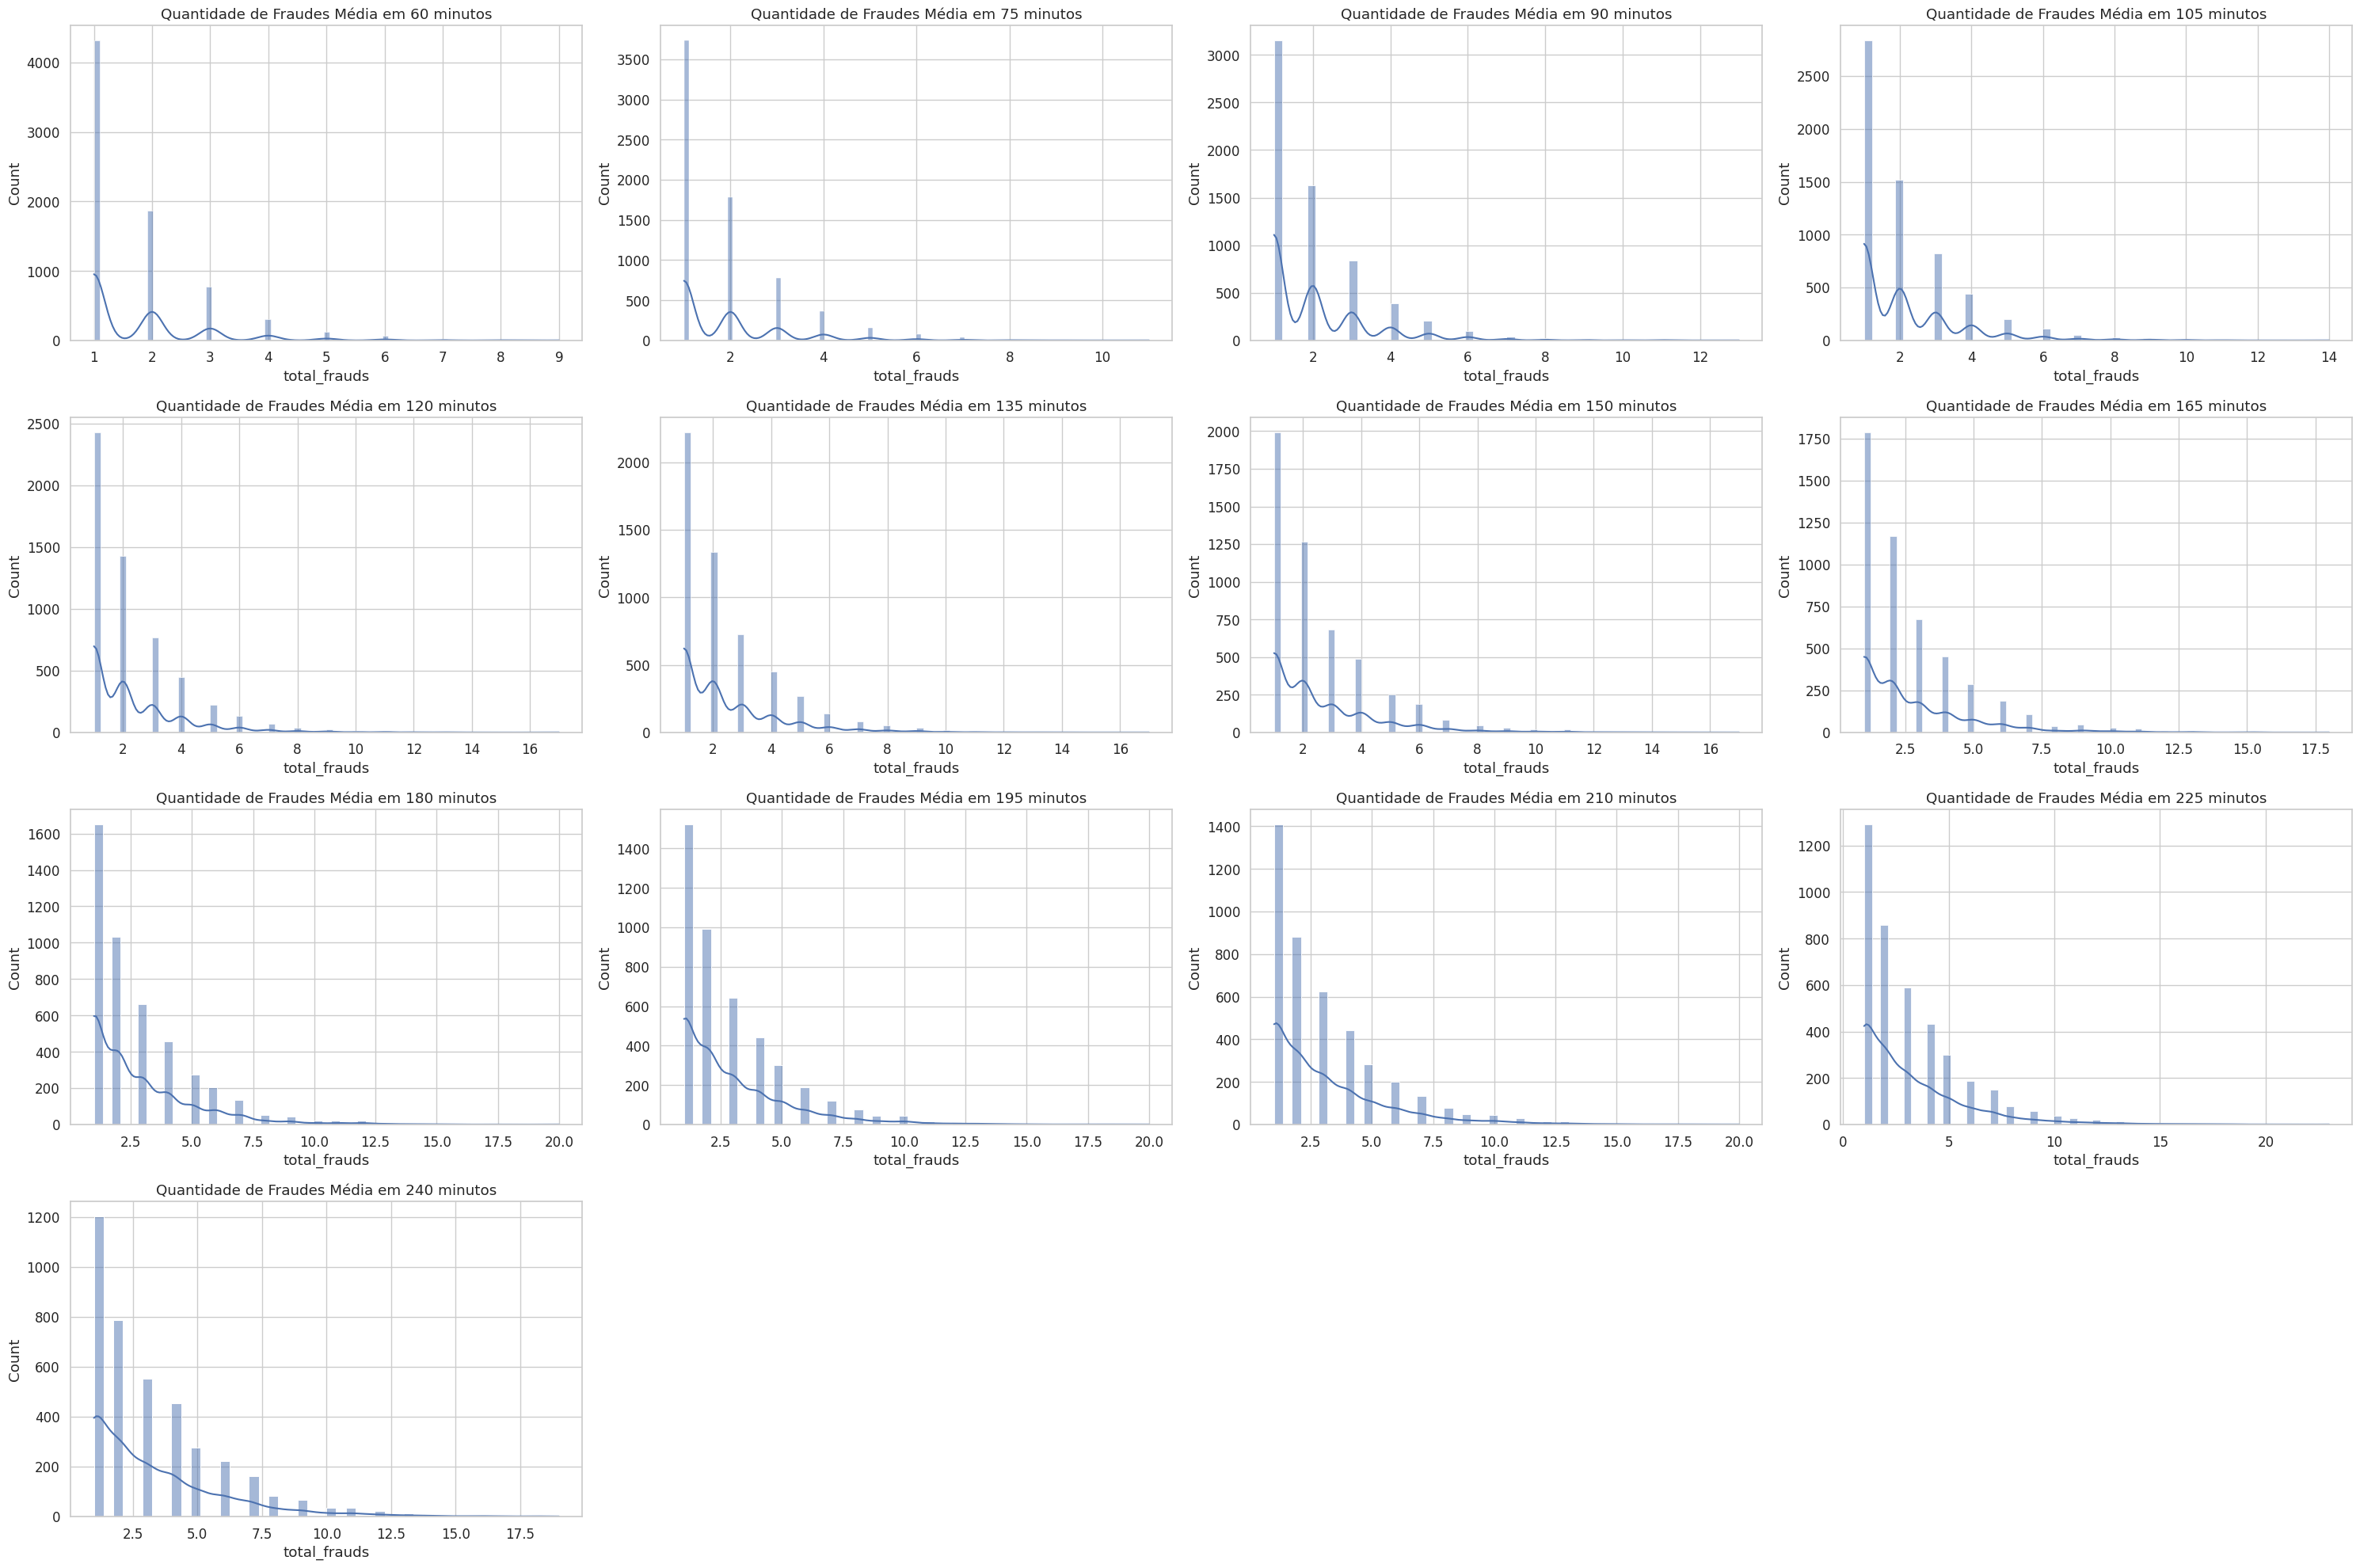

In [48]:
minutes = [60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210, 225, 240]#[120, 240, 360, 480, 600, 720, 840, 960, 1080, 1200, 1320, 1440]
df_time = df.to_pandas()

# Define número de colunas
cols = 4
# Calcula número de linhas necessárias
rows = math.ceil(len(minutes) / cols)

plt.figure(figsize=(30, 5 * rows))

for i, minute in enumerate(minutes):
    plt.subplot(rows, cols, i + 1)
    plt.title(f'Quantidade de Fraudes Média em {minute} minutos')

    df_minutes = pd.DataFrame()
    df_minutes['slide_date'] = df_time['date'].dt.floor(f'{minute}T')
    df_minutes['target'] = df_time['target']

    df_minutes = df_minutes.groupby(by='slide_date').agg({'target': 'sum'}).reset_index()
    df_minutes.columns = ['slide_date', 'total_frauds']

    sns.histplot(df_minutes.query('total_frauds > 0')['total_frauds'], kde=True)

plt.tight_layout()
plt.show()

### Validação com modelos dummies

In [49]:
%%time

builders = []

for minute in tqdm(minutes, desc='Validando periodos'):

  feature_engineering = FraudFeatureEngineer(freq=f'{minute}T')
  df_train = feature_engineering.engineer_features(df.to_pandas(), debug=False)

  builder = BaselineCountingModel(df_train, f'{minute}m', offset=df_train['duration_sec'])
  builder.train()
  builders.append(builder)

Validando periodos:   0%|          | 0/13 [00:00<?, ?it/s]

CPU times: user 17min 14s, sys: 3min 31s, total: 20min 46s
Wall time: 14min 2s


In [50]:
df_report = pd.concat(list(map(lambda x: x.get_report(), builders)))
df_report.sort_values(by=['LLF'], inplace=True, ascending=False)
df_report.reset_index(drop=True, inplace=True)
df_report

,window,model_name,LLF,BIC,AIC,Converged,RMSE_Pearson,Outliers,Pct_resid_gt_2,Pct_resid_gt_3,Dispersion,df_resid,PseudoR2,RankApplied,Best
0,240m,Binomial Negativa,-18326.590286,36673.136556,36657.180572,True,0.857834,934.0,4.334710,2.028125,0.735913,21546.0,6.186252e-11,True,True
1,225m,Binomial Negativa,-18891.977825,37804.040669,37787.955649,True,0.877541,896.0,3.898534,1.783927,0.770112,22982.0,4.751788e-11,True,True
2,240m,ZIP,-19060.382600,38140.721184,38124.765200,True,1.156497,1389.0,6.446373,4.334710,1.337548,21546.0,8.270551e-11,True,False
3,210m,ZINB,-19337.554004,38705.442560,38681.108008,True,0.995946,1317.0,5.348223,2.469036,0.991949,24624.0,-2.775979e-11,True,True
4,210m,Binomial Negativa,-19515.557687,39051.338409,39035.115374,True,0.870370,872.0,3.541117,2.469036,0.757575,24624.0,6.635414e-11,True,False
5,225m,ZIP,-19747.565201,39515.215423,39499.130402,True,1.171376,1327.0,5.773833,3.898534,1.372181,22982.0,-1.907301e-10,True,False
6,210m,ZIP,-20191.755406,40403.733847,40387.510812,True,1.149759,1317.0,5.348223,3.541117,1.321999,24624.0,2.914380e-11,True,False
7,195m,Binomial Negativa,-20303.753591,40627.878416,40611.507183,True,0.887667,1281.0,4.830499,1.987254,0.787982,26518.0,6.009049e-11,True,True
8,180m,ZINB,-20998.811182,42028.419351,42003.622363,True,0.995793,1249.0,4.347523,2.760277,0.991639,28728.0,-3.068861e-10,True,True
9,195m,ZIP,-21050.007274,42120.385782,42104.014548,True,1.155289,1917.0,7.228779,3.084581,1.334742,26518.0,6.098733e-11,True,False


In [51]:
df_best_report = df_report.query('Best == True').groupby(by='model_name').agg(window_count=('window', 'count'), bic=('BIC', 'min')).reset_index().sort_values('window_count', ascending=False).reset_index(drop=True)
df_best_report

,model_name,window_count,bic
0,Poisson,8,-912492.977550
1,Binomial Negativa,3,36673.136556
2,ZINB,2,38705.442560


In [52]:
df_best_report_index = df_report[(df_report['Best'] == True) & (df_report['model_name'] == df_best_report.loc[0, 'model_name'])].sort_values('BIC', ascending=True).reset_index(drop=True)
df_best_report_index

,window,model_name,LLF,BIC,AIC,Converged,RMSE_Pearson,Outliers,Pct_resid_gt_2,Pct_resid_gt_3,Dispersion,df_resid,PseudoR2,RankApplied,Best
0,60m,Poisson,-42271.186416,-912492.977550,84544.372832,True,1.503266,7485.0,8.684806,3.672333,2.259836,86184.0,0.000000e+00,True,True
1,75m,Poisson,-40100.996042,-704690.843946,80203.992083,True,1.572771,3230.0,4.684690,4.684690,2.473646,68947.0,2.220446e-16,True,True
2,90m,Poisson,-38582.582516,-568265.060757,77167.165033,True,1.661930,3254.0,5.663366,5.663366,2.762058,57456.0,0.000000e+00,True,True
3,105m,Poisson,-37234.900853,-472707.687504,74471.801706,True,1.724964,3220.0,6.538204,6.538204,2.975560,49248.0,0.000000e+00,True,True
4,120m,Poisson,-36279.864649,-401620.478195,72561.729298,True,1.820367,3183.0,7.386350,7.386350,3.313813,43092.0,6.661338e-16,True,True
5,135m,Poisson,-35201.203248,-347710.030175,70404.406496,True,1.857705,3137.0,8.189531,4.696515,3.451160,38304.0,3.330669e-16,True,True
6,150m,Poisson,-34358.090719,-304833.592696,68718.181437,True,1.912837,3097.0,8.983582,5.311249,3.659053,34473.0,0.000000e+00,True,True
7,165m,Poisson,-33704.587709,-269883.584062,67411.175417,True,1.976458,3011.0,9.607530,6.043395,3.906511,31339.0,4.440892e-16,True,True


### Seleção da melhor janela de tempo

In [53]:
selected_builder = list(filter(lambda x: x.window == df_best_report_index.loc[0, 'window'], builders))[0]
selected_builder.get_report(criterion='BIC')

,window,model_name,LLF,BIC,AIC,Converged,RMSE_Pearson,Outliers,Pct_resid_gt_2,Pct_resid_gt_3,Dispersion,df_resid,PseudoR2,RankApplied,Best
0,60m,Poisson,-42271.186416,-912492.977550,84544.372832,True,1.503266,7485,8.684806,3.672333,2.259836,86184.0,0.000000e+00,True,True
1,60m,ZINB,-34163.567240,68361.227234,68333.134480,True,1.000176,3165,3.672333,3.672333,1.000363,86184.0,-1.087800e-08,True,False
2,60m,Binomial Negativa,-34246.843793,68516.416089,68497.687586,True,0.952243,3165,3.672333,3.672333,0.906777,86184.0,-2.298322e-10,True,False
3,60m,ZIP,-34379.470489,68781.669481,68762.940979,True,1.050249,3165,3.672333,3.672333,1.103035,86184.0,-2.359528e-10,True,False


#### Visualização da distribuição observada dos eventos X modelo dummy

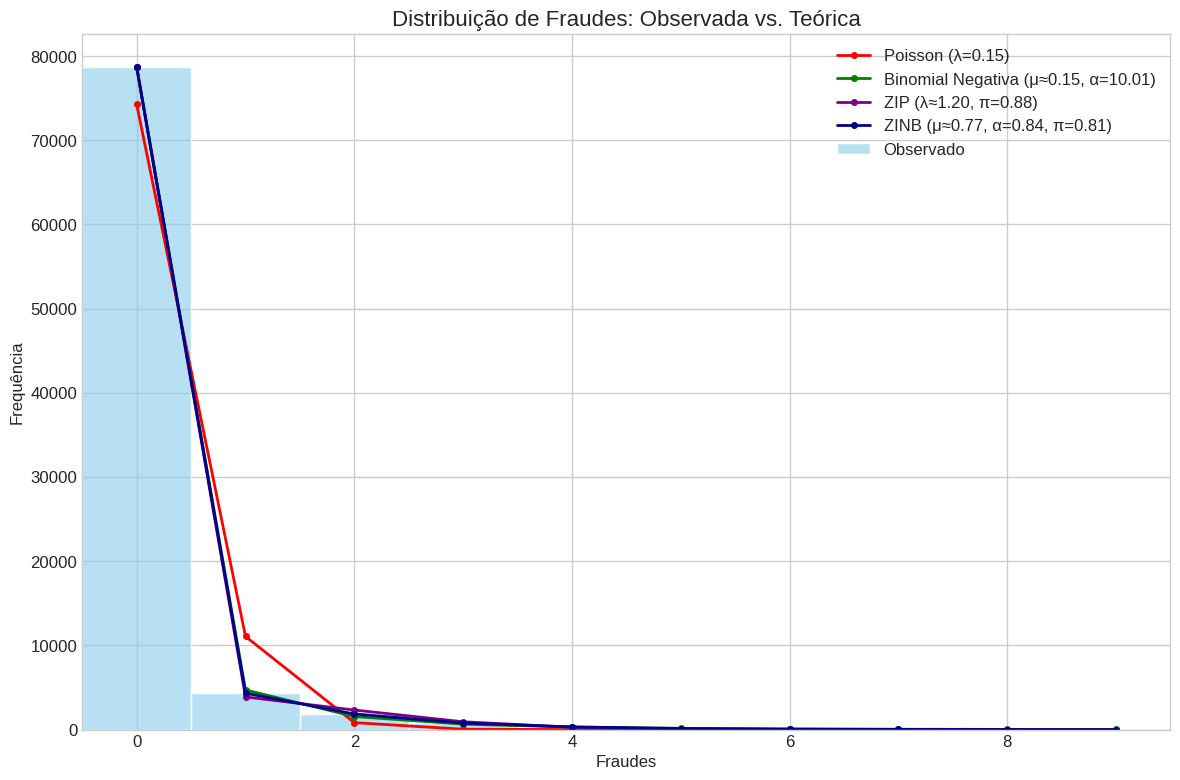

In [54]:
selected_builder.plot_theoretical_distributions()

In [55]:
selected_builder.df.head()

,total_transactions,total_amount,chip_ratio,duration_sec,transactions_per_seconds,avg_transactions_value,geo_dispersion,merchant_entropy,avg_credit_score,error_ratio,...,hour_cos,day_sin,day_cos,is_holiday,change_volume_transaction,velocity_alert,unique_clients,unique_cards,cards_per_client,frauds
2010-01-01 00:00:00,24.0,764.07,0.0,3600.0,0.006667,31.836250,23.862712,2.773718,735.416667,0.0,...,1.000000,-0.433884,-0.900969,1,0.000000,0,22.0,23.0,1.045455,0.0
2010-01-01 01:00:00,21.0,1141.25,0.0,3600.0,0.005833,54.345238,21.905780,2.912494,737.000000,0.0,...,0.965926,-0.433884,-0.900969,1,-0.125000,0,19.0,20.0,1.052632,0.0
2010-01-01 02:00:00,25.0,1028.01,0.0,3600.0,0.006944,41.120400,27.195229,3.107972,726.120000,0.0,...,0.866025,-0.433884,-0.900969,1,0.190476,0,25.0,25.0,1.000000,0.0
2010-01-01 03:00:00,20.0,861.65,0.0,3600.0,0.005556,43.082500,17.409498,2.926418,716.600000,0.0,...,0.707107,-0.433884,-0.900969,1,-0.200000,0,19.0,19.0,1.000000,0.0
2010-01-01 04:00:00,16.0,598.12,0.0,3600.0,0.004444,37.382500,19.956495,2.772589,678.375000,0.0,...,0.500000,-0.433884,-0.900969,1,-0.200000,0,16.0,16.0,1.000000,0.0


In [56]:
selected_builder.df.describe()

,total_transactions,total_amount,chip_ratio,duration_sec,transactions_per_seconds,avg_transactions_value,geo_dispersion,merchant_entropy,avg_credit_score,error_ratio,...,hour_cos,day_sin,day_cos,is_holiday,change_volume_transaction,velocity_alert,unique_clients,unique_cards,cards_per_client,frauds
count,86185.000000,86185.000000,86185.000000,86185.0,86185.000000,86185.000000,86185.000000,86185.000000,86185.000000,86185.000000,...,8.618500e+04,86185.000000,86185.000000,86185.000000,8.618500e+04,86185.000000,86185.000000,86185.000000,86185.000000,86185.000000
mean,98.302605,4968.652653,0.342922,3600.0,0.027306,54.571392,21.168373,3.810124,714.362689,0.016346,...,1.160295e-05,-0.000005,-0.000010,0.027012,inf,0.000104,87.654453,91.531879,1.036567,0.149005
std,58.856132,2769.834769,0.352127,0.0,0.016349,19.311455,2.123850,0.587096,9.429410,0.018206,...,7.071150e-01,0.707108,0.707113,0.162118,NaN,0.010218,50.858006,53.840308,0.033990,0.580282
min,0.000000,0.000000,0.000000,3600.0,0.000000,12.864615,0.000000,0.000000,651.000000,0.000000,...,-1.000000e+00,-0.974928,-0.900969,0.000000,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,2059.280000,0.000000,3600.0,0.008611,44.673154,20.042187,3.249127,708.826531,0.000000,...,-7.071068e-01,-0.781831,-0.900969,0.000000,-1.361257e-01,0.000000,29.000000,30.000000,1.014493,0.000000
50%,90.000000,5114.430000,0.000000,3600.0,0.025000,52.698500,21.074632,4.054709,714.397727,0.012579,...,6.123234e-17,0.000000,-0.222521,0.000000,-1.052632e-02,0.000000,82.000000,84.000000,1.038095,0.000000
75%,155.000000,7158.240000,0.703030,3600.0,0.043056,60.985233,22.128983,4.244109,719.666667,0.024691,...,7.071068e-01,0.781831,0.623490,0.000000,1.250000e-01,0.000000,136.000000,143.000000,1.054795,0.000000
max,236.000000,15886.490000,1.000000,3600.0,0.065556,1501.560000,36.481211,4.752355,788.000000,0.250000,...,1.000000e+00,0.974928,1.000000,1.000000,inf,1.000000,198.000000,213.000000,1.250000,9.000000


#### Correlação dos dados no dataframe da janela selecionada

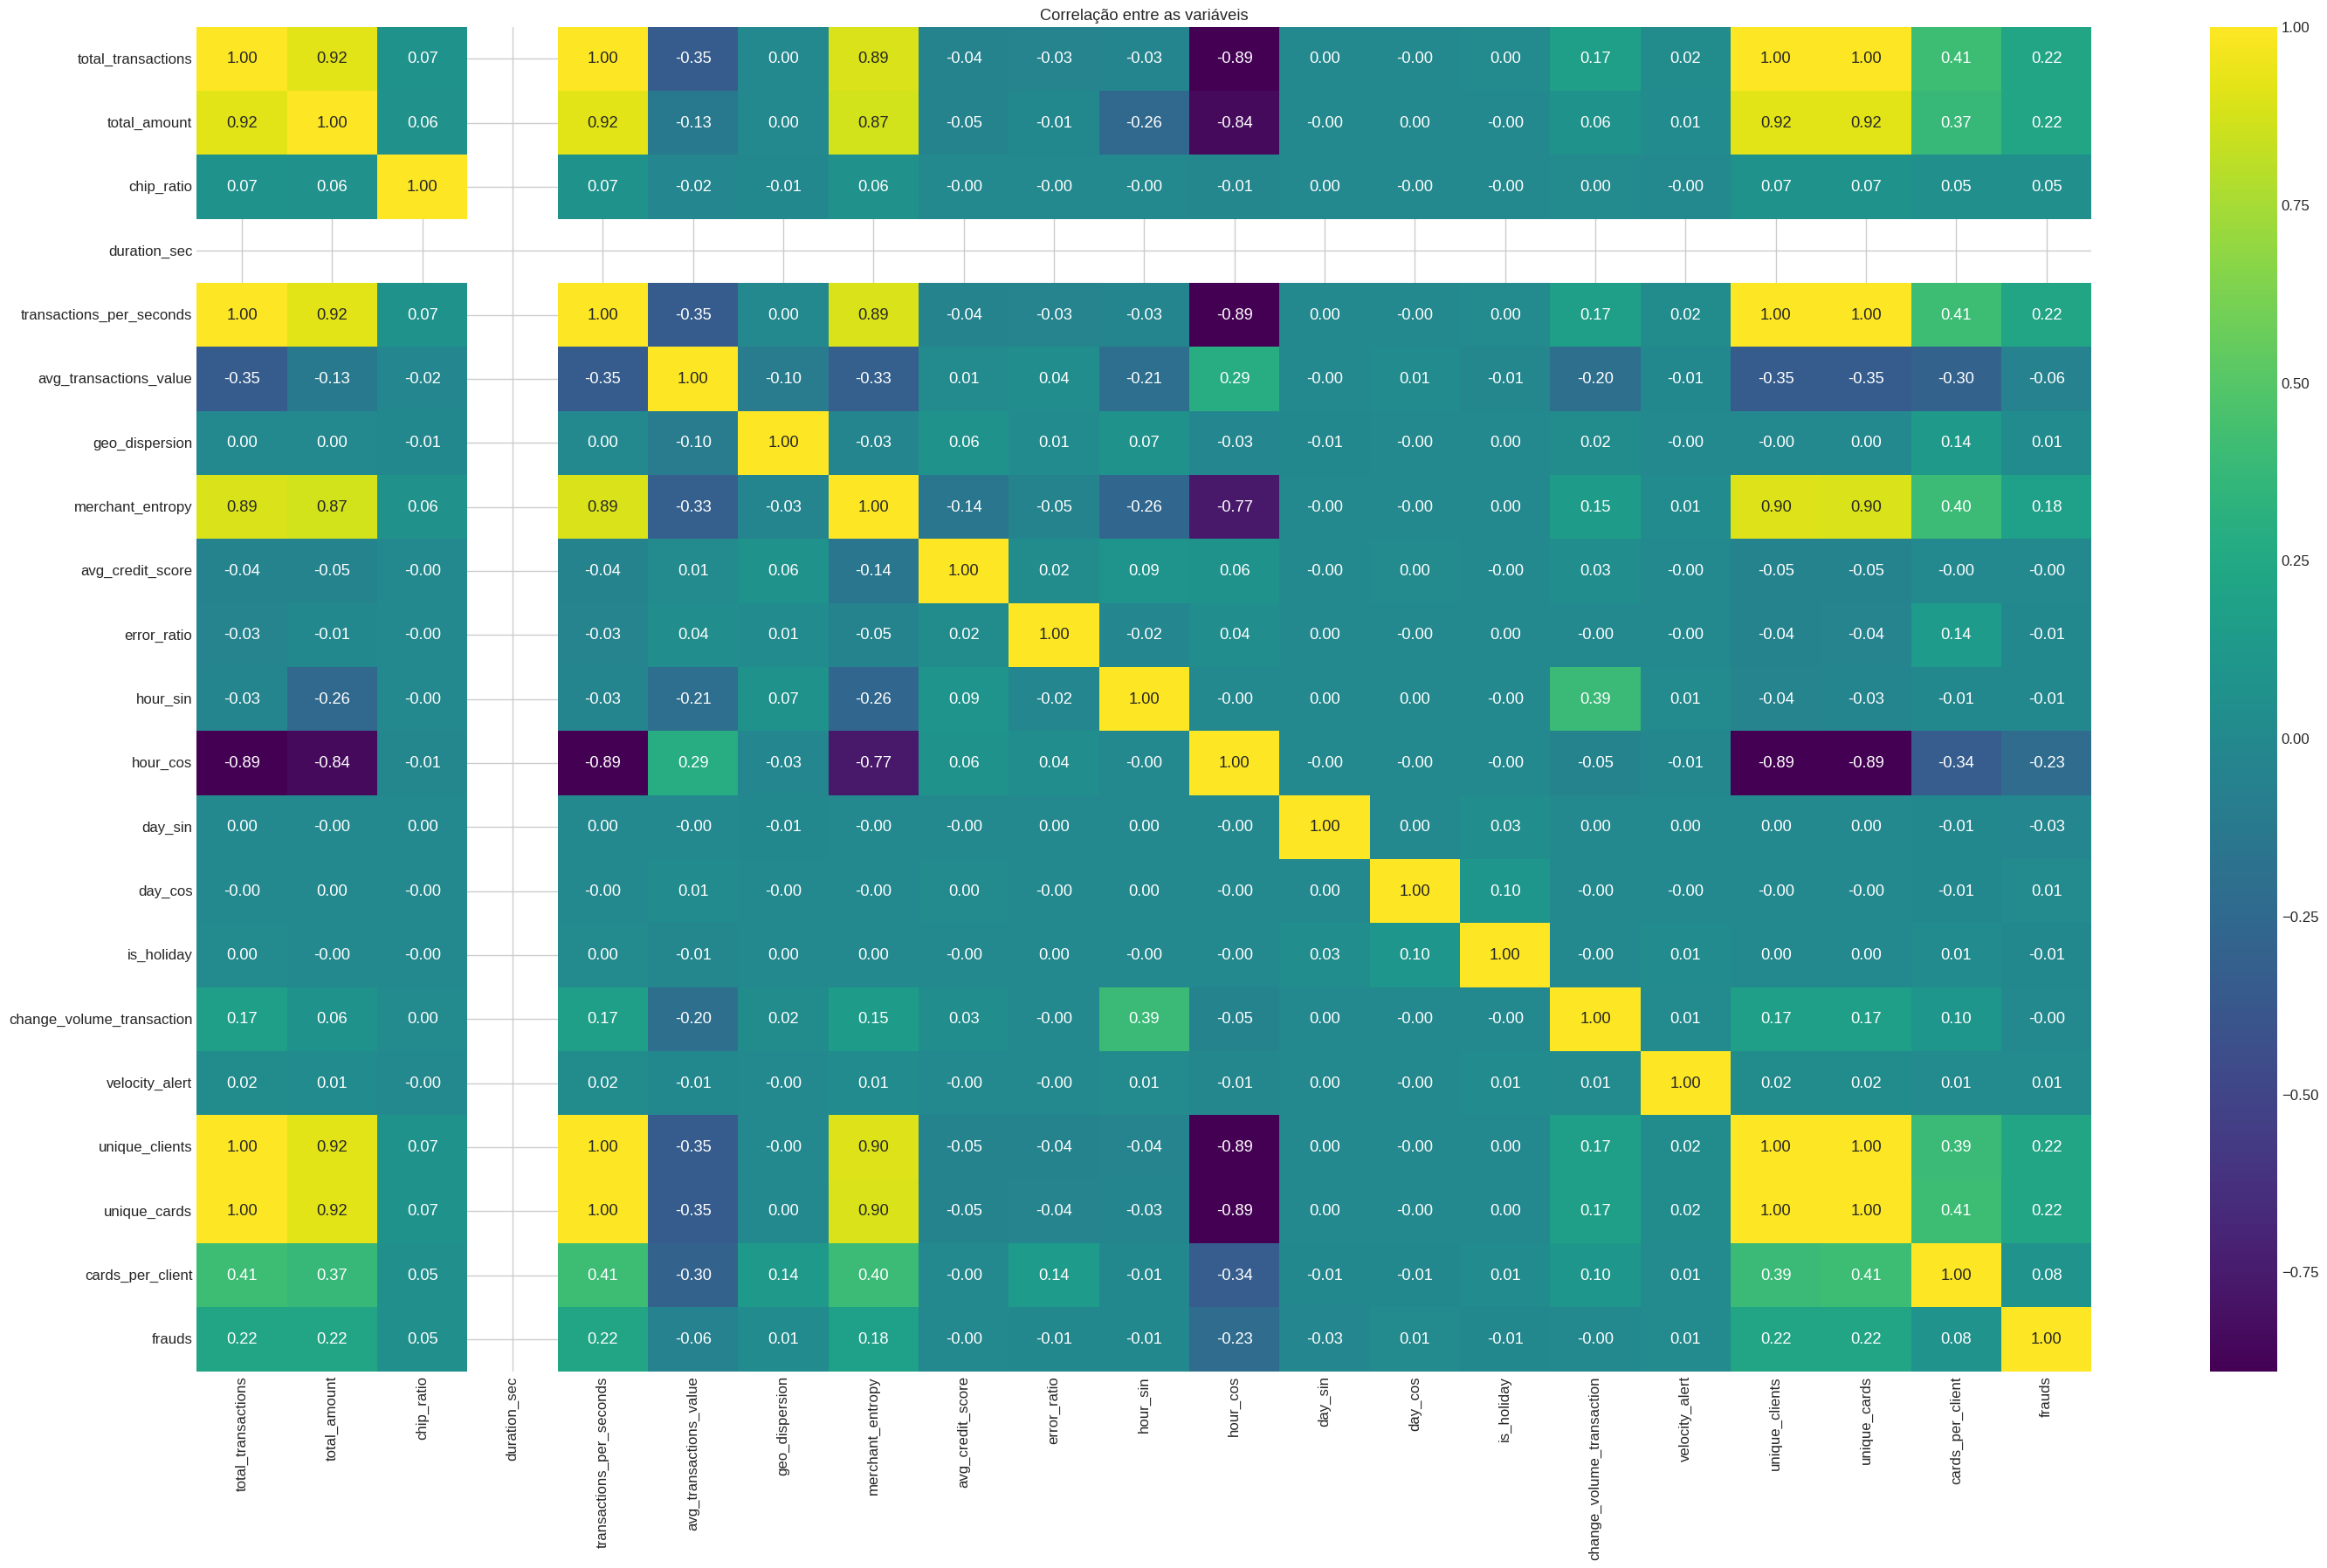

In [57]:
corr = selected_builder.df.corr(numeric_only=True)
plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

##### Remoção de colunas com alta correlação

In [64]:
remove_columns = remove_highly_correlated_features(selected_builder.df, 0.85)
# remove_columns.pop(remove_columns.index('hour_cos'))
remove_columns.append('change_volume_transaction')
remove_columns

['merchant_entropy',
 'unique_cards',
 'transactions_per_seconds',
 'total_transactions',
 'unique_clients',
 'change_volume_transaction']

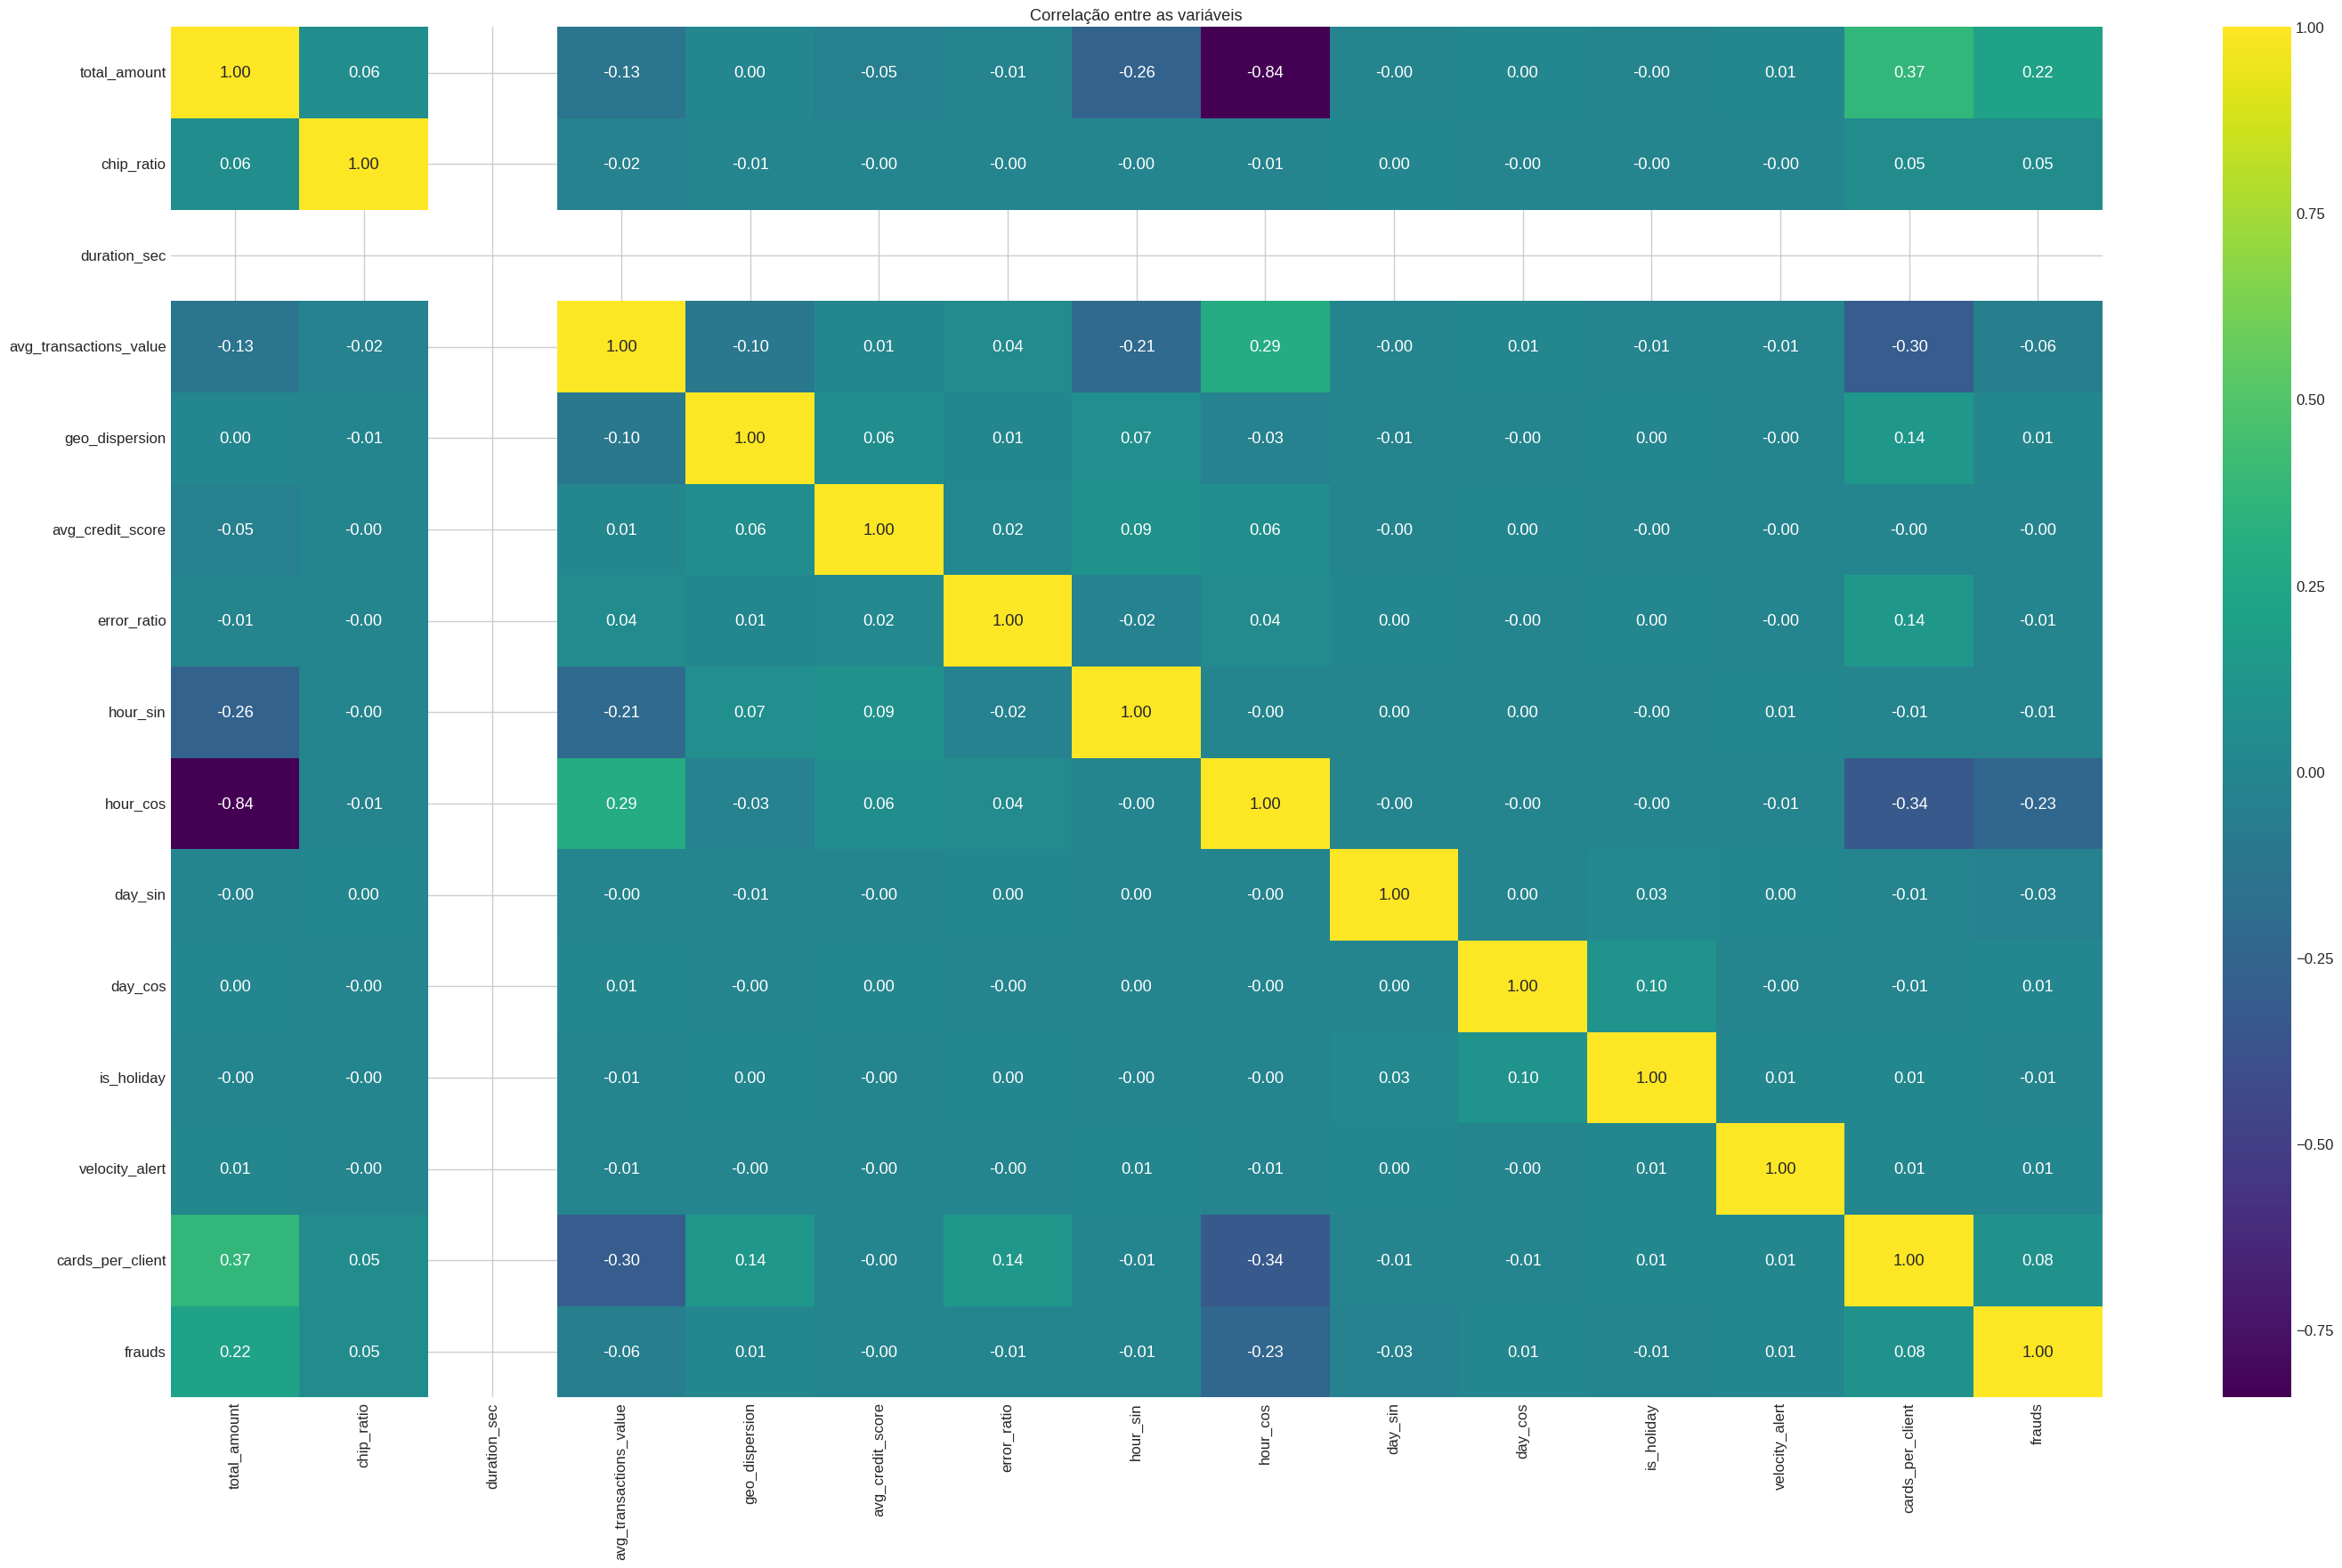

In [65]:
corr = selected_builder.df.drop(columns=remove_columns).corr(numeric_only=True)
plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

## Modelagem

### **Métricas de Avaliação de Modelos: LLF, AIC e BIC**

Estas métricas são usadas para avaliar e comparar modelos estatísticos, buscando um equilíbrio entre o bom ajuste aos dados e a simplicidade do modelo.

---

### **1. LLF (Log-Likelihood Function / Função de Log-Verossimilhança)**

Mede o quão bem o modelo se ajusta aos dados observados.

* **Foco:** Apenas na qualidade do ajuste.
* **Interpretação:** Quanto **maior** o valor, melhor o modelo explica os dados.
* **Limitação:** Não penaliza a complexidade. Modelos mais complexos quase sempre terão uma LLF maior.

---

### **2. AIC (Akaike Information Criterion / Critério de Informação de Akaike)**

Busca um equilíbrio entre a qualidade do ajuste (LLF) e a complexidade do modelo (número de parâmetros).

* **Fórmula:** $$\text{AIC} = 2k - 2 \ln(\hat{L})$$
  * $k$: número de parâmetros do modelo.
  * $\ln(\hat{L})$: valor da Log-Verossimilhança.
* **Foco:** Encontrar o melhor modelo para previsões.
* **Interpretação:** O modelo com o **menor** valor de AIC é preferível.

---

### **3. BIC (Bayesian Information Criterion / Critério de Informação Bayesiano)**

Similar ao AIC, mas aplica uma penalidade mais rigorosa à complexidade, especialmente para grandes volumes de dados.

* **Fórmula:**
    $$ \text{BIC} = \ln(n)k - 2 \ln(\hat{L}) $$
    * $n$: número de observações (tamanho da amostra).
    * $k$: número de parâmetros do modelo.
    * $\ln(\hat{L})$: valor da Log-Verossimilhança.
* **Foco:** Encontrar o modelo mais provável de ser o "verdadeiro" gerador dos dados.
* **Interpretação:** O modelo com o **menor** valor de BIC é preferível. Geralmente, seleciona modelos mais simples que o AIC.

---

### **Tabela Resumo**

| Métrica | Foco Principal | Interpretação |
| :--- | :--- | :--- |
| **LLF** | Qualidade do ajuste | Quanto **maior**, melhor |
| **AIC** | Equilíbrio (Ajuste vs. Complexidade) | Quanto **menor**, melhor |
| **BIC** | Equilíbrio (com maior penalidade à complexidade) | Quanto **menor**, melhor |

In [66]:
X = selected_builder.df.drop(columns=remove_columns).dropna().copy() #selected_builder.df.copy()
y = X['frauds']

In [67]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
total_amount,86185.0,4.968653e+03,2769.834769,0.000000,2059.280000,5.114430e+03,7158.240000,15886.490000
chip_ratio,86185.0,3.429223e-01,0.352127,0.000000,0.000000,0.000000e+00,0.703030,1.000000
duration_sec,86185.0,3.600000e+03,0.000000,3600.000000,3600.000000,3.600000e+03,3600.000000,3600.000000
avg_transactions_value,86185.0,5.457139e+01,19.311455,12.864615,44.673154,5.269850e+01,60.985233,1501.560000
geo_dispersion,86185.0,2.116837e+01,2.123850,0.000000,20.042187,2.107463e+01,22.128983,36.481211
avg_credit_score,86185.0,7.143627e+02,9.429410,651.000000,708.826531,7.143977e+02,719.666667,788.000000
error_ratio,86185.0,1.634579e-02,0.018206,0.000000,0.000000,1.257862e-02,0.024691,0.250000
hour_sin,86185.0,-1.846743e-17,0.707107,-1.000000,-0.707107,0.000000e+00,0.707107,1.000000
hour_cos,86185.0,1.160295e-05,0.707115,-1.000000,-0.707107,6.123234e-17,0.707107,1.000000
day_sin,86185.0,-5.034330e-06,0.707108,-0.974928,-0.781831,0.000000e+00,0.781831,0.974928


In [68]:
y.value_counts()

,count
frauds,
0.0,78700
1.0,4320
2.0,1865
3.0,776
4.0,309
5.0,119
6.0,61
7.0,18
8.0,12


### Modelo de Regressão de Poisson  

Um GLM para Modelagem de Dados de Contagem

A **Regressão de Poisson** é um modelo da família dos **Modelos Lineares Generalizados (GLMs)**, apropriado para variáveis dependentes representadas por **contagens**, ou seja, números inteiros não negativos que expressam a quantidade de vezes que um determinado evento ocorre dentro de um intervalo fixo de tempo ou espaço.

---

### Estrutura dos Dados

Variáveis de contagem apresentam as seguintes características:

- Assumem valores inteiros e não negativos: $0, 1, 2, \dots$.
- Representam frequências de ocorrência de um evento.
- Apresentam, sob hipótese da Poisson, **média e variância iguais**: $\mathbb{E}[Y] = \mathrm{Var}(Y) = \lambda$.

---

### Distribuição de Poisson

A variável aleatória $Y$ segue uma distribuição de Poisson quando sua probabilidade de assumir o valor $k$ é dada por:

$$
P(Y = k) = \frac{\lambda^k e^{-\lambda}}{k!}, \quad k = 0, 1, 2, \dots
$$

onde:

- $\lambda > 0$ é o parâmetro da distribuição, que representa a média e a variância;
- $e$ é a base do logaritmo natural;
- $k!$ é o fatorial de $k$.

---

### Formulação da Regressão de Poisson

A regressão de Poisson modela o valor esperado da variável dependente $Y_i$ como uma função exponencial de uma combinação linear de variáveis explicativas.

Assume-se que:

$$
Y_i \sim \text{Poisson}(\lambda_i)
$$

com:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, de forma vetorial:

$$
\log(\lambda_i) = x_i^\top \beta
$$

Assim, a média condicional esperada da variável resposta é dada por:

$$
\lambda_i = \exp(x_i^\top \beta)
$$

---

### Propriedade de Equidispersão

No modelo de Poisson, assume-se que:

$$
\mathrm{Var}(Y_i) = \mathbb{E}[Y_i] = \lambda_i
$$

Esse equilíbrio entre média e variância é conhecido como **equidispersão**. Caso essa condição não seja atendida (por exemplo, se a variância for significativamente maior que a média), o modelo torna-se inadequado e pode exigir alternativas como o modelo **binomial negativo**.

---

### Interpretação dos Coeficientes

Os coeficientes $\beta_j$ da regressão de Poisson são interpretados em termos da **razão de taxas**. O modelo log-linear define:

$$
\log(\lambda_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Portanto, exponenciando $\beta_j$:

$$
e^{\beta_j}
$$

representa o fator pelo qual a taxa esperada de ocorrência $\lambda_i$ é multiplicada a cada aumento unitário em $x_{ij}$, mantendo constantes os demais preditores.

---

### Estimação

A estimação dos parâmetros do modelo é realizada por **máxima verossimilhança**, considerando a função de verossimilhança derivada da distribuição de Poisson. A convergência do modelo depende da estrutura dos dados e da ausência de sobredispersão relevante.


#### Validação de presuposto

Os dados devem apresentar **equidispersão**, ou seja, média igual a variância.

In [69]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

,Média,Variância
0,0.149005,0.336727


Existe uma diferença muito grande entre a média e a variancia referente a variável alvo, indicando possível subdispersão nos dados.

#### Implementação dos modelos

##### Completo

In [70]:
formula = "frauds ~ " + ' + '.join(X.drop(columns=['frauds', 'duration_sec']).columns)
formula

'frauds ~ total_amount + chip_ratio + avg_transactions_value + geo_dispersion + avg_credit_score + error_ratio + hour_sin + hour_cos + day_sin + day_cos + is_holiday + velocity_alert + cards_per_client'

In [71]:
modelo_poisson  = smf.glm(formula=formula, data=X, family=sm.families.Poisson(), offset=np.log(X['duration_sec'])).fit()

In [72]:
modelo_poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86185
Model:                            GLM   Df Residuals:                    86171
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35883.
Date:                Mon, 08 Sep 2025   Deviance:                       54147.
Time:                        02:38:22   Pearson chi2:                 1.54e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1378
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3.7686      1.061     -3.553      0.000      -5.848      -1.690
total_amount               0.0002   8.01e-06     20.299      0.000       0.000       0.000
chip_ratio                 0.4502      0.026     17.516      0.000       0.400       0.501
avg_transactions_value    -0.0112      0.001     -8.305      0.000      -0.014      -0.009
geo_dispersion            -0.0075      0.007     -1.141      0.254      -0.020       0.005
avg_credit_score          -0.0083      0.001     -6.036      0.000      -0.011      -0.006
error_ratio                1.2207      0.760      1.607      0.108      -0.268       2.709
hour_sin                  -0.0320      0.018     -1.808      0.071      -0.067       0.003
hour_cos                  -1.1303      0.033    -33.961      0.000      -1.196      -1.065
day_sin                   -0.1408      0.013    -11.238      0.000      -0.165      -0.116
day_cos                    0.0343      0.013      2.723      0.006       0.010       0.059
is_holiday                -0.1128      0.058     -1.934      0.053      -0.227       0.002
velocity_alert             0.3338      0.448      0.746      0.456      -0.544       1.211
cards_per_client          -1.2052      0.395     -3.051      0.002      -1.979      -0.431
==========================================================================================
"""

In [73]:
overdisp_plot_enhanced(modelo_poisson, 'Poison - Completo')

KeyboardInterrupt: 

Family poisson



# Diagnóstico RQR — Modelo Poisson

**Nível de significância:** _α = 0.050_

## Resumo
| Checagem | Resultado |
|---|:--:|
| Normalidade (RQR ~ N(0,1)) | NOK |
| Média = 0 | NOK |
| Variância = 1 | NOK |
| Independência (Ljung–Box) | NOK |
| Caudas (|r|>2, |r|>3) | NOK |
| Heterocedasticidade (padrão r²~μ) | NOK |
| Dispersão global (φ̂, Pearson) | NOK |


## 1) Normalidade
| Teste | Estatística | p-valor | Resultado |
|---|---:|---:|:--:|
| Shapiro–Wilk | 0.9801 | 5.642e-70 | NOK |
| Jarque–Bera  | 13987.60 | 0.000e+00 | NOK |

## 2) Localização e Escala
| Medida | Valor |
|---|---:|
| Média (E[r]) | -0.028380 |
| Desvio-padrão (SD[r]) | 1.067415 |

| Teste | Hipótese | Estatística | p-valor | Resultado |
|---|---|---:|---:|:--:|
| t (média=0) | H₀: E[r]=0 | -7.805 | 6.003e-15 | NOK |
| χ² (var=1) | H₀: Var[r]=1 | 98195.88 | 0.000e+00 | NOK |

## 3) Independência (Ljung–Box)
| Estatística Q | p-valor | Resultado |
|---:|---:|:--:|
| 7133.446 | 0.000e+00 | NOK |

## 4) Heterocedasticidade (padrão r² ~ μ)
| Coef. de μ | t | p-valor | Resultado |
|---:|---:|---:|:--:|
| 0.983108 | 17.342 | 2.253e-67 | NOK |

## 5) Dispersão Global (Escala)
| Estatística | df | φ̂ | p(two-sided) | Resultado | Observação |
|---:|---:|---:|---:|:--:|---|
| 153801.94 | 86171 | 1.7848 | 0.000e+00 | NOK | Superdispersão (φ̂>1) |

## 6) Caudas (|r|>2, |r|>3)
Esperado em N(0,1): P(|r|>2)≈4.55%, P(|r|>3)≈0.27%

| Regra | Contagem observada | p-valor binomial | Resultado |
|---|---:|---:|:--:|
| |r| > 2 | 5140 | 7.083e-81 | NOK |
| |r| > 3 | 1127 | 0.000e+00 | NOK |

---
### Interpretação rápida
- Normalidade: NOK; Média/Variância: NOK; Independência: NOK; Caudas: NOK.
- Heterocedasticidade (r²~μ): NOK.
- Dispersão global: NOK (Superdispersão (φ̂>1)).


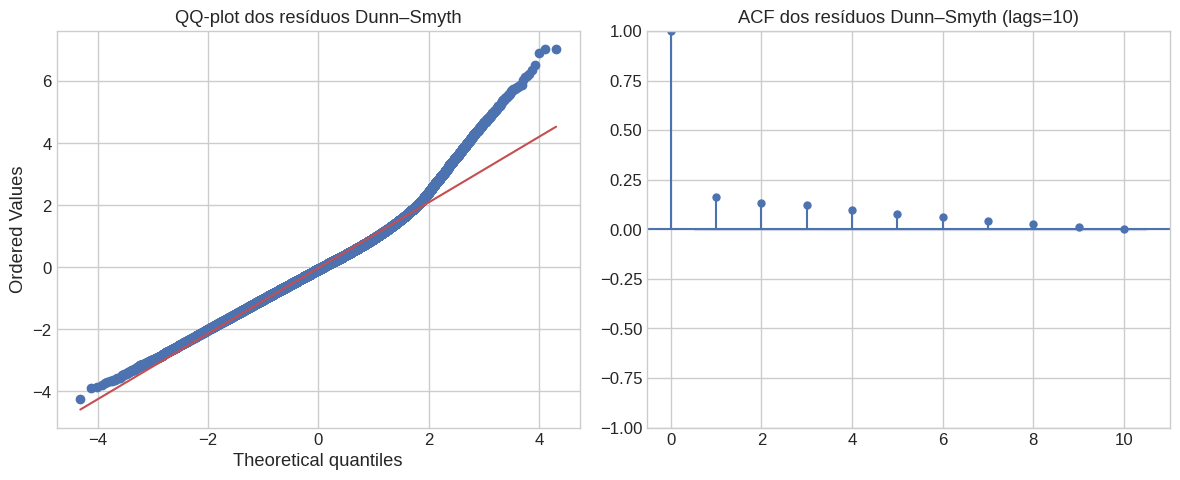

In [74]:
rqr = compute_rqr(modelo_poisson, y, family='auto', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_poisson),
    resid_pearson=modelo_poisson.resid_pearson,
    df_resid=modelo_poisson.df_resid,
    lags=20,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagnóstico RQR — Modelo Poisson",
    alpha=0.05,
    acf_lags=10
)

O gráfico indica que o modelo Poisson tem dificuldade em capturar a variabilidade: observa-se um forte “funil”, violando o pressuposto de equidispersão (resíduos com variância crescente). A suavização é nitidamente descendente, sinal de viés: o modelo tende a superestimar para μ altos e subestimar quando μ é baixo. Há muitos resíduos |r|>2, especialmente em μ<3, sugerindo heterogeneidade/zeros não explicados.

In [75]:
overdisp(modelo_poisson, X)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.007      
Dependent Variable:     ystar            AIC:                         623496.2266
Date:                   2025-09-08 02:39 BIC:                         623505.5908
No. Observations:       86185            Log-Likelihood:              -3.1175e+05
Df Model:               1                F-statistic:                 626.6      
Df Residuals:           86184            Prob (F-statistic):          8.38e-138  
R-squared (uncentered): 0.007            Scale:                       81.167     
---------------------------------------------------------------------------------------
             Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda        3.6043         0.1440       25.0328       0.0000       3.3221    

O teste evidencia o ponto já validado inicialmente do presuposto. O modelo não atende a capacidade de overdispersion.

##### Stepwise

In [76]:
modelo_poisson_stepwise = stepwise(modelo_poisson, pvalue_limit=0.05)
modelo_poisson_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('chip_ratio') + Q('avg_transactions_value') + Q('geo_dispersion') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos') + Q('day_sin') + Q('day_cos') + Q('is_holiday') + Q('velocity_alert') + Q('cards_per_client')

 Family type...: 
 Poisson

 Discarding atribute "Q('velocity_alert')" with p-value equal to 0.4559125668609364 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('chip_ratio') + Q('avg_transactions_value') + Q('geo_dispersion') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos') + Q('day_sin') + Q('day_cos') + Q('is_holiday') + Q('cards_per_client')

 Family type...: 
 Poisson

 Discarding atribute "Q('geo_dispersion')" with p-value equal to 0.25122333070659886 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('chip_ratio') + Q('avg_transactions_value') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos') + Q('day_sin') + 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86185
Model:                            GLM   Df Residuals:                    86176
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35888.
Date:                Mon, 08 Sep 2025   Deviance:                       54158.
Time:                        02:39:20   Pearson chi2:                 1.52e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1377
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.1217      1.055      3.905      0.000       2.053       6.190
Q('total_amount')               0.0002   7.96e-06     20.531      0.000       0.000       0.000
Q('chip_ratio')                 0.4501      0.026     17.520      0.000       0.400       0.500
Q('avg_transactions_value')    -0.0100      0.001     -8.508      0.000      -0.012      -0.008
Q('avg_credit_score')          -0.0082      0.001     -5.994      0.000      -0.011      -0.006
Q('hour_cos')                  -1.1272      0.033    -33.992      0.000      -1.192      -1.062
Q('day_sin')                   -0.1414      0.013    -11.282      0.000      -0.166      -0.117
Q('day_cos')                    0.0314      0.012      2.509      0.012       0.007       0.056
Q('cards_per_client')          -1.1900      0.395     -3.014      0.003      -1.964      -0.416
===============================================================================================
"""

In [77]:
overdisp_plot_enhanced(modelo_poisson_stepwise, 'Poison - Stepwise')

KeyboardInterrupt: 

Family poisson



# Diagnóstico RQR — Modelo Poisson Stepwise

**Nível de significância:** _α = 0.050_

## Resumo
| Checagem | Resultado |
|---|:--:|
| Normalidade (RQR ~ N(0,1)) | NOK |
| Média = 0 | NOK |
| Variância = 1 | NOK |
| Independência (Ljung–Box) | NOK |
| Caudas (|r|>2, |r|>3) | NOK |
| Heterocedasticidade (padrão r²~μ) | NOK |
| Dispersão global (φ̂, Pearson) | NOK |


## 1) Normalidade
| Teste | Estatística | p-valor | Resultado |
|---|---:|---:|:--:|
| Shapiro–Wilk | 0.9801 | 6.710e-70 | NOK |
| Jarque–Bera  | 13884.49 | 0.000e+00 | NOK |

## 2) Localização e Escala
| Medida | Valor |
|---|---:|
| Média (E[r]) | -0.028362 |
| Desvio-padrão (SD[r]) | 1.067403 |

| Teste | Hipótese | Estatística | p-valor | Resultado |
|---|---|---:|---:|:--:|
| t (média=0) | H₀: E[r]=0 | -7.800 | 6.236e-15 | NOK |
| χ² (var=1) | H₀: Var[r]=1 | 98193.69 | 0.000e+00 | NOK |

## 3) Independência (Ljung–Box)
| Estatística Q | p-valor | Resultado |
|---:|---:|:--:|
| 7144.388 | 0.000e+00 | NOK |

## 4) Heterocedasticidade (padrão r² ~ μ)
| Coef. de μ | t | p-valor | Resultado |
|---:|---:|---:|:--:|
| 0.984445 | 17.383 | 1.104e-67 | NOK |

## 5) Dispersão Global (Escala)
| Estatística | df | φ̂ | p(two-sided) | Resultado | Observação |
|---:|---:|---:|---:|:--:|---|
| 152091.14 | 86176 | 1.7649 | 0.000e+00 | NOK | Superdispersão (φ̂>1) |

## 6) Caudas (|r|>2, |r|>3)
Esperado em N(0,1): P(|r|>2)≈4.55%, P(|r|>3)≈0.27%

| Regra | Contagem observada | p-valor binomial | Resultado |
|---|---:|---:|:--:|
| |r| > 2 | 5132 | 6.361e-80 | NOK |
| |r| > 3 | 1124 | 0.000e+00 | NOK |

---
### Interpretação rápida
- Normalidade: NOK; Média/Variância: NOK; Independência: NOK; Caudas: NOK.
- Heterocedasticidade (r²~μ): NOK.
- Dispersão global: NOK (Superdispersão (φ̂>1)).


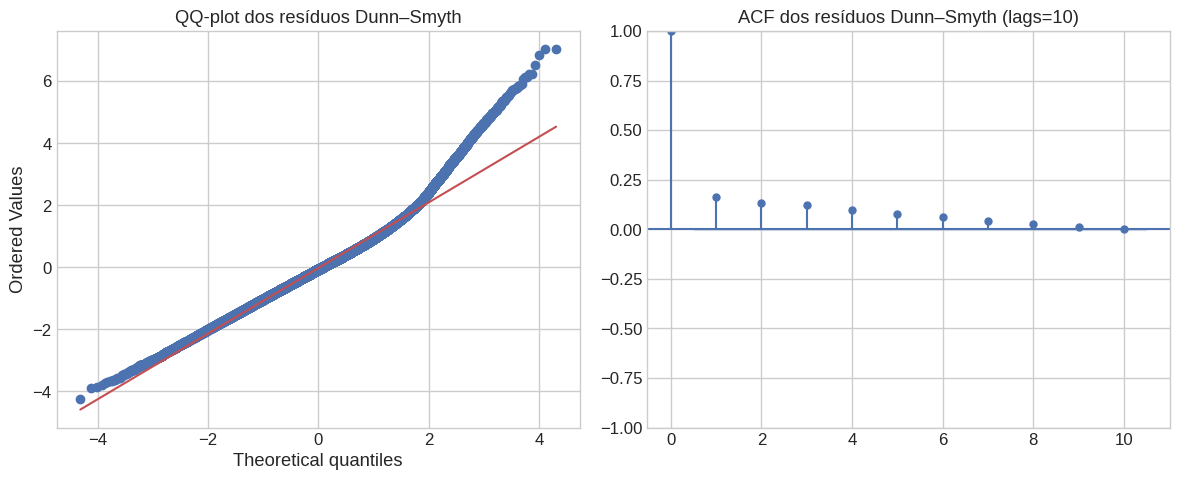

In [78]:
rqr = compute_rqr(modelo_poisson_stepwise, y, family='auto', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_poisson_stepwise),
    resid_pearson=modelo_poisson_stepwise.resid_pearson,
    df_resid=modelo_poisson_stepwise.df_resid,
    lags=20,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagnóstico RQR — Modelo Poisson Stepwise",
    alpha=0.05,
    acf_lags=10
)

O gráfico Poisson com seleção stepwise ainda exibe forte “funil”, indicando violação do pressuposto de equidispersão (variância dos resíduos cresce com μ).
A suavização segue descendente, sugerindo viés: subestima para μ baixos e superestima para μ altos.
Há muitos resíduos |r|>2, sobretudo em μ<3, apontando heterogeneidade/zeros não explicados.
O stepwise pode ter ajustado levemente a média (faixa ~4–7), mas não corrige a sobredispersão.

In [79]:
overdisp(modelo_poisson_stepwise, X)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.008      
Dependent Variable:     ystar            AIC:                         616256.7712
Date:                   2025-09-08 02:39 BIC:                         616266.1355
No. Observations:       86185            Log-Likelihood:              -3.0813e+05
Df Model:               1                F-statistic:                 681.8      
Df Residuals:           86184            Prob (F-statistic):          1.06e-149  
R-squared (uncentered): 0.008            Scale:                       74.627     
---------------------------------------------------------------------------------------
             Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda        3.6038         0.1380       26.1106       0.0000       3.3333    

### Modelo de Regressão Binomial Negativa  

Um GLM para Dados de Contagem com Sobredispersão

A **Regressão Binomial Negativa** é uma extensão do Modelo de Poisson, indicada quando os dados de contagem apresentam **sobredispersão** — ou seja, a variância é significativamente maior que a média. Esse modelo pertence à família dos Modelos Lineares Generalizados (GLMs) e é recomendado quando a suposição de equidispersão da Poisson não é atendida.

---

### Distribuição Binomial Negativa

Na parametrização usada em modelagem de contagem, a variável aleatória $Y$ segue a distribuição:

$$
Y \sim \text{Binomial Negativa}(\mu, \theta)
$$

com média condicional $\mu$ e parâmetro de dispersão $\theta$. A variância assume a forma:

$$
\mathrm{Var}(Y) = \mu + \frac{\mu^2}{\theta}
$$

onde:

- $\mu > 0$ é a média esperada condicional de $Y$;
- $\theta > 0$ é o parâmetro de dispersão, também chamado de "tamanho" ou "alpha";
- Para $\theta \to \infty$, o modelo converge para a Poisson, reduzindo a variância a $\mu$.

---

### Estrutura do Modelo

O objetivo é expressar a média condicional $\mu_i$ da observação $i$ por meio de uma combinação linear dos preditores $x_i$, garantindo positividade com a função de ligação logaritmo:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, compactamente:

$$
\log(\mu_i) = x_i^\top \beta
$$

Portanto, a média esperada é calculada por:

$$
\mu_i = \exp(x_i^\top \beta)
$$

---

### Variância Condicional

A diferença crucial em relação à Poisson está no termo adicional da variância:

$$
\mathrm{Var}(Y_i) = \mu_i + \frac{\mu_i^2}{\theta}
$$

Esse termo permite capturar a sobredispersão observada nos dados, com variância aumentando mais rapidamente do que a média.

---

### Significado dos Coeficientes

Os coeficientes $\beta_j$ mantêm a interpretação em termos de log‑média:

$$
\log(\mu_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Exponenciando $\beta_j$, temos:

$$
e^{\beta_j}
$$

que representa o **fator multiplicativo** na média esperada $\mu_i$ para cada aumento unitário em $x_{ij}$, mantendo os demais preditores constantes.

---

### Estimação por Máxima Verossimilhança

A estimação envolve ajuste simultâneo de $\beta$ e $\theta$ por máxima verossimilhança. A presença do parâmetro extra permite flexibilidade para se adequar a diferentes níveis de dispersão nos dados.


#### Validação de presuposto

Os dados devem apresentar **sobredispersão**, ou seja, variância maior que a média.

In [80]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

,Média,Variância
0,0.149005,0.336727


#### Implementação dos modelos

##### Completo

In [81]:
modelo_binomial = smf.glm(formula=formula, data=X, family=sm.families.NegativeBinomial(), offset=np.log(X['duration_sec'])).fit()
modelo_binomial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86185
Model:                            GLM   Df Residuals:                    86171
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32664.
Date:                Mon, 08 Sep 2025   Deviance:                       39981.
Time:                        02:39:58   Pearson chi2:                 1.30e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1206
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3.8790      1.162     -3.337      0.001      -6.157      -1.601
total_amount               0.0002   8.81e-06     17.094      0.000       0.000       0.000
chip_ratio                 0.4152      0.029     14.373      0.000       0.359       0.472
avg_transactions_value    -0.0090      0.001     -6.292      0.000      -0.012      -0.006
geo_dispersion            -0.0023      0.007     -0.316      0.752      -0.016       0.012
avg_credit_score          -0.0084      0.002     -5.567      0.000      -0.011      -0.005
error_ratio                1.5878      0.830      1.914      0.056      -0.038       3.214
hour_sin                  -0.0231      0.019     -1.212      0.225      -0.061       0.014
hour_cos                  -1.1777      0.036    -32.333      0.000      -1.249      -1.106
day_sin                   -0.1527      0.014    -10.754      0.000      -0.181      -0.125
day_cos                    0.0276      0.014      1.935      0.053      -0.000       0.055
is_holiday                -0.0932      0.065     -1.436      0.151      -0.220       0.034
velocity_alert             0.4061      0.560      0.725      0.468      -0.692       1.504
cards_per_client          -1.1913      0.432     -2.756      0.006      -2.038      -0.344
==========================================================================================
"""

In [82]:
overdisp_plot_enhanced(modelo_binomial, 'Binomial Negativo - Completo')

KeyboardInterrupt: 

Family nb2



# Diagnóstico RQR — Modelo Binomial

**Nível de significância:** _α = 0.050_

## Resumo
| Checagem | Resultado |
|---|:--:|
| Normalidade (RQR ~ N(0,1)) | NOK |
| Média = 0 | NOK |
| Variância = 1 | NOK |
| Independência (Ljung–Box) | NOK |
| Caudas (|r|>2, |r|>3) | NOK |
| Heterocedasticidade (padrão r²~μ) | NOK |
| Dispersão global (φ̂, Pearson) | NOK |


## 1) Normalidade
| Teste | Estatística | p-valor | Resultado |
|---|---:|---:|:--:|
| Shapiro–Wilk | 0.9941 | 2.384e-46 | NOK |
| Jarque–Bera  | 2673.59 | 0.000e+00 | NOK |

## 2) Localização e Escala
| Medida | Valor |
|---|---:|
| Média (E[r]) | -0.026509 |
| Desvio-padrão (SD[r]) | 1.025101 |

| Teste | Hipótese | Estatística | p-valor | Resultado |
|---|---|---:|---:|:--:|
| t (média=0) | H₀: E[r]=0 | -7.592 | 3.187e-14 | NOK |
| χ² (var=1) | H₀: Var[r]=1 | 90564.92 | 0.000e+00 | NOK |

## 3) Independência (Ljung–Box)
| Estatística Q | p-valor | Resultado |
|---:|---:|:--:|
| 5251.173 | 0.000e+00 | NOK |

## 4) Heterocedasticidade (padrão r² ~ μ)
| Coef. de μ | t | p-valor | Resultado |
|---:|---:|---:|:--:|
| 0.296158 | 7.710 | 1.254e-14 | NOK |

## 5) Dispersão Global (Escala)
| Estatística | df | φ̂ | p(two-sided) | Resultado | Observação |
|---:|---:|---:|---:|:--:|---|
| 130475.91 | 86171 | 1.5142 | 0.000e+00 | NOK | Superdispersão (φ̂>1) |

## 6) Caudas (|r|>2, |r|>3)
Esperado em N(0,1): P(|r|>2)≈4.55%, P(|r|>3)≈0.27%

| Regra | Contagem observada | p-valor binomial | Resultado |
|---|---:|---:|:--:|
| |r| > 2 | 4569 | 5.342e-25 | NOK |
| |r| > 3 | 631 | 4.056e-103 | NOK |

---
### Interpretação rápida
- Normalidade: NOK; Média/Variância: NOK; Independência: NOK; Caudas: NOK.
- Heterocedasticidade (r²~μ): NOK.
- Dispersão global: NOK (Superdispersão (φ̂>1)).


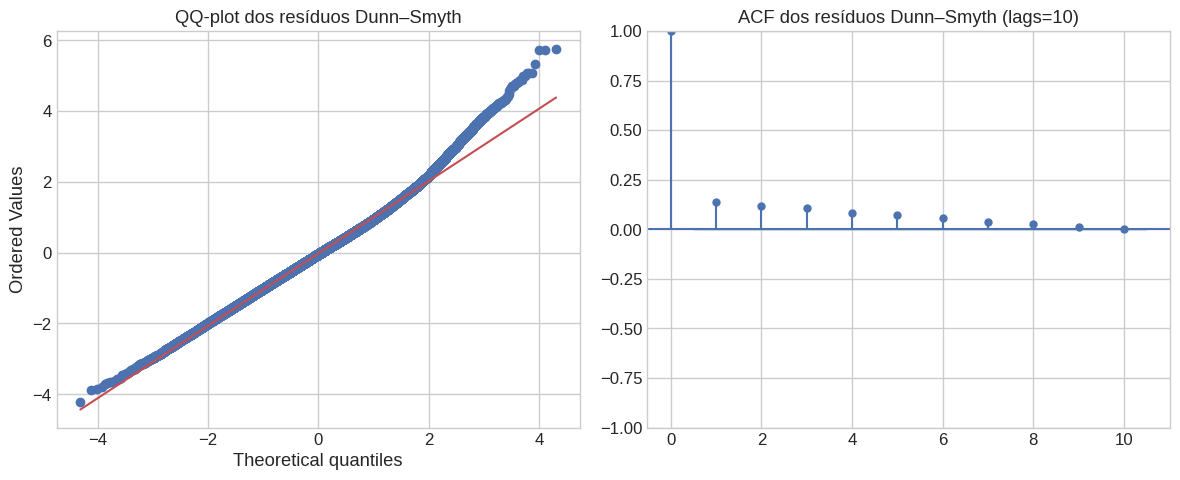

In [84]:
rqr = compute_rqr(modelo_binomial, y, family='nb2', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_binomial),
    resid_pearson=modelo_binomial.resid_pearson,
    df_resid=modelo_binomial.df_resid,
    lags=10,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagnóstico RQR — Modelo Binomial",
    alpha=0.05,
    acf_lags=10
)

O gráfico sugere que, embora a Binomial Negativa atenue a sobredispersão, o padrão de “funil” persiste: a variância dos resíduos cresce quando a média prevista (μ) é baixa. A suavização levemente descendente indica viés (subestima em μ pequenos e tende a superestimar em μ maiores). A maioria dos pontos fica em ±2, mas há outliers positivos concentrados em μ<4, sinalizando heterogeneidade/zeros não explicados. Em suma, o ajuste é melhor que o Poisson, porém ainda insuficiente nas baixas médias.

##### Stepwise

In [85]:
modelo_binomial_stepwise = stepwise(modelo_binomial, pvalue_limit=0.05)
modelo_binomial_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('chip_ratio') + Q('avg_transactions_value') + Q('geo_dispersion') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos') + Q('day_sin') + Q('day_cos') + Q('is_holiday') + Q('velocity_alert') + Q('cards_per_client')

 Family type...: 
 Negative Binomial

 Discarding atribute "Q('geo_dispersion')" with p-value equal to 0.7523313302107473 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('chip_ratio') + Q('avg_transactions_value') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos') + Q('day_sin') + Q('day_cos') + Q('is_holiday') + Q('velocity_alert') + Q('cards_per_client')

 Family type...: 
 Negative Binomial

 Discarding atribute "Q('velocity_alert')" with p-value equal to 0.46726166604506436 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('chip_ratio') + Q('avg_transactions_value') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86185
Model:                            GLM   Df Residuals:                    86177
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32670.
Date:                Mon, 08 Sep 2025   Deviance:                       39992.
Time:                        02:40:40   Pearson chi2:                 1.30e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1205
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.0741      1.159      3.516      0.000       1.803       6.345
Q('total_amount')               0.0002   8.75e-06     17.358      0.000       0.000       0.000
Q('chip_ratio')                 0.4164      0.029     14.419      0.000       0.360       0.473
Q('avg_transactions_value')    -0.0081      0.001     -6.423      0.000      -0.011      -0.006
Q('avg_credit_score')          -0.0083      0.002     -5.508      0.000      -0.011      -0.005
Q('hour_cos')                  -1.1732      0.036    -32.326      0.000      -1.244      -1.102
Q('day_sin')                   -0.1533      0.014    -10.799      0.000      -0.181      -0.125
Q('cards_per_client')          -1.1203      0.429     -2.614      0.009      -1.960      -0.280
===============================================================================================
"""

In [86]:
overdisp_plot_enhanced(modelo_binomial_stepwise, 'Binomial Negativo - Stepwise')

KeyboardInterrupt: 

Family nb2



# Diagnóstico RQR — Modelo Binomial Stepwise

**Nível de significância:** _α = 0.050_

## Resumo
| Checagem | Resultado |
|---|:--:|
| Normalidade (RQR ~ N(0,1)) | NOK |
| Média = 0 | NOK |
| Variância = 1 | NOK |
| Independência (Ljung–Box) | NOK |
| Caudas (|r|>2, |r|>3) | NOK |
| Heterocedasticidade (padrão r²~μ) | NOK |
| Dispersão global (φ̂, Pearson) | NOK |


## 1) Normalidade
| Teste | Estatística | p-valor | Resultado |
|---|---:|---:|:--:|
| Shapiro–Wilk | 0.9941 | 2.797e-46 | NOK |
| Jarque–Bera  | 2657.83 | 0.000e+00 | NOK |

## 2) Localização e Escala
| Medida | Valor |
|---|---:|
| Média (E[r]) | -0.026532 |
| Desvio-padrão (SD[r]) | 1.025084 |

| Teste | Hipótese | Estatística | p-valor | Resultado |
|---|---|---:|---:|:--:|
| t (média=0) | H₀: E[r]=0 | -7.598 | 3.026e-14 | NOK |
| χ² (var=1) | H₀: Var[r]=1 | 90561.90 | 0.000e+00 | NOK |

## 3) Independência (Ljung–Box)
| Estatística Q | p-valor | Resultado |
|---:|---:|:--:|
| 5257.080 | 0.000e+00 | NOK |

## 4) Heterocedasticidade (padrão r² ~ μ)
| Coef. de μ | t | p-valor | Resultado |
|---:|---:|---:|:--:|
| 0.294733 | 7.686 | 1.512e-14 | NOK |

## 5) Dispersão Global (Escala)
| Estatística | df | φ̂ | p(two-sided) | Resultado | Observação |
|---:|---:|---:|---:|:--:|---|
| 129751.68 | 86177 | 1.5056 | 0.000e+00 | NOK | Superdispersão (φ̂>1) |

## 6) Caudas (|r|>2, |r|>3)
Esperado em N(0,1): P(|r|>2)≈4.55%, P(|r|>3)≈0.27%

| Regra | Contagem observada | p-valor binomial | Resultado |
|---|---:|---:|:--:|
| |r| > 2 | 4571 | 3.798e-25 | NOK |
| |r| > 3 | 631 | 4.056e-103 | NOK |

---
### Interpretação rápida
- Normalidade: NOK; Média/Variância: NOK; Independência: NOK; Caudas: NOK.
- Heterocedasticidade (r²~μ): NOK.
- Dispersão global: NOK (Superdispersão (φ̂>1)).


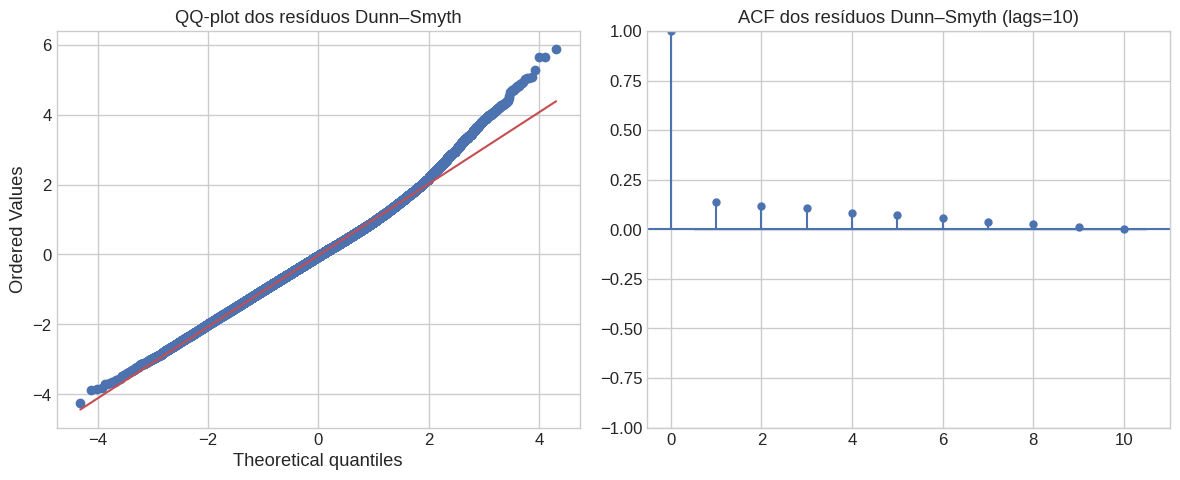

In [87]:
rqr = compute_rqr(modelo_binomial_stepwise, y, family='nb2', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_binomial_stepwise),
    resid_pearson=modelo_binomial_stepwise.resid_pearson,
    df_resid=modelo_binomial_stepwise.df_resid,
    lags=10,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagnóstico RQR — Modelo Binomial Stepwise",
    alpha=0.05,
    acf_lags=10
)

O gráfico acima mostra que, mesmo com seleção stepwise na Binomial Negativa, o modelo ainda tem dificuldade sobretudo para médias previstas baixas (μ).
Persiste um padrão de “funil”: a variância dos resíduos é maior quando μ é pequeno e vai diminuindo com o aumento de μ — logo, a variância não é constante.
A suavização levemente descendente indica viés (subestima em μ baixos e tende a superestimar em μ mais altos).
Embora haja melhora em relação ao Poisson, ainda existe heterogeneidade/zeros não explicados.

### Modelo Zero-Inflated Poisson (ZIP)  

Modelagem de Dados de Contagem com Excesso de Zeros

O **Modelo Zero-Inflated Poisson (ZIP)** é uma extensão do modelo de regressão de Poisson, utilizado quando os dados de contagem apresentam uma **frequência excessiva de zeros**, superior àquela esperada pela distribuição de Poisson. Esse tipo de modelo permite separar o processo gerador de zeros do processo de contagem positivo, proporcionando uma abordagem mais flexível para lidar com esse tipo de estrutura nos dados.

---

### Estrutura do ZIP

O modelo ZIP assume que os dados são gerados por **dois processos distintos**:

1. Um processo binário (discreto), que determina se a observação pertence à **parte estrutural de zeros** (com probabilidade $\pi_i$);
2. Um processo de contagem, que segue uma **distribuição de Poisson** com parâmetro $\lambda_i$, para as observações que **não pertencem** à parte estrutural de zeros (com probabilidade $1 - \pi_i$).

A distribuição de probabilidade para $Y_i$ no modelo ZIP é definida como:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot e^{-\lambda_i}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \frac{\lambda_i^k e^{-\lambda_i}}{k!}, \quad \text{para } k = 1, 2, 3, \dots
$$

---

### Componentes do Modelo

O ZIP envolve duas submodelagens:

#### 1. Modelo para contagem (Poisson)

A média esperada da parte de contagem é modelada com função de ligação logarítmica:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\lambda_i = \exp(x_i^\top \beta)
$$

#### 2. Modelo logístico para inflação de zeros

A probabilidade $\pi_i$ de uma observação pertencer à parte inflacionada de zeros é modelada via regressão logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

onde:

- $x_i$ é o vetor de preditores da parte Poisson (contagem);
- $z_i$ é o vetor de preditores da parte binária (zero inflacionado), que pode coincidir ou não com $x_i$;
- $\beta$ e $\gamma$ são os vetores de coeficientes de cada parte do modelo.

---

### Interpretação dos Coeficientes

#### Parte de contagem (Poisson):

Os coeficientes $\beta_j$ representam o **efeito logarítmico** sobre a taxa de contagem, tal como na regressão de Poisson. A razão de taxas é dada por:

$$
e^{\beta_j}
$$

e indica o multiplicador da média esperada de eventos para uma unidade adicional em $x_{ij}$.

#### Parte de inflação de zeros (logística):

Os coeficientes $\gamma_j$ representam o **efeito log-odds** sobre a probabilidade de que a observação pertença à parte estrutural de zeros. A exponenciação dos coeficientes fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros é feita por **máxima verossimilhança**, utilizando uma função composta que combina as verossimilhanças das partes Poisson e logística. O processo é iterativo e requer inicialização adequada dos parâmetros.

---

### Utilização

O modelo ZIP é adequado para situações em que:

- A variável de contagem apresenta um **excesso de zeros** não compatível com a distribuição de Poisson;
- Há **dois mecanismos distintos** para geração de zeros: um processo estrutural e outro aleatório (via Poisson);
- Deseja-se identificar **fatores associados à presença estrutural de zeros**, além da contagem em si.

---

### Considerações

- A escolha entre o modelo de Poisson, Binomial Negativa e ZIP deve ser guiada por testes de sobredispersão e verificação do excesso de zeros nos dados.
- O modelo ZIP permite maior flexibilidade e interpretação, porém requer cuidado na separação adequada dos preditores entre as duas partes do modelo.

#### Validação de presuposto

Os dados devem apresentar **equidispersão**, ou seja, média igual a variância.

In [88]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

,Média,Variância
0,0.149005,0.336727


Existe uma diferença muito grande entre a média e a variancia referente a variável alvo, indicando possível subdispersão nos dados.

##### Completo

In [89]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy()
X1 = sm.add_constant(X1)

In [90]:
modelo_zip = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, offset=np.log(X['duration_sec'])).fit(disp=False) # , method='lbfgs', cov_type='HC1'
modelo_zip.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                86185
Model:             ZeroInflatedPoisson   Df Residuals:                    86171
Method:                            MLE   Df Model:                           13
Date:                 Mon, 08 Sep 2025   Pseudo R-squ.:                -0.04451
Time:                         02:41:31   Log-Likelihood:                -35910.
converged:                       False   LL-Null:                       -34379.
Covariance Type:             nonrobust   LLR p-value:                     1.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
inflate_const                      0.0996        nan        nan        nan         nan         nan
inflate_total_amount              -0.0316        nan        nan        nan         nan         nan
inflate_chip_ratio                 0.1079        nan        nan        nan         nan         nan
inflate_avg_transactions_value    -0.0441        nan        nan        nan         nan         nan
inflate_geo_dispersion             0.0734        nan        nan        nan         nan         nan
inflate_avg_credit_score          -0.0735        nan        nan        nan         nan         nan
inflate_error_ratio                0.1000        nan        nan        nan         nan         nan
inflate_hour_sin                   0.0950        nan        nan        nan         nan         nan
inflate_hour_cos                   0.1044        nan        nan        nan         nan         nan
inflate_day_sin                    0.1071        nan        nan        nan         nan         nan
inflate_day_cos                    0.0942        nan        nan        nan         nan         nan
inflate_is_holiday                 0.0993        nan        nan        nan         nan         nan
inflate_velocity_alert             0.1000        nan        nan        nan         nan         nan
inflate_cards_per_client           0.0998        nan        nan        nan         nan         nan
const                            -11.3697        nan        nan        nan         nan         nan
total_amount                       0.0002        nan        nan        nan         nan         nan
chip_ratio                         0.4726        nan        nan        nan         nan         nan
avg_transactions_value            -0.0099        nan        nan        nan         nan         nan
geo_dispersion                    -0.0060        nan        nan        nan         nan         nan
avg_credit_score                   0.0005        nan        nan        nan         nan         nan
error_ratio                        0.0008        nan        nan        nan         nan         nan
hour_sin                          -0.0329        nan        nan        nan         nan         nan
hour_cos                          -1.1364        nan        nan        nan         nan         nan
day_sin                           -0.1407        nan        nan        nan         nan         nan
day_cos                            0.0330        nan        nan        nan         nan         nan
is_holiday                        -0.0653        nan        nan        nan         nan         nan
velocity_alert                     0.0016        nan        nan        nan         nan         nan
cards_per_client                   0.0070        nan        nan        nan         nan         nan
==================================================================================================
"""

In [91]:
overdisp_plot_enhanced(modelo_zip, 'Zip - Completo')

KeyboardInterrupt: 

Family zip



# Diagnóstico RQR — Modelo Zip

**Nível de significância:** _α = 0.050_

## Resumo
| Checagem | Resultado |
|---|:--:|
| Normalidade (RQR ~ N(0,1)) | NOK |
| Média = 0 | NOK |
| Variância = 1 | NOK |
| Independência (Ljung–Box) | NOK |
| Caudas (|r|>2, |r|>3) | NOK |
| Heterocedasticidade (padrão r²~μ) | NOK |
| Dispersão global (φ̂, Pearson) | NOK |


## 1) Normalidade
| Teste | Estatística | p-valor | Resultado |
|---|---:|---:|:--:|
| Shapiro–Wilk | 0.9799 | 4.012e-70 | NOK |
| Jarque–Bera  | 14156.87 | 0.000e+00 | NOK |

## 2) Localização e Escala
| Medida | Valor |
|---|---:|
| Média (E[r]) | -0.028074 |
| Desvio-padrão (SD[r]) | 1.067750 |

| Teste | Hipótese | Estatística | p-valor | Resultado |
|---|---|---:|---:|:--:|
| t (média=0) | H₀: E[r]=0 | -7.719 | 1.186e-14 | NOK |
| χ² (var=1) | H₀: Var[r]=1 | 98257.52 | 0.000e+00 | NOK |

## 3) Independência (Ljung–Box)
| Estatística Q | p-valor | Resultado |
|---:|---:|:--:|
| 6997.627 | 0.000e+00 | NOK |

## 4) Heterocedasticidade (padrão r² ~ μ)
| Coef. de μ | t | p-valor | Resultado |
|---:|---:|---:|:--:|
| 0.972179 | 17.259 | 9.634e-67 | NOK |

## 5) Dispersão Global (Escala)
| Estatística | df | φ̂ | p(two-sided) | Resultado | Observação |
|---:|---:|---:|---:|:--:|---|
| 153197.41 | 86171 | 1.7778 | 0.000e+00 | NOK | Superdispersão (φ̂>1) |

## 6) Caudas (|r|>2, |r|>3)
Esperado em N(0,1): P(|r|>2)≈4.55%, P(|r|>3)≈0.27%

| Regra | Contagem observada | p-valor binomial | Resultado |
|---|---:|---:|:--:|
| |r| > 2 | 5120 | 1.926e-78 | NOK |
| |r| > 3 | 1136 | 0.000e+00 | NOK |

---
### Interpretação rápida
- Normalidade: NOK; Média/Variância: NOK; Independência: NOK; Caudas: NOK.
- Heterocedasticidade (r²~μ): NOK.
- Dispersão global: NOK (Superdispersão (φ̂>1)).


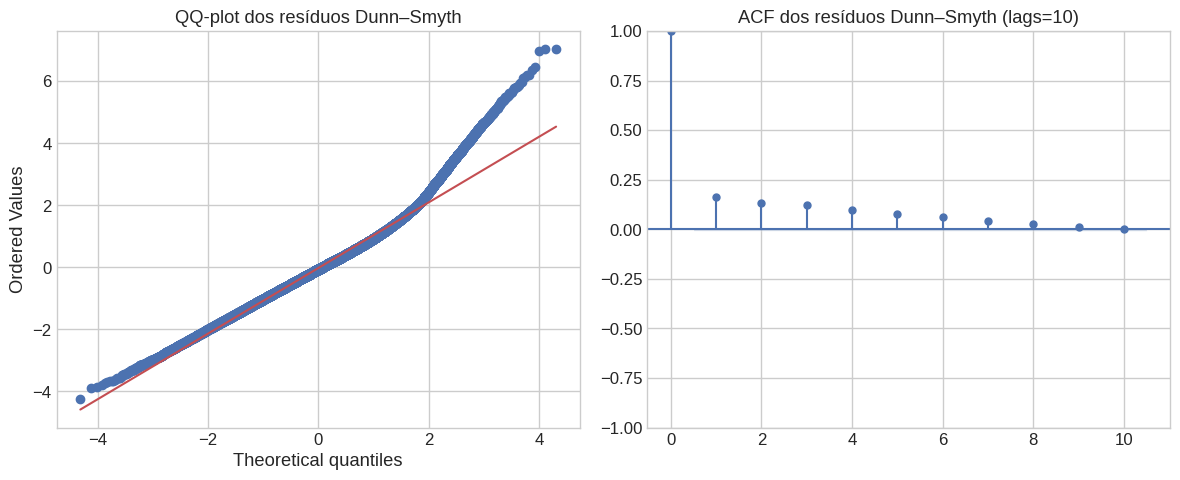

In [92]:
rqr = compute_rqr(modelo_zip, y, family='zip', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_zip),
    resid_pearson=modelo_zip.resid_pearson,
    df_resid=modelo_zip.df_resid,
    lags=10,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagnóstico RQR — Modelo Zip",
    alpha=0.05,
    acf_lags=10
)

O modelo ZIP não conseguiu convergir com todas as features da base.

In [93]:
vuong_test(modelo_poisson, modelo_zip)

Optimization terminated successfully.
         Current function value: 0.416344
         Iterations 17
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: 2.716
p-value: 0.003

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


Conforme teste de Vuong, é possível confirmar que os dados estão com inflação de zeros, sendo assim, o modelo ZIP acaba sendo indicado para esse problema em questão da inflação de zeros.

##### Stepwise

In [94]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy()

In [ ]:
step_wise = StepwiseZeroInflated(
    alpha=0.05,
    model_type='ZIP',
    selection_criterion='BIC',
    verbose=False,
    convergence_strictness='high',
    shuffle_features=True,
    shuffle_random_state=45,
    feature_groups=[['hour_sin', 'hour_cos'], ['day_sin', 'day_cos']]
)
random_selector_zip = RandomFeatureSelector(step_wise, max_features=0.85, random_state=45, feature_groups=[['hour_sin', 'hour_cos'], ['day_sin', 'day_cos']])
random_selector_zip.fit(X1, y, np.log(X['duration_sec']))

In [ ]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(map(lambda x: x.final_model_, random_selector_zip.models)):
    plt.subplot(5, 2, i+1)
    overdisp_plot_enhanced(model, f'Zip Stepwise {i}')

plt.tight_layout()
plt.show()

In [ ]:
df_trained_zip = build_count_models_report(list(enumerate(map(lambda x: x.final_model_, random_selector_zip.models))), criterion='BIC')
df_trained_zip

In [ ]:
best_model_index_zip = df_trained_zip.loc[0, 'model_name']
best_model_index_zip

In [ ]:
modelo_zip_stepwise = random_selector_zip.models[best_model_index_zip].final_model_
modelo_zip_stepwise.summary()

In [ ]:
overdisp_plot_enhanced(modelo_zip_stepwise, 'Zip - Stepwise')

In [ ]:
rqr = compute_rqr(modelo_zip_stepwise, y, family='zip', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_zip_stepwise),
    resid_pearson=modelo_zip_stepwise.resid_pearson,
    df_resid=modelo_zip_stepwise.df_resid,
    lags=20,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagnóstico RQR — Modelo Zip Stepwise",
    alpha=0.05,
    acf_lags=10
)

In [ ]:
vuong_test(modelo_poisson_stepwise, modelo_zip_stepwise)

O gráfico do ZIP–Stepwise ainda exibe “funil”: a variância dos resíduos é maior para μ baixos (≈2–4) e se estabiliza à medida que μ cresce, violando a equidispersão.
A suavização levemente negativa sugere viés (subestima em μ pequenos).
A maioria dos pontos está em ±2, mas há outliers positivos concentrados em μ<4, indicando heterogeneidade remanescente.
Conclusão: a inflação de zeros reduziu o problema, porém não o eliminou.

### Modelo Zero-Inflated Negative Binomial (ZINB)  
Modelagem de Contagem com Sobredispersão e Excesso de Zeros

O **Modelo Zero-Inflated Negative Binomial (ZINB)** é uma extensão do modelo Zero-Inflated Poisson (ZIP), indicado quando os dados de contagem apresentam simultaneamente:

- Um **excesso de zeros** não compatível com a distribuição de Poisson ou Binomial Negativa;
- Uma **sobredispersão** (variância maior que a média) nas contagens positivas.

Esse modelo permite que a variável resposta $Y_i$ seja gerada por dois processos distintos:

1. Um processo binário que determina a ocorrência de **zeros estruturais** com probabilidade $\pi_i$;
2. Um processo de **contagem sob a distribuição Binomial Negativa** com média $\mu_i$ e parâmetro de dispersão $\theta$, para as demais observações.

---

### Estrutura do Modelo

A função de probabilidade do modelo ZINB é definida da seguinte forma:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \binom{k + \theta - 1}{k} \cdot \left( \frac{\mu_i}{\mu_i + \theta} \right)^k \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}, \quad \text{para } k = 1, 2, 3, \dots
$$

onde:

- $\mu_i > 0$ é a média condicional do componente Binomial Negativo;
- $\theta > 0$ é o parâmetro de dispersão;
- $\pi_i$ é a probabilidade de a observação pertencer à **parte inflacionada de zeros**.

---

### Componentes do Modelo

O modelo é composto por duas partes principais:

#### 1. Parte de contagem (Binomial Negativa)

A média da distribuição é modelada com função de ligação logarítmica:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\mu_i = \exp(x_i^\top \beta)
$$

#### 2. Parte de inflação de zeros (Logística)

A probabilidade $\pi_i$ é modelada com uma função logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

---

### Variância

A variância condicional da parte de contagem segue a distribuição Binomial Negativa:

$$
\mathrm{Var}(Y_i \mid Y_i > 0) = \mu_i + \frac{\mu_i^2}{\theta}
$$

O termo adicional $\frac{\mu_i^2}{\theta}$ permite capturar sobredispersão, ajustando o modelo para casos em que a variabilidade excede a esperada por uma Poisson.

---

### Interpretação dos Coeficientes

#### Parte de Contagem (Binomial Negativa)

- Os coeficientes $\beta_j$ são interpretados como efeitos logarítmicos sobre a média $\mu_i$.
- A razão de taxas $e^{\beta_j}$ indica o **fator multiplicativo** sobre a contagem média de eventos para uma variação unitária em $x_{ij}$.

#### Parte de Zeros (Logística)

- Os coeficientes $\gamma_j$ representam o efeito **log-odds** sobre a probabilidade de a observação pertencer ao componente de zeros estruturais.
- O termo $e^{\gamma_j}$ fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros $\beta$, $\gamma$ e $\theta$ é feita por **máxima verossimilhança**, com otimização conjunta das duas partes do modelo. A presença do parâmetro de dispersão $\theta$ requer métodos numéricos robustos para convergência adequada.

---

### Utilização

O modelo ZINB é apropriado quando:

- A variável resposta apresenta **muitos zeros** e **sobredispersão** simultaneamente;
- Há **dois mecanismos distintos** de geração de zeros: um estrutural (determinístico) e outro probabilístico (contagem);
- É necessário identificar fatores que influenciam tanto a **presença de zeros estruturais** quanto o **nível da contagem**.

---

### Considerações Finais

O modelo ZINB é uma alternativa robusta ao ZIP e à Binomial Negativa padrão. Ele oferece maior capacidade de ajuste e interpretação quando a estrutura dos dados de contagem é complexa, com variações acentuadas e presença de dois regimes distintos (zero e contagem positiva).


#### Validação de presuposto

Os dados devem apresentar **sobredispersão**, ou seja, variância é maior que a média.

In [ ]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

##### Completo

In [ ]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy(deep=True)
X1 = sm.add_constant(X1)

In [ ]:
modelo_zinb = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, offset=np.log(X['duration_sec'])).fit(disp=False) # , method='lbfgs', cov_type='HC1'
modelo_zinb.summary()

In [ ]:
overdisp_plot_enhanced(modelo_zinb, 'Zip - Completo')

In [ ]:
rqr = compute_rqr(modelo_zinb, y, family='zinb', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_zinb),
    resid_pearson=modelo_zinb.resid_pearson,
    df_resid=modelo_zinb.df_resid,
    lags=20,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagnóstico RQR — Modelo Zinb",
    alpha=0.05,
    acf_lags=10
)

O modelo ZINB não conseguiu convergir com todas as features da base.

In [ ]:
vuong_test(modelo_binomial, modelo_zinb)

##### Stepwise

In [ ]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy()

In [ ]:
step_wise = StepwiseZeroInflated(
    alpha=0.05,
    model_type='ZINB',
    selection_criterion='LLF',
    verbose=False,
    convergence_strictness='high',
    shuffle_features=True,
    shuffle_random_state=42,
    feature_groups=[['hour_sin', 'hour_cos'], ['day_sin', 'day_cos']]
)
random_selector_bneg = RandomFeatureSelector(step_wise, max_features=0.75, random_state=42, feature_groups=[['hour_sin', 'hour_cos'], ['day_sin', 'day_cos']])
random_selector_bneg.fit(X1, y, np.log(X['duration_sec']))

In [ ]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(map(lambda x: x.final_model_, random_selector_bneg.models)):
    plt.subplot(5, 2, i + 1)
    overdisp_plot_enhanced(model, f'Zinb Stepwise {i}')

plt.tight_layout()
plt.show()

In [ ]:
df_trained_zinb = build_count_models_report(list(enumerate(map(lambda x: x.final_model_, random_selector_bneg.models))), criterion='BIC')
df_trained_zinb

In [ ]:
best_model_index_zinb = df_trained_zinb.loc[0, 'model_name']
best_model_index_zinb

In [ ]:
modelo_zinb_stepwise = random_selector_bneg.models[best_model_index_zinb].final_model_
modelo_zinb_stepwise.summary()

In [ ]:
overdisp_plot_enhanced(modelo_zinb_stepwise, 'ZIMB - Stepwise')

In [ ]:
rqr = compute_rqr(modelo_zinb_stepwise, y, family='zinb', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_zinb_stepwise),
    resid_pearson=modelo_zinb_stepwise.resid_pearson,
    df_resid=modelo_zinb_stepwise.df_resid,
    lags=20,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagnóstico RQR — Modelo Zinb Stepwise ",
    alpha=0.05,
    acf_lags=10
)

O gráfico do ZIMB–Stepwise indica que a heterogeneidade foi bem capturada: o “funil” é discreto e a variância dos resíduos se mantém mais estável ao longo de μ.
A suavização fica próxima de zero, com leve tendência negativa (viés pequeno em μ baixos).
A maioria dos pontos está dentro de ±2 e os outliers são poucos, concentrados em μ≈2–3.
Em síntese, entre os modelos analisados este apresenta o melhor equilíbrio para sobredispersão e excesso de zeros.

In [ ]:
vuong_test(modelo_binomial_stepwise, modelo_zinb_stepwise)

## Análise dos modelos

Analise geral dos modelos a fim de compreender as metricas existentes entre os modelos

In [ ]:
titles = [
    'Poisson Completo',
    'Poisson StepWise',
    'Binomial Completo',
    'Binomial Stepwise',
    'ZIP Completo',
    'ZIP Stepwise',
    'ZINB Completo',
    'ZINB Stepwise'
]
models = [
    modelo_poisson,
    modelo_poisson_stepwise,
    modelo_binomial,
    modelo_binomial_stepwise,
    modelo_zip,
    modelo_zip_stepwise,
    modelo_zinb,
    modelo_zinb_stepwise
]

##### Analise dos modelos com base em seu LLF

In [ ]:
def print_compare_models():
  selected_models = []
  selected_names = []

  for model, name in zip(models, titles):
    if model.converged:
      selected_models.append(model)
      selected_names.append(name)

  compare_models({
    'modelo':selected_names,
    'loglik':[model.llf for model in selected_models]
  })

print_compare_models()

Analisando diretamente a métrica do LLF podemos ver claramente que o modelo ZINB obeteve um melhor resultado, sugerindo que esse possa ser o melho modelo, no entanto será necessário validar outros aspectos a fim de garantir que esse modelo realmente possa ser utilizado.

### Dispersão dos residuos

In [ ]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(models):
    plt.subplot(5, 2, i + 1)
    overdisp_plot_enhanced(model, titles[i])

plt.tight_layout()
plt.show()

* Poisson (completo/stepwise): forte “funil” e muitos |r|>2 em μ baixos ⇒ pressuposto de equidispersão violado e viés (tendência descendente).

* Binomial Negativa (completo/stepwise): reduz bem a heteroscedasticidade; ainda há leve viés negativo e outliers concentrados em μ<4.

* ZIP–Stepwise: melhora a região de μ baixos, mas permanece funil moderado e alguns outliers positivos ⇒ excesso de zeros parcialmente capturado.

* ZIMB–Stepwise: dispersão mais homogênea, suavização próxima de 0 e poucos outliers; melhor equilíbrio entre sobredispersão e zeros.

<!-- ## Critério de Seleção de Modelos

Dado um conjunto de modelos $\{m=1,\dots,M\}$, definimos um
**score composto** $S_m \in [0,100]$ e selecionamos

$$
  m^\star = \arg\max_{m} S_m .
$$

---

### 1) Normalização do critério principal $\kappa_m \in \{\text{AIC},\text{BIC},\text{LLF}\}$

Se $\kappa$ for **AIC/BIC** (quanto menor, melhor):

$$
  \widehat C_m = \frac{\max_j \kappa_j - \kappa_m}{\max_j \kappa_j - \min_j \kappa_j}
  \in [0,1].
$$

Se $\kappa$ for **LLF** (quanto maior, melhor):

$$
  \widehat C_m = \frac{\kappa_m - \min_j \kappa_j}{\max_j \kappa_j - \min_j \kappa_j}
  \in [0,1].
$$

---

### 2) Score de Dispersão Global (Pearson)

Seja

$$
  \phi_m = \frac{\sum_i (r^{(P)}_{im})^2}{\text{df}_{\text{resid},m}} .
$$

Penalizamos desvios de $\phi=1$:

$$
  D_m = \exp\!\left(-\lambda \, \big|\log \phi_m\big|\right), \quad D_m \in (0,1].
$$

---

### 3) Score de Diagnóstico RQR

Considere os p-valores

$$
  \mathcal P_m = \{p^{SW}_m, \; p^{JB}_m, \; p^{LB}_m, \; p^{(2)}_m, \; p^{(3)}_m\},
$$

para Shapiro–Wilk, Jarque–Bera, Ljung–Box e proporções de cauda
$P(|r|>2)$ e $P(|r|>3)$ dos resíduos Dunn–Smyth.

Defina

$$
  g(p;\alpha)=\min\!\left(1,\;\frac{p}{\alpha}\right),
$$

$$
  R_m = \frac{1}{5}\sum_{p\in \mathcal P_m} g(p;\alpha) \in [0,1].
$$

---

### 4) Preferências (Convergência e Faixa de Dispersão)

$$
  M_m = \mathbf{1}\{\text{modelo convergiu}\}\cdot \mathbf{1}\{L \le \phi_m \le U\},
$$

$$
  B_m = 1 + \beta\, M_m.
$$

---

### 5) Score Final

Com pesos $w_C,w_D,w_R,w_P \ge 0$ tais que $w_C+w_D+w_R+w_P=1$:

$$
  S_m = 100 \times B_m \times
  \Big( w_C\,\widehat C_m + w_D\,D_m + w_R\,R_m + w_P\,P_m \Big),
$$

onde $P_m = \mathbf{1}\{\text{modelo convergiu}\}$ (bônus adicional, opcional).

---

### 6) Seleção

O melhor modelo é

$$
  m^\star = \arg\max_m S_m .
$$

---

### Exemplo de Pesos

$$
  (w_C,w_D,w_R,w_P)=(0.50,\,0.20,\,0.25,\,0.05), \quad
  \lambda=1, \; \beta=0.05, \; [L,U]=[0.8,1.5], \; \alpha=0.05.
$$ -->


In [ ]:
df_metrics = build_count_models_report(list(zip(titles, models)), criterion='BIC').query('Converged == True')
df_metrics

### Comparação de metrics (LLF, AIC, BIC e R2)

In [ ]:
plt.figure(figsize=(18, 10))
plt.suptitle('Modelos de Contagem com Destaque do Melhor Modelo', fontsize=16)

highlight_color = '#32a852' # Verde
default_color = '#a9a9a9'   # Cinza

# --- Subplot 1: AIC ---
plt.subplot(2, 2, 1)
plt.title('Métrica AIC (Menor é Melhor)')
df_sorted = df_metrics.sort_values(by='AIC', ascending=True)
best_model_aic = df_metrics.loc[df_metrics['AIC'].idxmin()]['model_name']
palette_aic = [highlight_color if m == best_model_aic else default_color for m in df_sorted['model_name']]
sns.barplot(data=df_sorted, y='model_name', x='AIC', palette=palette_aic)
plt.xlabel('$AIC$')
plt.ylabel('Modelos')

# --- Subplot 2: BIC ---
plt.subplot(2, 2, 2)
plt.title('Métrica BIC (Menor é Melhor)')
df_sorted = df_metrics.sort_values(by='BIC', ascending=True)
best_model_bic = df_metrics.loc[df_metrics['BIC'].idxmin()]['model_name']
palette_bic = [highlight_color if m == best_model_bic else default_color for m in df_sorted['model_name']]
sns.barplot(data=df_sorted, y='model_name', x='BIC', palette=palette_bic)
plt.xlabel('$BIC$')
plt.ylabel('Modelos')

# --- Subplot 3: LLF ---
plt.subplot(2, 2, 3)
plt.title('Métrica LLF (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='LLF', ascending=False)
best_model_llf = df_metrics.loc[df_metrics['LLF'].idxmax()]['model_name']
palette_llf = [highlight_color if m == best_model_llf else default_color for m in df_sorted['model_name']]
sns.barplot(data=df_sorted, y='model_name', x='LLF', palette=palette_llf)
plt.xlabel('$LLF$ (Log-Verossimilhança)')
plt.ylabel('Modelos')

# --- Subplot 4: Score Composto ---
plt.subplot(2, 2, 4)
plt.title('Score Composto (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='Score', ascending=False)
best_model_score = df_metrics.loc[df_metrics['Score'].idxmax()]['model_name']
palette_score = [highlight_color if m == best_model_score else default_color for m in df_sorted['model_name']]
sns.barplot(data=df_sorted, y='model_name', x='Score', palette=palette_score)
plt.xlabel('Score')
plt.ylabel('Modelos')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


O painel acima mostra que um único critério não resolve o problema: AIC e LLF apontam o ZINB Stepwise como melhor ajuste (captura sobredispersão + zeros), enquanto o BIC — mais parcimonioso — favorece o NB Stepwise.
O Pseudo-R² destaca os modelos Poisson, mas essa métrica é pouco comparável entre famílias e tende a supervalorizar ajustes que violam a equidispersão observada nos resíduos.
Assim, para um ajuste realista dos dados, o ZINB Stepwise é o mais aderente; se a prioridade for simplicidade, o NB Stepwise é alternativa sólida.


In [ ]:
vuong_test(modelo_binomial_stepwise, modelo_zinb_stepwise)

Aplicando o teste Voung se valida que o modelo Zinb se adequa melhor ao problema uma vez que a hipotese nula foi refutada.

## Seleção do melhor modelo

In [ ]:
best_model = df_metrics.loc[0, 'model_name']
best_model

In [ ]:
indice = titles.index(best_model)
best_model = models[indice]
best_model.summary2()

<!-- #### Tabela de features -->

In [ ]:
# df_exog_inf = pd.DataFrame()
# if hasattr(best_model.model, 'exog_infl'):
#   df_exog_inf = best_model.model.exog_infl
#   feature_exog_inf = [column for column in best_model.model.exog_names if ('inflate_' in column)]
#   df_exog_inf = pd.DataFrame(df_exog_inf, columns=feature_exog_inf)

In [ ]:
# df_exog = best_model.model.exog
# features_exog = [column for column in best_model.model.exog_names if not ('inflate_' in column or 'alpha' in column)]
# df_exog = pd.DataFrame(df_exog, columns=features_exog)

In [ ]:
# df_features = pd.concat([df_exog, df_exog_inf], axis=1)
# df_features['residuos'] = best_model.resid_pearson.values if hasattr(best_model.resid_pearson, 'values') else best_model.resid_pearson
# df_features['fitted'] = best_model.fittedvalues.values
# df_features['target'] = y.values
# df_features

#### Análise das estatisticas computadas durante o treinamento

In [ ]:
rqr = compute_rqr(best_model, y, family='zinb', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(best_model),
    resid_pearson=best_model.resid_pearson,
    df_resid=best_model.df_resid,
    lags=20,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagnóstico RQR — Melhor Modelo - Zinb Stepwise",
    alpha=0.05,
    acf_lags=10
)

#### Histograma dos residuos de Dunn Smyth

In [ ]:
best_model_residuos = compute_rqr(best_model, y)

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(best_model_residuos, kde=True, color='skyblue')
plt.title("Histograma e KDE dos Resíduos de Dunn Smyth")
plt.xlabel("Resíduos de Dunn Smyth")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

#### Visualização da auto-correlação dos residuos de Dunn-Smyth

In [ ]:
plot_acf_pacf(best_model_residuos, 10)

## Ajuste no modelo para remoção de auto-correlação

In [ ]:
from statsmodels.tools import add_constant
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
X_leg = X[[param for param in best_model.params.index if ((not 'inflate_' in param) & (not 'const' in param) & (not 'alpha' in param))]]
X_inflate_leg = X[[str(param).replace('inflate_', '') for param in best_model.params.index if ('inflate_' in param) and (not 'const' in param) and (not 'alpha' in param)]]
offset_leg = np.log(X['duration_sec'])

In [ ]:
def fit_zinb(y, X, X_infl, offset=None, maxiter=200, start_params=None):
    model = ZeroInflatedNegativeBinomialP(
        endog=y,
        exog=add_constant(X, has_constant='add'),
        exog_infl=add_constant(X_infl, has_constant='add'),
        inflation='logit',
        offset=offset  # offset apenas no componente de contagem
    )
    res = model.fit(method='bfgs', maxiter=maxiter, disp=0, start_params=start_params)
    return res

In [ ]:
def ljungbox_pvalues(residuals, lags=10):
    lb = acorr_ljungbox(residuals, lags=lags, return_df=True)
    return lb['lb_pvalue']

In [ ]:
def arma_correction_series(resid, order=(1,0,1), seasonal_order=(0,0,0,0)):
    """
    Ajusta ARMA (via SARIMAX com d=0) nos resíduos e retorna o fitted in-sample
    como Series, preservando o índice temporal.
    """
    resid = pd.Series(resid)  # garante Series com índice
    mod = SARIMAX(
        resid, order=order, seasonal_order=seasonal_order,
        enforce_stationarity=False, enforce_invertibility=False
    )
    res = mod.fit(disp=False)
    fitted = pd.Series(res.fittedvalues, index=resid.index, name='arma_fit')
    return res, fitted

In [ ]:
def build_augmented_design(X, X_infl, corr_fit, *, name='arCorr', lags=(1,), add_to=("X","Z")):
    """
    Cria lags do componente ARMA e adiciona em X e/ou X_infl.
    Use add_to=("X",) para adicionar apenas na contagem e reduzir nº de parâmetros.
    """
    X = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
    X_infl = X_infl.copy() if isinstance(X_infl, pd.DataFrame) else pd.DataFrame(X_infl)

    base_index = X.index if isinstance(X, pd.DataFrame) else corr_fit.index
    X.index = base_index
    X_infl.index = base_index

    aux = pd.DataFrame(index=base_index)
    aux[name] = pd.Series(corr_fit).reindex(base_index)

    for L in lags:
        aux[f'{name}_lag{L}'] = aux[name].shift(L)

    lag_cols = [c for c in aux.columns if c.startswith(f'{name}_lag')]

    X_aug = X.copy()
    Z_aug = X_infl.copy()
    if "X" in add_to:
        X_aug = pd.concat([X_aug, aux[lag_cols]], axis=1)
    if "Z" in add_to:
        Z_aug = pd.concat([Z_aug, aux[lag_cols]], axis=1)

    # df com as lags para controlar dropna posterior
    df_lags = aux[lag_cols]
    return df_lags, X_aug, Z_aug

In [ ]:
def zinb_with_ar_correction(y, X, X_infl, offset=None,
                            ar_order=(1,0,1), lags_to_use=(1,),
                            add_to=("X","Z"),
                            max_rounds=3, alpha=0.05, lb_lags=10):
    """
    Loop:
      1) Ajusta ZINB (X, X_infl, offset)
      2) Testa Ljung-Box nos resíduos de Pearson
      3) Se falhar: ajusta ARMA nos resíduos, cria lags -> concatena em X e X_infl
      4) Reajusta ZINB com as matrizes augmentadas (e offset realinhado)
      5) Repete até parar de rejeitar (ou atingir max_rounds)
    """
    # Cópias de trabalho
    _y = y.copy()
    _X = X.copy()
    _X_infl = X_infl.copy()
    _offset = offset.copy() if offset is not None else None

    if _offset is not None:
      _offset = _offset.replace([np.inf, -np.inf], np.nan)

    # 0) Ajuste inicial (ZINB puro)
    res = fit_zinb(_y, _X, _X_infl, _offset)
    best = res

    for rnd in range(1, max_rounds + 1):
        resid = pd.Series(res.resid_pearson, index=_y.index)

        # 1) Ljung-Box
        pvals = ljungbox_pvalues(resid.dropna(), lags=lb_lags)
        if (pvals > alpha).all():
            # Sem autocorrelação remanescente
            break

        # 2) ARMA nos resíduos
        arma_res, arma_fit = arma_correction_series(resid.fillna(0.0), order=ar_order)

        # 3) Construir regressoras augmentadas com lags (usa argumentos passados!)
        df_lags, X_aug, X_infl_aug = build_augmented_design(_X, _X_infl, arma_fit, name='arCorr', lags=lags_to_use, add_to=add_to)

        # 4) Alinhamento/limpeza (drop de NaNs gerados pelas lags)
        valid_idx = X_aug.dropna().index.intersection(X_infl_aug.dropna().index).intersection(df_lags.dropna().index)
        y_use = _y.loc[valid_idx]
        X_use = X_aug.loc[valid_idx]
        X_infl_use = X_infl_aug.loc[valid_idx]
        offset_use = _offset.loc[valid_idx] if _offset is not None else None

        # 5) Reajuste com as MATRIZES AUGMENTADAS
        res = fit_zinb(y_use, X_use, X_infl_use, offset_use)
        best = res

        # 6) Atualiza bases para próxima iteração (mantendo as lags atuais como parte do design)
        _y, _offset = y_use, offset_use

    return best, _y

In [ ]:
model_leg, _y = zinb_with_ar_correction(y, X_leg, X_inflate_leg, offset_leg, ar_order=(1,0,1), lags_to_use=(1,2,3,), max_rounds=5, add_to=('X' ))
print(model_leg.summary())

In [ ]:
_y.shape

In [ ]:
model_leg_residuos = compute_rqr(model_leg, _y)

In [ ]:
print(acorr_ljungbox(model_leg_residuos, lags=10, return_df=True))

In [ ]:
residuos_ljung_box_autocorrelacao_test(model_leg_residuos, 10)

In [ ]:
plot_acf_pacf(model_leg_residuos, 10)

## Inferência Estatistica

Identificar as features que possam melhor identificar as fraudes através de um processo de inferência estatística.

In [ ]:
best_model.summary()

In [ ]:
# Calculando a estatística Qui-quadrado de Pearson
chi2_stat = np.sum(best_model.resid_pearson**2)
dof = best_model.df_resid # Graus de liberdade (observações - número de parâmetros)
p_value_gof = stats.chi2.sf(chi2_stat, dof)

print("\n--- Diagnóstico do Modelo ---")
print(f"Estatística Qui-quadrado de Pearson: {chi2_stat:.2f}")
print(f"Graus de Liberdade: {dof}")
print(f"P-valor do Teste de Goodness-of-Fit: {p_value_gof:.4f}")

if p_value_gof > 0.05:
    print("Conclusão: Não há evidência para rejeitar a hipótese nula. O modelo parece se ajustar bem aos dados (p > 0.05).")
else:
    print("Conclusão: O p-valor é baixo (p <= 0.05), o que sugere um possível mau ajuste do modelo.")


#### Tabela de componentes

In [ ]:
df_inference = pd.concat([best_model.params.copy(), best_model.conf_int()], axis=1)
df_inference.index = [str(index).replace("Q('", '').replace("')", '') for index in df_inference.index]
df_inference.columns = ['params', '2.5%', '97.5%']
df_inference['IRR/Odds Ratio'] = np.exp(df_inference['params'])
df_inference

#### Análise do componente logístico (inflação de zeros estruturais)

##### Probabilidade média geral de ser um zero estrutural

In [ ]:
pi_hat = _predict_prob_zero(best_model)
np.mean(pi_hat)

O modelo estima que 54.95% das transações são zero estruturais, ou seja, são grupos de transações que são fundamentalmente diferentes, o risco de fraudes neles é, para todos os efeitos, nulos.

##### Componente de Inflação de Zeros Médio

In [ ]:
inflate_components = [str(component).replace('inflate_', '') for component in df_inference.index if ('inflate_' in component and not 'const' in component)]
inflate_components

In [ ]:
inflate_sample_means = X[inflate_components].mean(axis=0).to_frame().T.assign(const=1)
inflate_sample_means.columns = ['inflate_' + column for column in inflate_sample_means.columns]
inflate_sample_means = inflate_sample_means[[column for column in best_model.model.exog_names if 'inflate_' in column]]
inflate_sample_means

##### Experimento Ceteris Paribus para componente de Inflação

In [ ]:
var_types = {
    "chip_ratio": "proportion",
    "merchant_entropy": "entropy",
    "cards_per_client": "count",
    "avg_credit_score": "score",
    "avg_transactions_value": "currency",
}

In [ ]:
inflate_sample_deltas = suggest_natural_deltas(X, var_types)
inflate_sample_deltas

In [ ]:
inflate_sample_pi_base = best_model.predict(exog_infl=inflate_sample_means, which='prob-zero')
inflate_sample_pi_base

In [ ]:
inflate_sample_pi_base.mean()

O registro médio apresenta praticamente a mesma média geral do modelo, 55%.

In [ ]:
rows = []
for row in inflate_sample_deltas.to_dict(orient='records'):
    pi_after = simulate_delta_inflate(best_model, inflate_sample_means, inflate_sample_means.columns.to_list(), 'inflate_' + row['component'], row['delta']).mean()

    pi_base = inflate_sample_pi_base.mean()
    odds_base = _prob_to_odds(pi_base)
    odds_after = _prob_to_odds(pi_after)

    rows.append({
        "Variável (inflate)": row['component'],
        "Delta aplicado": row['delta'],
        "Prob. base (registro médio)": pi_base,
        "Prob. após delta": pi_after,
        "Diferença (p.p.)": (pi_after - pi_base) * 100,
        "Odds base": odds_base,
        "Odds após delta": odds_after,
        "Fator nas chances (empírico)": odds_after/odds_base
    })

In [ ]:
inflate_components_simulate = pd.DataFrame(rows)
Markdown(build_inflate_summary_table(inflate_components_simulate, inflate_sample_deltas, inflate_sample_pi_base.mean()))

#### Análise do componente de contagem

##### Componente de Contagem Médio

In [ ]:
counting_components = [str(component) for component in df_inference.index if ('inflate_' not in component and not 'const' in component and not 'alpha' in component)]
counting_components

In [ ]:
counting_components_means = X[counting_components].median(axis=0).to_frame().T.assign(const=1)
counting_components_means = counting_components_means[[column for column in best_model.model.exog_names if ('inflate_' not in column and 'alpha' not in column)]]
counting_components_means

In [ ]:
S = X['hour_sin'].mean()
C = X['hour_cos'].mean()
mu = np.arctan2(S, C)
mu

In [ ]:
h, m, s = angle_to_hour(mu)
print(f"{h:02d}:{m:02d}:{s:02d}")

In [ ]:
counting_components_means['hour_sin'] = np.sin(mu)
counting_components_means['hour_cos'] = np.cos(mu)
counting_components_means_map = counting_components_means.to_dict(orient='records')[0]
counting_components_means_map

##### Análise do padrão de hora

In [ ]:
df_hours = pd.DataFrame({'hour': np.arange(24)})
df_hours['hour_sin'] = np.sin(2 * np.pi * df_hours['hour'] / 24)
df_hours['hour_cos'] = np.cos(2 * np.pi * df_hours['hour'] / 24)
df_hours

In [ ]:
df_inference_params = df_inference.loc[[index for index in df_inference.index.to_list() if ('inflate_' not in index and index != 'alpha')], 'params']
df_inference_params

In [ ]:
offset_log = np.log(X['duration_sec'].values[0])
offset_log

In [ ]:
log_rate = df_inference_params['const']
log_rate += df_inference_params['hour_sin'] * df_hours['hour_sin']
log_rate += df_inference_params['hour_cos'] * df_hours['hour_cos']
log_rate += df_inference_params['cards_per_client'] * counting_components_means_map['cards_per_client']
log_rate += df_inference_params['avg_credit_score'] * counting_components_means_map['avg_credit_score']

In [ ]:
df_hours['expected_rate'] = np.exp(log_rate + offset_log)

In [ ]:
plot_hours(df_hours)

In [ ]:
# picos/vales usando a série que já contém exp(log_rate + offset_log)
peak_hour_row   = df_hours.loc[df_hours['expected_rate'].idxmax()]
trough_hour_row = df_hours.loc[df_hours['expected_rate'].idxmin()]

peak_hour    = int(peak_hour_row['hour'])
trough_hour  = int(trough_hour_row['hour'])
peak_count   = float(peak_hour_row['expected_rate'])    # = μ(h_pico)
trough_count = float(trough_hour_row['expected_rate'])  # = μ(h_vale)

percentage_diff = ((peak_count - trough_count) / trough_count) * 100

exposure = float(np.exp(offset_log))  # exposição correspondente ao offset em log

print("\n--- Análise da Curva Cíclica ---")
print(
    "O modelo aprende a TAXA por unidade de exposição λ(h). "
    f"Para obter a contagem esperada na janela, somamos o offset em log (={offset_log:.6f}) "
    f"ao preditor linear — equivalente a multiplicar a taxa pela exposição e^(offset)= {exposure:,.0f}."
)
print("\nResultados:")
print(f"  -> Horário de Pico de Atividade: {peak_hour:02d}:00h (Contagem esperada na janela: {peak_count:.5f})")
print(f"  -> Horário de Vale de Atividade: {trough_hour:02d}:00h (Contagem esperada na janela: {trough_count:.5f})")
print("\nConclusão da Inferência:")
print(
    f"  A contagem esperada no horário de pico ({peak_hour:02d}:00h) é "
    f"{percentage_diff:.1f}% maior do que no horário de vale ({trough_hour:02d}:00h)."
)
print("  (Essa diferença percentual independe do offset quando a exposição é constante ao longo das horas.)")


##### Experimento Ceteris Paribus para componente de Contagem

In [ ]:
var_types_count = {
    "cards_per_client": "count",
    "avg_credit_score": "score",
}

In [ ]:
count_sample_delta_types = suggest_natural_deltas(
    X[list(var_types_count.keys())],
    var_types=var_types_count,
    center="mean"
)

count_sample_delta_hours = cyclic_delta_from_sincos(X)

count_sample_deltas = pd.concat(
    [count_sample_delta_types, pd.DataFrame([count_sample_delta_hours])],
    ignore_index=True
)
count_sample_deltas

In [ ]:
inflate_sample_means

In [ ]:
counting_components_means

In [ ]:
pi0, mu0, EY0 = predict_components(best_model, counting_components_means.copy(), inflate_sample_means.copy(), offset_log)

In [ ]:
counting_components_means.columns.to_list()

In [ ]:
rows = []
count_names = counting_components_means.columns.to_list()
for r in count_sample_deltas.to_dict(orient='records'):
    component, delta, comp_type = r['component'], float(r['delta']), r['type']
    if delta <= 0:
        continue

    # aplica o Δ (hora = rotação; demais = soma escalar)
    if comp_type == "cyclic":
        rc1 = rotate_hour_features(counting_components_means.copy(), dhours=delta)
    else:
        rc1 = counting_components_means.copy()
        rc1.loc[:, component] = float(rc1[component]) + delta

    # guard-rails: const + ordem
    assert set(rc1.columns) >= set(count_names)
    rc1 = rc1[count_names]

    # previsões
    pi1, mu1, EY1 = predict_components(best_model, rc1, inflate_sample_means, offset_log)

    rows.append({
        "Variável (contagem)": ("hour" if comp_type == "cyclic" else component),
        "Delta aplicado": (f"{delta} h" if comp_type == "cyclic" else delta),
        "mu cond. base": mu0,
        "mu cond. após Δ": mu1,
        "IRR empírico (mu1/mu0)": mu1/mu0,
        "IRR teórico (exp(β·Δx))": irr_teorico_count(best_model, counting_components_means[count_names], rc1, count_names),
        "E[Y] base": EY0,
        "E[Y] após Δ": EY1,
        "Δ E[Y] abs.": EY1 - EY0,
        "Δ E[Y] rel. (%)": (EY1/EY0 - 1)*100 if EY0>0 else np.nan
    })

counting_components_simulate = pd.DataFrame(rows)
counting_components_simulate

In [ ]:
Markdown(build_counting_summary_table(counting_components_simulate, count_sample_deltas, inflate_sample_pi_base.mean()))

## Conclusão

Pode-se concluir que, as features:

* `avg_credit_score` e `chip_ratio` quando aumentadas em +1 unidade reduzem as changes de uma janela de transações permanecerem como zero estruturais.
* `cards_per_client` e `avg_credit_score` quando auementadas em +1 unidade aumentam as taxas/contagens esperadas de eventos.
* `hour` possui maior horario de pico as 02:00 e menor as 14:00.
